## Functions to create synthetic data

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#RANDOM WAVEGENERATORS: DURATION RANDOM, SHIFT RANDOM, AMPLITUDE RANDOM
# SAMPLING RATE = 1 PER MIN
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import random
def generateSignal(DURATION_HRS):
    hrs_comp = 0 # hours for which signal has been generated
    TOTAL_PTS = 60*(DURATION_HRS)
    X1 = np.zeros((TOTAL_PTS,), dtype=np.float64)
    X2 = np.zeros((TOTAL_PTS,), dtype=np.float64)
    Y = np.zeros((TOTAL_PTS,), dtype=np.float64)
    while hrs_comp < DURATION_HRS:
        classify = random.randint(0,1)
        dur = random.randint(1,3)
        if(hrs_comp+dur>DURATION_HRS):
            dur = DURATION_HRS - hrs_comp
        if (classify == 0):
            X1[hrs_comp*60:(hrs_comp+dur)*60] = randomSquareWave(dur)
            X2[hrs_comp*60:(hrs_comp+dur)*60] = randomSine(dur)
            Y[hrs_comp*60:(hrs_comp+dur)*60] = np.zeros((dur*60,), dtype=np.float64)
        if (classify == 1):
            X1[hrs_comp*60:(hrs_comp+dur)*60] = randomSawTooth(dur)
            X2[hrs_comp*60:(hrs_comp+dur)*60] = randomSineSquare(dur)
            Y[hrs_comp*60:(hrs_comp+dur)*60] = np.ones((dur*60,), dtype=np.float64)
        hrs_comp = hrs_comp + dur
    return X1,X2,Y


def randomSquareWave(END_TIME_HRS):
    START_TIME_HRS = 0
    A = random.randint(2,5)/3.0
    F = random.randint(2,7)/5.0
    S = random.randint(7,9)
    t = np.linspace(START_TIME_HRS,END_TIME_HRS, 60*(END_TIME_HRS - START_TIME_HRS), endpoint=False)
    X = S + A*signal.square(2 * np.pi * F * t)
    return X

def randomSawTooth(END_TIME_HRS):
    START_TIME_HRS = 0
    A = random.randint(2,5)/3.0
    F = random.randint(2,7)/5.0
    S = random.randint(7,9)
    t = np.linspace(START_TIME_HRS,END_TIME_HRS, 60*(END_TIME_HRS - START_TIME_HRS), endpoint=False)
    X = S + A*signal.sawtooth(2 * np.pi * F * t)
    return X

def randomSine(END_TIME_HRS):
    START_TIME_HRS = 0
    A = random.randint(1,3)/3.0
    F = random.randint(2,7)/5.0
    S = random.randint(0,2)
    t = np.linspace(START_TIME_HRS,END_TIME_HRS, 60*(END_TIME_HRS - START_TIME_HRS), endpoint=False)
    X = S + A*np.sin(2 * np.pi * F * t)
    return X

def randomSineSquare(END_TIME_HRS):
    START_TIME_HRS = 0
    A = random.randint(1,3)/3.0
    F = random.randint(2,7)/5.0
    S = random.randint(0,2)
    t = np.linspace(START_TIME_HRS,END_TIME_HRS, 60*(END_TIME_HRS - START_TIME_HRS), endpoint=False)
    X = S + A*np.multiply(np.sin(2 * np.pi * F * t),np.sin(2 * np.pi * F * t))
    return X

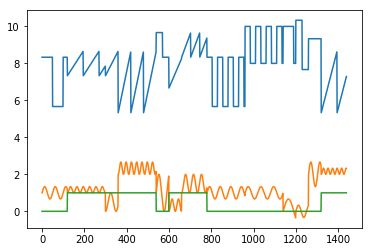

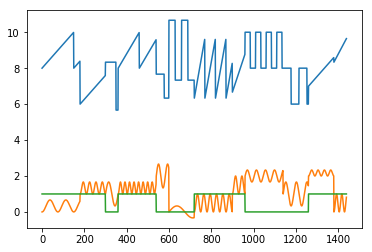

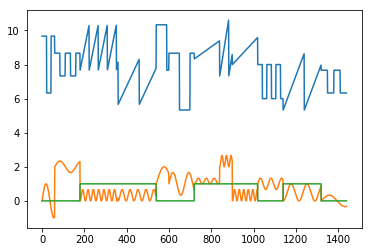

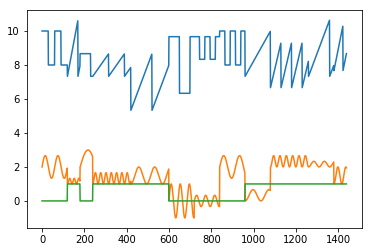

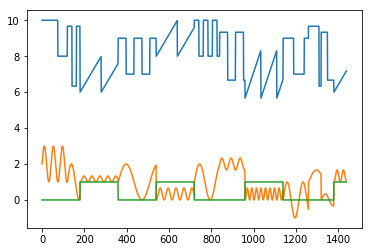

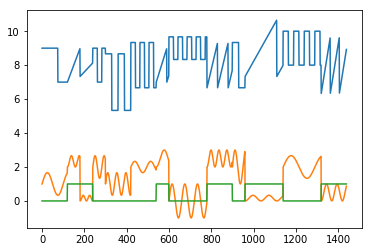

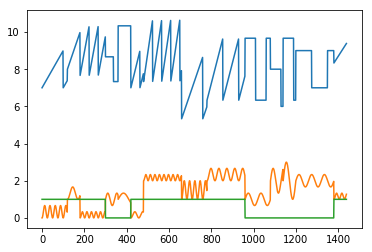

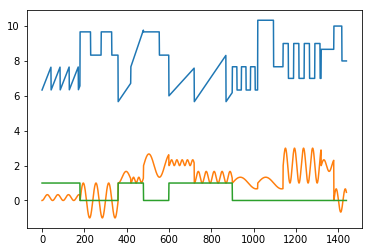

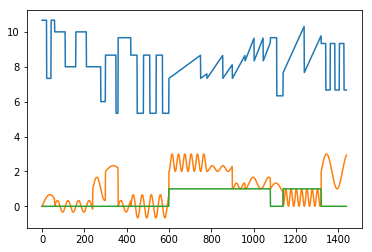

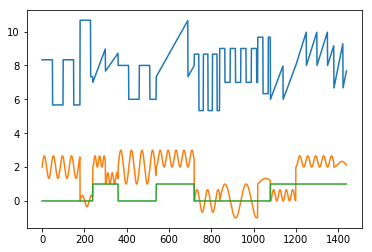

In [2]:
for i in range(10):
    [X1,X2,Y] = generateSignal(24)
    plt.plot(X1)
    plt.plot(X2)
    plt.plot(Y)
    plt.show()

## Creating Synthetic Data

In [3]:
# Make Training 500 Samples
N_TRAIN = 1000
N_VALID = 400
N_TEST = 300
DURATION_HRS = 24
TOTAL_PTS = 60*(DURATION_HRS)
X_TRAIN = np.zeros((N_TRAIN,TOTAL_PTS,2), dtype=np.float64)
Y_TRAIN = np.zeros((N_TRAIN,TOTAL_PTS,1), dtype=np.float64)
for i in range(N_TRAIN):
    [X1,X2,Y] = generateSignal(24)
    X_TRAIN[i,:,0] = X1
    X_TRAIN[i,:,1] = X2
    Y_TRAIN[i,:,:] = Y.reshape((TOTAL_PTS,1))

# Make Validation set of 200 Samples
X_VALID = np.zeros((N_VALID,TOTAL_PTS,2), dtype=np.float64)
Y_VALID = np.zeros((N_VALID,TOTAL_PTS,1), dtype=np.float64)
for i in range(N_VALID):
    [X1,X2,Y] = generateSignal(24)
    X_VALID[i,:,0] = X1
    X_VALID[i,:,1] = X2
    Y_VALID[i,:,:] = Y.reshape((TOTAL_PTS,1))

# Make Test Set of 300 Samples
X_TEST = np.zeros((N_TEST,TOTAL_PTS,2), dtype=np.float64)
Y_TEST = np.zeros((N_TEST,TOTAL_PTS,1), dtype=np.float64)
for i in range(N_TEST):
    [X1,X2,Y] = generateSignal(24)
    X_TEST[i,:,0] = X1
    X_TEST[i,:,1] = X2
    Y_TEST[i,:,:] = Y.reshape((TOTAL_PTS,1))


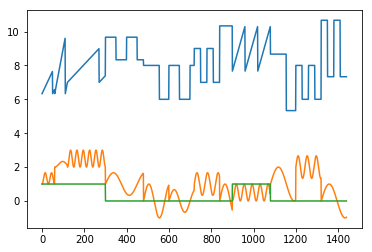

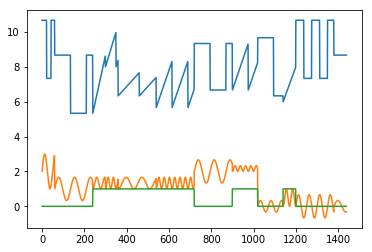

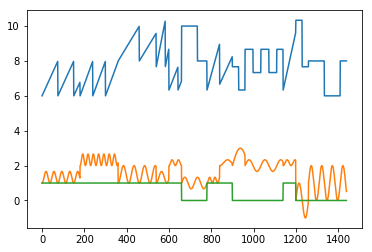

In [4]:
i = 4
plt.plot(X_TRAIN[i,:,0])
plt.plot(X_TRAIN[i,:,1])
plt.plot(Y_TRAIN[i,:,0])
plt.show()
plt.plot(X_VALID[i,:,0])
plt.plot(X_VALID[i,:,1])
plt.plot(Y_VALID[i,:,0])
plt.show()
plt.plot(X_TEST[i,:,0])
plt.plot(X_TEST[i,:,1])
plt.plot(Y_TEST[i,:,0])
plt.show()

## Creating model and training it

In [5]:
import keras as ks
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D,Conv1D, MaxPooling1D
from keras.utils import np_utils
from keras.initializers import RandomNormal
from keras import backend as Ks
from keras import optimizers
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint,CSVLogger

DURATION_HRS = 24
TOTAL_PTS = 60*(DURATION_HRS)
learning_rate = 0.00001
momentum = 0.0

model = ks.Sequential()
model.add(ks.layers.Conv1D(filters=10, kernel_size=5, strides=1, input_shape=(TOTAL_PTS,2),
                           padding='same',use_bias=True, 
                           kernel_initializer='glorot_uniform', bias_initializer='zeros'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(ks.layers.Conv1D(filters=10, kernel_size=5, strides=1,
                           padding='same',use_bias=True, 
                           kernel_initializer='glorot_uniform', bias_initializer='zeros'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(ks.layers.Conv1D(filters=10, kernel_size=5, strides=1,
                           padding='same',use_bias=True, 
                           kernel_initializer='glorot_uniform', bias_initializer='zeros'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(ks.layers.Conv1D(filters=10, kernel_size=5, strides=1,
                           padding='same',use_bias=True, 
                           kernel_initializer='glorot_uniform', bias_initializer='zeros'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(ks.layers.Conv1D(filters=10, kernel_size=5, strides=1,
                           padding='same',use_bias=True, 
                           kernel_initializer='glorot_uniform', bias_initializer='zeros'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(ks.layers.Conv1D(filters=10, kernel_size=5, strides=1,
                           padding='same',use_bias=True, 
                           kernel_initializer='glorot_uniform', bias_initializer='zeros'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(ks.layers.Conv1D(filters=1, kernel_size=5, strides=1,
                           padding='same',use_bias=True, 
                           kernel_initializer='glorot_uniform', bias_initializer='zeros'))
model.add(Activation('sigmoid'))
model.summary()
# sgd = SGD(lr=learning_rate, momentum=momentum)
adam = optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
csv_logger = CSVLogger('TSSLog1.csv')

model_checkpoint = ModelCheckpoint('TSSModel1.h5', monitor='val_loss', verbose=1, save_best_only=True,save_weights_only=False, mode='auto', period=1)

model.compile(loss='mean_squared_error', optimizer=adam, metrics=['acc'])

model.fit(X_TRAIN, Y_TRAIN, validation_data = (X_VALID,Y_VALID), epochs=5000,

          batch_size=500, callbacks=[csv_logger,model_checkpoint])


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1440, 10)          110       
_________________________________________________________________
activation_1 (Activation)    (None, 1440, 10)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1440, 10)          40        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1440, 10)          510       
_________________________________________________________________
activation_2 (Activation)    (None, 1440, 10)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1440, 10)          40        
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1440, 10)          510       
__________

1000/1000 [==============================] - 0s 374us/step - loss: 0.2819 - acc: 0.5321 - val_loss: 0.2816 - val_acc: 0.5361

Epoch 00024: val_loss improved from 0.28203 to 0.28161, saving model to TSSModel1.h5
Epoch 25/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.2816 - acc: 0.5322 - val_loss: 0.2812 - val_acc: 0.5368

Epoch 00025: val_loss improved from 0.28161 to 0.28119, saving model to TSSModel1.h5
Epoch 26/5000
1000/1000 [==============================] - 0s 364us/step - loss: 0.2812 - acc: 0.5327 - val_loss: 0.2808 - val_acc: 0.5377

Epoch 00026: val_loss improved from 0.28119 to 0.28078, saving model to TSSModel1.h5
Epoch 27/5000
1000/1000 [==============================] - 0s 369us/step - loss: 0.2809 - acc: 0.5334 - val_loss: 0.2804 - val_acc: 0.5384

Epoch 00027: val_loss improved from 0.28078 to 0.28036, saving model to TSSModel1.h5
Epoch 28/5000
1000/1000 [==============================] - 0s 370us/step - loss: 0.2805 - acc: 0.5338 - val_loss: 


Epoch 00060: val_loss improved from 0.27014 to 0.26991, saving model to TSSModel1.h5
Epoch 61/5000
1000/1000 [==============================] - 0s 382us/step - loss: 0.2704 - acc: 0.5441 - val_loss: 0.2697 - val_acc: 0.5546

Epoch 00061: val_loss improved from 0.26991 to 0.26969, saving model to TSSModel1.h5
Epoch 62/5000
1000/1000 [==============================] - 0s 363us/step - loss: 0.2701 - acc: 0.5441 - val_loss: 0.2695 - val_acc: 0.5549

Epoch 00062: val_loss improved from 0.26969 to 0.26946, saving model to TSSModel1.h5
Epoch 63/5000
1000/1000 [==============================] - 0s 365us/step - loss: 0.2699 - acc: 0.5440 - val_loss: 0.2692 - val_acc: 0.5550

Epoch 00063: val_loss improved from 0.26946 to 0.26924, saving model to TSSModel1.h5
Epoch 64/5000
1000/1000 [==============================] - 0s 386us/step - loss: 0.2696 - acc: 0.5442 - val_loss: 0.2690 - val_acc: 0.5553

Epoch 00064: val_loss improved from 0.26924 to 0.26902, saving model to TSSModel1.h5
Epoch 65/5000


1000/1000 [==============================] - 0s 378us/step - loss: 0.2620 - acc: 0.5543 - val_loss: 0.2620 - val_acc: 0.5608

Epoch 00097: val_loss improved from 0.26221 to 0.26200, saving model to TSSModel1.h5
Epoch 98/5000
1000/1000 [==============================] - 0s 365us/step - loss: 0.2618 - acc: 0.5546 - val_loss: 0.2618 - val_acc: 0.5612

Epoch 00098: val_loss improved from 0.26200 to 0.26179, saving model to TSSModel1.h5
Epoch 99/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.2616 - acc: 0.5550 - val_loss: 0.2616 - val_acc: 0.5613

Epoch 00099: val_loss improved from 0.26179 to 0.26158, saving model to TSSModel1.h5
Epoch 100/5000
1000/1000 [==============================] - 0s 381us/step - loss: 0.2613 - acc: 0.5556 - val_loss: 0.2614 - val_acc: 0.5613

Epoch 00100: val_loss improved from 0.26158 to 0.26138, saving model to TSSModel1.h5
Epoch 101/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.2611 - acc: 0.5559 - val_loss

1000/1000 [==============================] - 0s 378us/step - loss: 0.2483 - acc: 0.5834 - val_loss: 0.2487 - val_acc: 0.5808

Epoch 00169: val_loss improved from 0.24889 to 0.24873, saving model to TSSModel1.h5
Epoch 170/5000
1000/1000 [==============================] - 0s 365us/step - loss: 0.2481 - acc: 0.5838 - val_loss: 0.2486 - val_acc: 0.5811

Epoch 00170: val_loss improved from 0.24873 to 0.24858, saving model to TSSModel1.h5
Epoch 171/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.2480 - acc: 0.5840 - val_loss: 0.2484 - val_acc: 0.5815

Epoch 00171: val_loss improved from 0.24858 to 0.24842, saving model to TSSModel1.h5
Epoch 172/5000
1000/1000 [==============================] - 0s 381us/step - loss: 0.2478 - acc: 0.5844 - val_loss: 0.2483 - val_acc: 0.5817

Epoch 00172: val_loss improved from 0.24842 to 0.24826, saving model to TSSModel1.h5
Epoch 173/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.2476 - acc: 0.5849 - val_lo

1000/1000 [==============================] - 0s 365us/step - loss: 0.2365 - acc: 0.6163 - val_loss: 0.2375 - val_acc: 0.6120

Epoch 00241: val_loss improved from 0.23768 to 0.23752, saving model to TSSModel1.h5
Epoch 242/5000
1000/1000 [==============================] - 0s 363us/step - loss: 0.2364 - acc: 0.6167 - val_loss: 0.2374 - val_acc: 0.6126

Epoch 00242: val_loss improved from 0.23752 to 0.23735, saving model to TSSModel1.h5
Epoch 243/5000
1000/1000 [==============================] - 0s 370us/step - loss: 0.2362 - acc: 0.6173 - val_loss: 0.2372 - val_acc: 0.6132

Epoch 00243: val_loss improved from 0.23735 to 0.23719, saving model to TSSModel1.h5
Epoch 244/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.2361 - acc: 0.6177 - val_loss: 0.2370 - val_acc: 0.6138

Epoch 00244: val_loss improved from 0.23719 to 0.23703, saving model to TSSModel1.h5
Epoch 245/5000
1000/1000 [==============================] - 0s 364us/step - loss: 0.2359 - acc: 0.6181 - val_lo

1000/1000 [==============================] - 0s 372us/step - loss: 0.2251 - acc: 0.6453 - val_loss: 0.2258 - val_acc: 0.6435

Epoch 00313: val_loss improved from 0.22598 to 0.22584, saving model to TSSModel1.h5
Epoch 314/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.2249 - acc: 0.6455 - val_loss: 0.2257 - val_acc: 0.6438

Epoch 00314: val_loss improved from 0.22584 to 0.22569, saving model to TSSModel1.h5
Epoch 315/5000
1000/1000 [==============================] - 0s 366us/step - loss: 0.2248 - acc: 0.6458 - val_loss: 0.2255 - val_acc: 0.6442

Epoch 00315: val_loss improved from 0.22569 to 0.22555, saving model to TSSModel1.h5
Epoch 316/5000
1000/1000 [==============================] - 0s 368us/step - loss: 0.2246 - acc: 0.6460 - val_loss: 0.2254 - val_acc: 0.6445

Epoch 00316: val_loss improved from 0.22555 to 0.22540, saving model to TSSModel1.h5
Epoch 317/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.2245 - acc: 0.6463 - val_lo

1000/1000 [==============================] - 0s 360us/step - loss: 0.2167 - acc: 0.6628 - val_loss: 0.2171 - val_acc: 0.6621

Epoch 00385: val_loss improved from 0.21718 to 0.21708, saving model to TSSModel1.h5
Epoch 386/5000
1000/1000 [==============================] - 0s 365us/step - loss: 0.2166 - acc: 0.6629 - val_loss: 0.2170 - val_acc: 0.6622

Epoch 00386: val_loss improved from 0.21708 to 0.21698, saving model to TSSModel1.h5
Epoch 387/5000
1000/1000 [==============================] - 0s 363us/step - loss: 0.2165 - acc: 0.6630 - val_loss: 0.2169 - val_acc: 0.6624

Epoch 00387: val_loss improved from 0.21698 to 0.21688, saving model to TSSModel1.h5
Epoch 388/5000
1000/1000 [==============================] - 0s 362us/step - loss: 0.2165 - acc: 0.6631 - val_loss: 0.2168 - val_acc: 0.6627

Epoch 00388: val_loss improved from 0.21688 to 0.21678, saving model to TSSModel1.h5
Epoch 389/5000
1000/1000 [==============================] - 0s 370us/step - loss: 0.2164 - acc: 0.6635 - val_lo

1000/1000 [==============================] - 0s 366us/step - loss: 0.2108 - acc: 0.6761 - val_loss: 0.2108 - val_acc: 0.6760

Epoch 00457: val_loss improved from 0.21087 to 0.21079, saving model to TSSModel1.h5
Epoch 458/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.2107 - acc: 0.6762 - val_loss: 0.2107 - val_acc: 0.6762

Epoch 00458: val_loss improved from 0.21079 to 0.21072, saving model to TSSModel1.h5
Epoch 459/5000
1000/1000 [==============================] - 0s 365us/step - loss: 0.2107 - acc: 0.6763 - val_loss: 0.2106 - val_acc: 0.6764

Epoch 00459: val_loss improved from 0.21072 to 0.21064, saving model to TSSModel1.h5
Epoch 460/5000
1000/1000 [==============================] - 0s 364us/step - loss: 0.2106 - acc: 0.6766 - val_loss: 0.2106 - val_acc: 0.6765

Epoch 00460: val_loss improved from 0.21064 to 0.21057, saving model to TSSModel1.h5
Epoch 461/5000
1000/1000 [==============================] - 0s 368us/step - loss: 0.2106 - acc: 0.6767 - val_lo

1000/1000 [==============================] - 0s 389us/step - loss: 0.2061 - acc: 0.6848 - val_loss: 0.2059 - val_acc: 0.6855

Epoch 00529: val_loss improved from 0.20593 to 0.20587, saving model to TSSModel1.h5
Epoch 530/5000
1000/1000 [==============================] - 0s 368us/step - loss: 0.2061 - acc: 0.6847 - val_loss: 0.2058 - val_acc: 0.6856

Epoch 00530: val_loss improved from 0.20587 to 0.20580, saving model to TSSModel1.h5
Epoch 531/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.2059 - acc: 0.6852 - val_loss: 0.2057 - val_acc: 0.6857

Epoch 00531: val_loss improved from 0.20580 to 0.20574, saving model to TSSModel1.h5
Epoch 532/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.2059 - acc: 0.6852 - val_loss: 0.2057 - val_acc: 0.6859

Epoch 00532: val_loss improved from 0.20574 to 0.20568, saving model to TSSModel1.h5
Epoch 533/5000
1000/1000 [==============================] - 0s 370us/step - loss: 0.2058 - acc: 0.6854 - val_lo

1000/1000 [==============================] - 0s 364us/step - loss: 0.2018 - acc: 0.6918 - val_loss: 0.2016 - val_acc: 0.6928

Epoch 00601: val_loss improved from 0.20163 to 0.20158, saving model to TSSModel1.h5
Epoch 602/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.2018 - acc: 0.6920 - val_loss: 0.2015 - val_acc: 0.6929

Epoch 00602: val_loss improved from 0.20158 to 0.20152, saving model to TSSModel1.h5
Epoch 603/5000
1000/1000 [==============================] - 0s 384us/step - loss: 0.2017 - acc: 0.6920 - val_loss: 0.2015 - val_acc: 0.6930

Epoch 00603: val_loss improved from 0.20152 to 0.20146, saving model to TSSModel1.h5
Epoch 604/5000
1000/1000 [==============================] - 0s 386us/step - loss: 0.2017 - acc: 0.6920 - val_loss: 0.2014 - val_acc: 0.6931

Epoch 00604: val_loss improved from 0.20146 to 0.20140, saving model to TSSModel1.h5
Epoch 605/5000
1000/1000 [==============================] - 0s 359us/step - loss: 0.2017 - acc: 0.6922 - val_lo

1000/1000 [==============================] - 0s 372us/step - loss: 0.1980 - acc: 0.6981 - val_loss: 0.1976 - val_acc: 0.6992

Epoch 00673: val_loss improved from 0.19768 to 0.19763, saving model to TSSModel1.h5
Epoch 674/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.1979 - acc: 0.6981 - val_loss: 0.1976 - val_acc: 0.6993

Epoch 00674: val_loss improved from 0.19763 to 0.19757, saving model to TSSModel1.h5
Epoch 675/5000
1000/1000 [==============================] - 0s 379us/step - loss: 0.1979 - acc: 0.6982 - val_loss: 0.1975 - val_acc: 0.6994

Epoch 00675: val_loss improved from 0.19757 to 0.19752, saving model to TSSModel1.h5
Epoch 676/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.1978 - acc: 0.6983 - val_loss: 0.1975 - val_acc: 0.6995

Epoch 00676: val_loss improved from 0.19752 to 0.19747, saving model to TSSModel1.h5
Epoch 677/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.1978 - acc: 0.6984 - val_lo

1000/1000 [==============================] - 0s 369us/step - loss: 0.1943 - acc: 0.7038 - val_loss: 0.1940 - val_acc: 0.7050

Epoch 00745: val_loss improved from 0.19402 to 0.19397, saving model to TSSModel1.h5
Epoch 746/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.1943 - acc: 0.7039 - val_loss: 0.1939 - val_acc: 0.7051

Epoch 00746: val_loss improved from 0.19397 to 0.19392, saving model to TSSModel1.h5
Epoch 747/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.1942 - acc: 0.7041 - val_loss: 0.1939 - val_acc: 0.7052

Epoch 00747: val_loss improved from 0.19392 to 0.19387, saving model to TSSModel1.h5
Epoch 748/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.1942 - acc: 0.7042 - val_loss: 0.1938 - val_acc: 0.7053

Epoch 00748: val_loss improved from 0.19387 to 0.19382, saving model to TSSModel1.h5
Epoch 749/5000
1000/1000 [==============================] - 0s 369us/step - loss: 0.1942 - acc: 0.7044 - val_lo

1000/1000 [==============================] - 0s 378us/step - loss: 0.1908 - acc: 0.7100 - val_loss: 0.1904 - val_acc: 0.7118

Epoch 00817: val_loss improved from 0.19042 to 0.19037, saving model to TSSModel1.h5
Epoch 818/5000
1000/1000 [==============================] - 0s 368us/step - loss: 0.1907 - acc: 0.7103 - val_loss: 0.1903 - val_acc: 0.7118

Epoch 00818: val_loss improved from 0.19037 to 0.19032, saving model to TSSModel1.h5
Epoch 819/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.1906 - acc: 0.7105 - val_loss: 0.1903 - val_acc: 0.7119

Epoch 00819: val_loss improved from 0.19032 to 0.19027, saving model to TSSModel1.h5
Epoch 820/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.1906 - acc: 0.7105 - val_loss: 0.1902 - val_acc: 0.7120

Epoch 00820: val_loss improved from 0.19027 to 0.19022, saving model to TSSModel1.h5
Epoch 821/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.1906 - acc: 0.7104 - val_lo

1000/1000 [==============================] - 0s 372us/step - loss: 0.1870 - acc: 0.7174 - val_loss: 0.1867 - val_acc: 0.7191

Epoch 00889: val_loss improved from 0.18678 to 0.18672, saving model to TSSModel1.h5
Epoch 890/5000
1000/1000 [==============================] - 0s 366us/step - loss: 0.1870 - acc: 0.7176 - val_loss: 0.1867 - val_acc: 0.7193

Epoch 00890: val_loss improved from 0.18672 to 0.18667, saving model to TSSModel1.h5
Epoch 891/5000
1000/1000 [==============================] - 0s 366us/step - loss: 0.1870 - acc: 0.7175 - val_loss: 0.1866 - val_acc: 0.7193

Epoch 00891: val_loss improved from 0.18667 to 0.18662, saving model to TSSModel1.h5
Epoch 892/5000
1000/1000 [==============================] - 0s 386us/step - loss: 0.1869 - acc: 0.7177 - val_loss: 0.1866 - val_acc: 0.7194

Epoch 00892: val_loss improved from 0.18662 to 0.18657, saving model to TSSModel1.h5
Epoch 893/5000
1000/1000 [==============================] - 0s 368us/step - loss: 0.1868 - acc: 0.7179 - val_lo

1000/1000 [==============================] - 0s 362us/step - loss: 0.1831 - acc: 0.7262 - val_loss: 0.1830 - val_acc: 0.7288

Epoch 00961: val_loss improved from 0.18301 to 0.18295, saving model to TSSModel1.h5
Epoch 962/5000
1000/1000 [==============================] - 0s 355us/step - loss: 0.1830 - acc: 0.7264 - val_loss: 0.1829 - val_acc: 0.7289

Epoch 00962: val_loss improved from 0.18295 to 0.18290, saving model to TSSModel1.h5
Epoch 963/5000
1000/1000 [==============================] - 0s 354us/step - loss: 0.1831 - acc: 0.7266 - val_loss: 0.1828 - val_acc: 0.7290

Epoch 00963: val_loss improved from 0.18290 to 0.18284, saving model to TSSModel1.h5
Epoch 964/5000
1000/1000 [==============================] - 0s 365us/step - loss: 0.1830 - acc: 0.7266 - val_loss: 0.1828 - val_acc: 0.7292

Epoch 00964: val_loss improved from 0.18284 to 0.18279, saving model to TSSModel1.h5
Epoch 965/5000
1000/1000 [==============================] - 0s 368us/step - loss: 0.1829 - acc: 0.7267 - val_lo

1000/1000 [==============================] - 0s 374us/step - loss: 0.1791 - acc: 0.7360 - val_loss: 0.1790 - val_acc: 0.7364

Epoch 01033: val_loss improved from 0.17901 to 0.17896, saving model to TSSModel1.h5
Epoch 1034/5000
1000/1000 [==============================] - 0s 379us/step - loss: 0.1790 - acc: 0.7360 - val_loss: 0.1789 - val_acc: 0.7365

Epoch 01034: val_loss improved from 0.17896 to 0.17890, saving model to TSSModel1.h5
Epoch 1035/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.1789 - acc: 0.7362 - val_loss: 0.1788 - val_acc: 0.7366

Epoch 01035: val_loss improved from 0.17890 to 0.17884, saving model to TSSModel1.h5
Epoch 1036/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.1789 - acc: 0.7364 - val_loss: 0.1788 - val_acc: 0.7367

Epoch 01036: val_loss improved from 0.17884 to 0.17879, saving model to TSSModel1.h5
Epoch 1037/5000
1000/1000 [==============================] - 0s 383us/step - loss: 0.1788 - acc: 0.7365 - va

1000/1000 [==============================] - 0s 366us/step - loss: 0.1747 - acc: 0.7444 - val_loss: 0.1748 - val_acc: 0.7444

Epoch 01105: val_loss improved from 0.17481 to 0.17475, saving model to TSSModel1.h5
Epoch 1106/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.1747 - acc: 0.7444 - val_loss: 0.1747 - val_acc: 0.7445

Epoch 01106: val_loss improved from 0.17475 to 0.17470, saving model to TSSModel1.h5
Epoch 1107/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.1746 - acc: 0.7447 - val_loss: 0.1746 - val_acc: 0.7446

Epoch 01107: val_loss improved from 0.17470 to 0.17464, saving model to TSSModel1.h5
Epoch 1108/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.1746 - acc: 0.7450 - val_loss: 0.1746 - val_acc: 0.7447

Epoch 01108: val_loss improved from 0.17464 to 0.17458, saving model to TSSModel1.h5
Epoch 1109/5000
1000/1000 [==============================] - 0s 369us/step - loss: 0.1746 - acc: 0.7447 - va

1000/1000 [==============================] - 0s 372us/step - loss: 0.1704 - acc: 0.7528 - val_loss: 0.1705 - val_acc: 0.7529

Epoch 01177: val_loss improved from 0.17056 to 0.17050, saving model to TSSModel1.h5
Epoch 1178/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.1703 - acc: 0.7527 - val_loss: 0.1704 - val_acc: 0.7531

Epoch 01178: val_loss improved from 0.17050 to 0.17045, saving model to TSSModel1.h5
Epoch 1179/5000
1000/1000 [==============================] - 0s 369us/step - loss: 0.1703 - acc: 0.7526 - val_loss: 0.1704 - val_acc: 0.7532

Epoch 01179: val_loss improved from 0.17045 to 0.17039, saving model to TSSModel1.h5
Epoch 1180/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.1702 - acc: 0.7530 - val_loss: 0.1703 - val_acc: 0.7534

Epoch 01180: val_loss improved from 0.17039 to 0.17033, saving model to TSSModel1.h5
Epoch 1181/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.1702 - acc: 0.7530 - va

1000/1000 [==============================] - 0s 379us/step - loss: 0.1658 - acc: 0.7618 - val_loss: 0.1662 - val_acc: 0.7618

Epoch 01249: val_loss improved from 0.16628 to 0.16622, saving model to TSSModel1.h5
Epoch 1250/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.1658 - acc: 0.7612 - val_loss: 0.1662 - val_acc: 0.7619

Epoch 01250: val_loss improved from 0.16622 to 0.16615, saving model to TSSModel1.h5
Epoch 1251/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.1657 - acc: 0.7618 - val_loss: 0.1661 - val_acc: 0.7620

Epoch 01251: val_loss improved from 0.16615 to 0.16609, saving model to TSSModel1.h5
Epoch 1252/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.1657 - acc: 0.7617 - val_loss: 0.1660 - val_acc: 0.7621

Epoch 01252: val_loss improved from 0.16609 to 0.16603, saving model to TSSModel1.h5
Epoch 1253/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.1655 - acc: 0.7624 - va

1000/1000 [==============================] - 0s 364us/step - loss: 0.1612 - acc: 0.7698 - val_loss: 0.1615 - val_acc: 0.7702

Epoch 01321: val_loss improved from 0.16155 to 0.16148, saving model to TSSModel1.h5
Epoch 1322/5000
1000/1000 [==============================] - 0s 369us/step - loss: 0.1610 - acc: 0.7701 - val_loss: 0.1614 - val_acc: 0.7703

Epoch 01322: val_loss improved from 0.16148 to 0.16142, saving model to TSSModel1.h5
Epoch 1323/5000
1000/1000 [==============================] - 0s 379us/step - loss: 0.1609 - acc: 0.7704 - val_loss: 0.1613 - val_acc: 0.7705

Epoch 01323: val_loss improved from 0.16142 to 0.16135, saving model to TSSModel1.h5
Epoch 1324/5000
1000/1000 [==============================] - 0s 356us/step - loss: 0.1609 - acc: 0.7705 - val_loss: 0.1613 - val_acc: 0.7705

Epoch 01324: val_loss improved from 0.16135 to 0.16128, saving model to TSSModel1.h5
Epoch 1325/5000
1000/1000 [==============================] - 0s 360us/step - loss: 0.1607 - acc: 0.7706 - va

1000/1000 [==============================] - 0s 380us/step - loss: 0.1560 - acc: 0.7788 - val_loss: 0.1565 - val_acc: 0.7781

Epoch 01393: val_loss improved from 0.15660 to 0.15653, saving model to TSSModel1.h5
Epoch 1394/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.1560 - acc: 0.7788 - val_loss: 0.1565 - val_acc: 0.7783

Epoch 01394: val_loss improved from 0.15653 to 0.15646, saving model to TSSModel1.h5
Epoch 1395/5000
1000/1000 [==============================] - 0s 368us/step - loss: 0.1559 - acc: 0.7790 - val_loss: 0.1564 - val_acc: 0.7784

Epoch 01395: val_loss improved from 0.15646 to 0.15639, saving model to TSSModel1.h5
Epoch 1396/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.1559 - acc: 0.7791 - val_loss: 0.1563 - val_acc: 0.7785

Epoch 01396: val_loss improved from 0.15639 to 0.15632, saving model to TSSModel1.h5
Epoch 1397/5000
1000/1000 [==============================] - 0s 365us/step - loss: 0.1557 - acc: 0.7792 - va

1000/1000 [==============================] - 0s 366us/step - loss: 0.1509 - acc: 0.7882 - val_loss: 0.1515 - val_acc: 0.7866

Epoch 01465: val_loss improved from 0.15158 to 0.15151, saving model to TSSModel1.h5
Epoch 1466/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.1508 - acc: 0.7885 - val_loss: 0.1514 - val_acc: 0.7867

Epoch 01466: val_loss improved from 0.15151 to 0.15144, saving model to TSSModel1.h5
Epoch 1467/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.1507 - acc: 0.7887 - val_loss: 0.1514 - val_acc: 0.7869

Epoch 01467: val_loss improved from 0.15144 to 0.15136, saving model to TSSModel1.h5
Epoch 1468/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.1507 - acc: 0.7884 - val_loss: 0.1513 - val_acc: 0.7870

Epoch 01468: val_loss improved from 0.15136 to 0.15130, saving model to TSSModel1.h5
Epoch 1469/5000
1000/1000 [==============================] - 0s 382us/step - loss: 0.1506 - acc: 0.7888 - va

1000/1000 [==============================] - 0s 366us/step - loss: 0.1456 - acc: 0.7979 - val_loss: 0.1462 - val_acc: 0.7959

Epoch 01537: val_loss improved from 0.14628 to 0.14621, saving model to TSSModel1.h5
Epoch 1538/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.1455 - acc: 0.7984 - val_loss: 0.1461 - val_acc: 0.7960

Epoch 01538: val_loss improved from 0.14621 to 0.14613, saving model to TSSModel1.h5
Epoch 1539/5000
1000/1000 [==============================] - 0s 370us/step - loss: 0.1454 - acc: 0.7982 - val_loss: 0.1460 - val_acc: 0.7961

Epoch 01539: val_loss improved from 0.14613 to 0.14605, saving model to TSSModel1.h5
Epoch 1540/5000
1000/1000 [==============================] - 0s 370us/step - loss: 0.1455 - acc: 0.7984 - val_loss: 0.1460 - val_acc: 0.7962

Epoch 01540: val_loss improved from 0.14605 to 0.14598, saving model to TSSModel1.h5
Epoch 1541/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.1452 - acc: 0.7987 - va

1000/1000 [==============================] - 0s 365us/step - loss: 0.1376 - acc: 0.8147 - val_loss: 0.1387 - val_acc: 0.8132

Epoch 01609: val_loss improved from 0.13883 to 0.13872, saving model to TSSModel1.h5
Epoch 1610/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.1374 - acc: 0.8151 - val_loss: 0.1386 - val_acc: 0.8133

Epoch 01610: val_loss improved from 0.13872 to 0.13862, saving model to TSSModel1.h5
Epoch 1611/5000
1000/1000 [==============================] - 0s 381us/step - loss: 0.1372 - acc: 0.8154 - val_loss: 0.1385 - val_acc: 0.8135

Epoch 01611: val_loss improved from 0.13862 to 0.13850, saving model to TSSModel1.h5
Epoch 1612/5000
1000/1000 [==============================] - 0s 380us/step - loss: 0.1372 - acc: 0.8154 - val_loss: 0.1384 - val_acc: 0.8137

Epoch 01612: val_loss improved from 0.13850 to 0.13839, saving model to TSSModel1.h5
Epoch 1613/5000
1000/1000 [==============================] - 0s 382us/step - loss: 0.1370 - acc: 0.8159 - va

1000/1000 [==============================] - 0s 372us/step - loss: 0.1297 - acc: 0.8281 - val_loss: 0.1312 - val_acc: 0.8242

Epoch 01681: val_loss improved from 0.13126 to 0.13116, saving model to TSSModel1.h5
Epoch 1682/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.1297 - acc: 0.8281 - val_loss: 0.1311 - val_acc: 0.8244

Epoch 01682: val_loss improved from 0.13116 to 0.13106, saving model to TSSModel1.h5
Epoch 1683/5000
1000/1000 [==============================] - 0s 369us/step - loss: 0.1295 - acc: 0.8284 - val_loss: 0.1310 - val_acc: 0.8245

Epoch 01683: val_loss improved from 0.13106 to 0.13097, saving model to TSSModel1.h5
Epoch 1684/5000
1000/1000 [==============================] - 0s 369us/step - loss: 0.1294 - acc: 0.8287 - val_loss: 0.1309 - val_acc: 0.8247

Epoch 01684: val_loss improved from 0.13097 to 0.13088, saving model to TSSModel1.h5
Epoch 1685/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.1294 - acc: 0.8287 - va

1000/1000 [==============================] - 0s 367us/step - loss: 0.1229 - acc: 0.8401 - val_loss: 0.1248 - val_acc: 0.8345

Epoch 01753: val_loss improved from 0.12483 to 0.12476, saving model to TSSModel1.h5
Epoch 1754/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.1229 - acc: 0.8400 - val_loss: 0.1247 - val_acc: 0.8346

Epoch 01754: val_loss improved from 0.12476 to 0.12466, saving model to TSSModel1.h5
Epoch 1755/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.1227 - acc: 0.8404 - val_loss: 0.1246 - val_acc: 0.8346

Epoch 01755: val_loss improved from 0.12466 to 0.12459, saving model to TSSModel1.h5
Epoch 1756/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.1227 - acc: 0.8406 - val_loss: 0.1245 - val_acc: 0.8347

Epoch 01756: val_loss improved from 0.12459 to 0.12450, saving model to TSSModel1.h5
Epoch 1757/5000
1000/1000 [==============================] - 0s 368us/step - loss: 0.1225 - acc: 0.8409 - va

1000/1000 [==============================] - 0s 368us/step - loss: 0.1158 - acc: 0.8538 - val_loss: 0.1180 - val_acc: 0.8454

Epoch 01825: val_loss improved from 0.11814 to 0.11802, saving model to TSSModel1.h5
Epoch 1826/5000
1000/1000 [==============================] - 0s 381us/step - loss: 0.1157 - acc: 0.8540 - val_loss: 0.1179 - val_acc: 0.8457

Epoch 01826: val_loss improved from 0.11802 to 0.11790, saving model to TSSModel1.h5
Epoch 1827/5000
1000/1000 [==============================] - 0s 367us/step - loss: 0.1155 - acc: 0.8542 - val_loss: 0.1178 - val_acc: 0.8459

Epoch 01827: val_loss improved from 0.11790 to 0.11777, saving model to TSSModel1.h5
Epoch 1828/5000
1000/1000 [==============================] - 0s 366us/step - loss: 0.1155 - acc: 0.8543 - val_loss: 0.1176 - val_acc: 0.8462

Epoch 01828: val_loss improved from 0.11777 to 0.11765, saving model to TSSModel1.h5
Epoch 1829/5000
1000/1000 [==============================] - 0s 385us/step - loss: 0.1154 - acc: 0.8545 - va

1000/1000 [==============================] - 0s 363us/step - loss: 0.1096 - acc: 0.8634 - val_loss: 0.1107 - val_acc: 0.8592

Epoch 01897: val_loss improved from 0.11083 to 0.11075, saving model to TSSModel1.h5
Epoch 1898/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.1095 - acc: 0.8637 - val_loss: 0.1106 - val_acc: 0.8593

Epoch 01898: val_loss improved from 0.11075 to 0.11065, saving model to TSSModel1.h5
Epoch 1899/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.1094 - acc: 0.8637 - val_loss: 0.1105 - val_acc: 0.8595

Epoch 01899: val_loss improved from 0.11065 to 0.11055, saving model to TSSModel1.h5
Epoch 1900/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.1093 - acc: 0.8641 - val_loss: 0.1104 - val_acc: 0.8598

Epoch 01900: val_loss improved from 0.11055 to 0.11042, saving model to TSSModel1.h5
Epoch 1901/5000
1000/1000 [==============================] - 0s 390us/step - loss: 0.1093 - acc: 0.8643 - va

1000/1000 [==============================] - 0s 372us/step - loss: 0.1040 - acc: 0.8727 - val_loss: 0.1044 - val_acc: 0.8700

Epoch 01969: val_loss improved from 0.10452 to 0.10445, saving model to TSSModel1.h5
Epoch 1970/5000
1000/1000 [==============================] - 0s 367us/step - loss: 0.1039 - acc: 0.8729 - val_loss: 0.1044 - val_acc: 0.8701

Epoch 01970: val_loss improved from 0.10445 to 0.10437, saving model to TSSModel1.h5
Epoch 1971/5000
1000/1000 [==============================] - 0s 368us/step - loss: 0.1039 - acc: 0.8730 - val_loss: 0.1043 - val_acc: 0.8702

Epoch 01971: val_loss improved from 0.10437 to 0.10430, saving model to TSSModel1.h5
Epoch 1972/5000
1000/1000 [==============================] - 0s 370us/step - loss: 0.1038 - acc: 0.8731 - val_loss: 0.1042 - val_acc: 0.8703

Epoch 01972: val_loss improved from 0.10430 to 0.10423, saving model to TSSModel1.h5
Epoch 1973/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.1038 - acc: 0.8729 - va

1000/1000 [==============================] - 0s 377us/step - loss: 0.0988 - acc: 0.8801 - val_loss: 0.0991 - val_acc: 0.8779

Epoch 02041: val_loss improved from 0.09918 to 0.09912, saving model to TSSModel1.h5
Epoch 2042/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0988 - acc: 0.8804 - val_loss: 0.0990 - val_acc: 0.8780

Epoch 02042: val_loss improved from 0.09912 to 0.09905, saving model to TSSModel1.h5
Epoch 2043/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0987 - acc: 0.8803 - val_loss: 0.0990 - val_acc: 0.8780

Epoch 02043: val_loss improved from 0.09905 to 0.09899, saving model to TSSModel1.h5
Epoch 2044/5000
1000/1000 [==============================] - 0s 367us/step - loss: 0.0986 - acc: 0.8804 - val_loss: 0.0989 - val_acc: 0.8781

Epoch 02044: val_loss improved from 0.09899 to 0.09892, saving model to TSSModel1.h5
Epoch 2045/5000
1000/1000 [==============================] - 0s 368us/step - loss: 0.0986 - acc: 0.8803 - va

1000/1000 [==============================] - 0s 366us/step - loss: 0.0943 - acc: 0.8861 - val_loss: 0.0943 - val_acc: 0.8844

Epoch 02113: val_loss improved from 0.09434 to 0.09427, saving model to TSSModel1.h5
Epoch 2114/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.0940 - acc: 0.8865 - val_loss: 0.0942 - val_acc: 0.8844

Epoch 02114: val_loss improved from 0.09427 to 0.09422, saving model to TSSModel1.h5
Epoch 2115/5000
1000/1000 [==============================] - 0s 382us/step - loss: 0.0939 - acc: 0.8867 - val_loss: 0.0942 - val_acc: 0.8844

Epoch 02115: val_loss improved from 0.09422 to 0.09416, saving model to TSSModel1.h5
Epoch 2116/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0939 - acc: 0.8867 - val_loss: 0.0941 - val_acc: 0.8845

Epoch 02116: val_loss improved from 0.09416 to 0.09409, saving model to TSSModel1.h5
Epoch 2117/5000
1000/1000 [==============================] - 0s 368us/step - loss: 0.0939 - acc: 0.8867 - va

1000/1000 [==============================] - 0s 377us/step - loss: 0.0897 - acc: 0.8924 - val_loss: 0.0898 - val_acc: 0.8901

Epoch 02185: val_loss improved from 0.08985 to 0.08980, saving model to TSSModel1.h5
Epoch 2186/5000
1000/1000 [==============================] - 0s 366us/step - loss: 0.0897 - acc: 0.8925 - val_loss: 0.0897 - val_acc: 0.8901

Epoch 02186: val_loss improved from 0.08980 to 0.08974, saving model to TSSModel1.h5
Epoch 2187/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0896 - acc: 0.8926 - val_loss: 0.0897 - val_acc: 0.8902

Epoch 02187: val_loss improved from 0.08974 to 0.08967, saving model to TSSModel1.h5
Epoch 2188/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0894 - acc: 0.8930 - val_loss: 0.0896 - val_acc: 0.8904

Epoch 02188: val_loss improved from 0.08967 to 0.08961, saving model to TSSModel1.h5
Epoch 2189/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0895 - acc: 0.8928 - va

1000/1000 [==============================] - 0s 367us/step - loss: 0.0856 - acc: 0.8979 - val_loss: 0.0857 - val_acc: 0.8956

Epoch 02257: val_loss improved from 0.08571 to 0.08565, saving model to TSSModel1.h5
Epoch 2258/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0856 - acc: 0.8980 - val_loss: 0.0856 - val_acc: 0.8957

Epoch 02258: val_loss improved from 0.08565 to 0.08560, saving model to TSSModel1.h5
Epoch 2259/5000
1000/1000 [==============================] - 0s 363us/step - loss: 0.0855 - acc: 0.8982 - val_loss: 0.0855 - val_acc: 0.8958

Epoch 02259: val_loss improved from 0.08560 to 0.08554, saving model to TSSModel1.h5
Epoch 2260/5000
1000/1000 [==============================] - 0s 369us/step - loss: 0.0854 - acc: 0.8982 - val_loss: 0.0855 - val_acc: 0.8958

Epoch 02260: val_loss improved from 0.08554 to 0.08549, saving model to TSSModel1.h5
Epoch 2261/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0853 - acc: 0.8983 - va

1000/1000 [==============================] - 0s 376us/step - loss: 0.0817 - acc: 0.9030 - val_loss: 0.0818 - val_acc: 0.9007

Epoch 02329: val_loss improved from 0.08186 to 0.08180, saving model to TSSModel1.h5
Epoch 2330/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0817 - acc: 0.9032 - val_loss: 0.0817 - val_acc: 0.9009

Epoch 02330: val_loss improved from 0.08180 to 0.08175, saving model to TSSModel1.h5
Epoch 2331/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0816 - acc: 0.9033 - val_loss: 0.0817 - val_acc: 0.9009

Epoch 02331: val_loss improved from 0.08175 to 0.08169, saving model to TSSModel1.h5
Epoch 2332/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0815 - acc: 0.9035 - val_loss: 0.0816 - val_acc: 0.9010

Epoch 02332: val_loss improved from 0.08169 to 0.08165, saving model to TSSModel1.h5
Epoch 2333/5000
1000/1000 [==============================] - 0s 380us/step - loss: 0.0815 - acc: 0.9033 - va

1000/1000 [==============================] - 0s 377us/step - loss: 0.0782 - acc: 0.9078 - val_loss: 0.0782 - val_acc: 0.9056

Epoch 02401: val_loss improved from 0.07827 to 0.07822, saving model to TSSModel1.h5
Epoch 2402/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0781 - acc: 0.9079 - val_loss: 0.0782 - val_acc: 0.9057

Epoch 02402: val_loss improved from 0.07822 to 0.07818, saving model to TSSModel1.h5
Epoch 2403/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0781 - acc: 0.9078 - val_loss: 0.0781 - val_acc: 0.9058

Epoch 02403: val_loss improved from 0.07818 to 0.07813, saving model to TSSModel1.h5
Epoch 2404/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0781 - acc: 0.9079 - val_loss: 0.0781 - val_acc: 0.9058

Epoch 02404: val_loss improved from 0.07813 to 0.07808, saving model to TSSModel1.h5
Epoch 2405/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0780 - acc: 0.9078 - va

1000/1000 [==============================] - 0s 389us/step - loss: 0.0750 - acc: 0.9119 - val_loss: 0.0750 - val_acc: 0.9101

Epoch 02473: val_loss improved from 0.07500 to 0.07496, saving model to TSSModel1.h5
Epoch 2474/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0749 - acc: 0.9120 - val_loss: 0.0749 - val_acc: 0.9101

Epoch 02474: val_loss improved from 0.07496 to 0.07492, saving model to TSSModel1.h5
Epoch 2475/5000
1000/1000 [==============================] - 0s 380us/step - loss: 0.0748 - acc: 0.9121 - val_loss: 0.0749 - val_acc: 0.9101

Epoch 02475: val_loss improved from 0.07492 to 0.07488, saving model to TSSModel1.h5
Epoch 2476/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0749 - acc: 0.9120 - val_loss: 0.0748 - val_acc: 0.9102

Epoch 02476: val_loss improved from 0.07488 to 0.07483, saving model to TSSModel1.h5
Epoch 2477/5000
1000/1000 [==============================] - 0s 368us/step - loss: 0.0748 - acc: 0.9121 - va

1000/1000 [==============================] - 0s 372us/step - loss: 0.0720 - acc: 0.9156 - val_loss: 0.0719 - val_acc: 0.9140

Epoch 02545: val_loss improved from 0.07198 to 0.07194, saving model to TSSModel1.h5
Epoch 2546/5000
1000/1000 [==============================] - 0s 385us/step - loss: 0.0720 - acc: 0.9156 - val_loss: 0.0719 - val_acc: 0.9140

Epoch 02546: val_loss improved from 0.07194 to 0.07190, saving model to TSSModel1.h5
Epoch 2547/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0720 - acc: 0.9156 - val_loss: 0.0719 - val_acc: 0.9140

Epoch 02547: val_loss improved from 0.07190 to 0.07186, saving model to TSSModel1.h5
Epoch 2548/5000
1000/1000 [==============================] - 0s 363us/step - loss: 0.0720 - acc: 0.9156 - val_loss: 0.0718 - val_acc: 0.9140

Epoch 02548: val_loss improved from 0.07186 to 0.07181, saving model to TSSModel1.h5
Epoch 2549/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0718 - acc: 0.9159 - va

1000/1000 [==============================] - 0s 375us/step - loss: 0.0693 - acc: 0.9193 - val_loss: 0.0692 - val_acc: 0.9177

Epoch 02617: val_loss improved from 0.06920 to 0.06916, saving model to TSSModel1.h5
Epoch 2618/5000
1000/1000 [==============================] - 0s 379us/step - loss: 0.0692 - acc: 0.9193 - val_loss: 0.0691 - val_acc: 0.9177

Epoch 02618: val_loss improved from 0.06916 to 0.06912, saving model to TSSModel1.h5
Epoch 2619/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0692 - acc: 0.9193 - val_loss: 0.0691 - val_acc: 0.9178

Epoch 02619: val_loss improved from 0.06912 to 0.06908, saving model to TSSModel1.h5
Epoch 2620/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0692 - acc: 0.9192 - val_loss: 0.0690 - val_acc: 0.9178

Epoch 02620: val_loss improved from 0.06908 to 0.06905, saving model to TSSModel1.h5
Epoch 2621/5000
1000/1000 [==============================] - 0s 383us/step - loss: 0.0692 - acc: 0.9192 - va

1000/1000 [==============================] - 0s 376us/step - loss: 0.0667 - acc: 0.9225 - val_loss: 0.0665 - val_acc: 0.9211

Epoch 02689: val_loss improved from 0.06658 to 0.06655, saving model to TSSModel1.h5
Epoch 2690/5000
1000/1000 [==============================] - 0s 380us/step - loss: 0.0668 - acc: 0.9222 - val_loss: 0.0665 - val_acc: 0.9212

Epoch 02690: val_loss improved from 0.06655 to 0.06651, saving model to TSSModel1.h5
Epoch 2691/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0667 - acc: 0.9223 - val_loss: 0.0665 - val_acc: 0.9212

Epoch 02691: val_loss improved from 0.06651 to 0.06648, saving model to TSSModel1.h5
Epoch 2692/5000
1000/1000 [==============================] - 0s 368us/step - loss: 0.0666 - acc: 0.9226 - val_loss: 0.0664 - val_acc: 0.9213

Epoch 02692: val_loss improved from 0.06648 to 0.06645, saving model to TSSModel1.h5
Epoch 2693/5000
1000/1000 [==============================] - 0s 379us/step - loss: 0.0667 - acc: 0.9224 - va

1000/1000 [==============================] - 0s 374us/step - loss: 0.0644 - acc: 0.9253 - val_loss: 0.0641 - val_acc: 0.9244

Epoch 02761: val_loss improved from 0.06412 to 0.06409, saving model to TSSModel1.h5
Epoch 2762/5000
1000/1000 [==============================] - 0s 393us/step - loss: 0.0643 - acc: 0.9252 - val_loss: 0.0641 - val_acc: 0.9245

Epoch 02762: val_loss improved from 0.06409 to 0.06406, saving model to TSSModel1.h5
Epoch 2763/5000
1000/1000 [==============================] - 0s 381us/step - loss: 0.0643 - acc: 0.9255 - val_loss: 0.0640 - val_acc: 0.9245

Epoch 02763: val_loss improved from 0.06406 to 0.06402, saving model to TSSModel1.h5
Epoch 2764/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0642 - acc: 0.9254 - val_loss: 0.0640 - val_acc: 0.9245

Epoch 02764: val_loss improved from 0.06402 to 0.06399, saving model to TSSModel1.h5
Epoch 2765/5000
1000/1000 [==============================] - 0s 379us/step - loss: 0.0642 - acc: 0.9255 - va

1000/1000 [==============================] - 0s 368us/step - loss: 0.0620 - acc: 0.9282 - val_loss: 0.0618 - val_acc: 0.9274

Epoch 02833: val_loss improved from 0.06178 to 0.06175, saving model to TSSModel1.h5
Epoch 2834/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0621 - acc: 0.9279 - val_loss: 0.0617 - val_acc: 0.9275

Epoch 02834: val_loss improved from 0.06175 to 0.06172, saving model to TSSModel1.h5
Epoch 2835/5000
1000/1000 [==============================] - 0s 367us/step - loss: 0.0620 - acc: 0.9281 - val_loss: 0.0617 - val_acc: 0.9276

Epoch 02835: val_loss improved from 0.06172 to 0.06168, saving model to TSSModel1.h5
Epoch 2836/5000
1000/1000 [==============================] - 0s 370us/step - loss: 0.0620 - acc: 0.9281 - val_loss: 0.0616 - val_acc: 0.9276

Epoch 02836: val_loss improved from 0.06168 to 0.06165, saving model to TSSModel1.h5
Epoch 2837/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0619 - acc: 0.9283 - va

1000/1000 [==============================] - 0s 381us/step - loss: 0.0599 - acc: 0.9307 - val_loss: 0.0595 - val_acc: 0.9302

Epoch 02905: val_loss improved from 0.05954 to 0.05951, saving model to TSSModel1.h5
Epoch 2906/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0599 - acc: 0.9306 - val_loss: 0.0595 - val_acc: 0.9303

Epoch 02906: val_loss improved from 0.05951 to 0.05948, saving model to TSSModel1.h5
Epoch 2907/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.0598 - acc: 0.9306 - val_loss: 0.0594 - val_acc: 0.9303

Epoch 02907: val_loss improved from 0.05948 to 0.05945, saving model to TSSModel1.h5
Epoch 2908/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.0597 - acc: 0.9309 - val_loss: 0.0594 - val_acc: 0.9303

Epoch 02908: val_loss improved from 0.05945 to 0.05942, saving model to TSSModel1.h5
Epoch 2909/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0597 - acc: 0.9309 - va

1000/1000 [==============================] - 0s 371us/step - loss: 0.0577 - acc: 0.9333 - val_loss: 0.0574 - val_acc: 0.9329

Epoch 02977: val_loss improved from 0.05741 to 0.05738, saving model to TSSModel1.h5
Epoch 2978/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0577 - acc: 0.9334 - val_loss: 0.0573 - val_acc: 0.9330

Epoch 02978: val_loss improved from 0.05738 to 0.05735, saving model to TSSModel1.h5
Epoch 2979/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0577 - acc: 0.9334 - val_loss: 0.0573 - val_acc: 0.9330

Epoch 02979: val_loss improved from 0.05735 to 0.05732, saving model to TSSModel1.h5
Epoch 2980/5000
1000/1000 [==============================] - 0s 381us/step - loss: 0.0577 - acc: 0.9333 - val_loss: 0.0573 - val_acc: 0.9331

Epoch 02980: val_loss improved from 0.05732 to 0.05729, saving model to TSSModel1.h5
Epoch 2981/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0577 - acc: 0.9331 - va

1000/1000 [==============================] - 0s 369us/step - loss: 0.0557 - acc: 0.9358 - val_loss: 0.0554 - val_acc: 0.9358

Epoch 03049: val_loss improved from 0.05539 to 0.05536, saving model to TSSModel1.h5
Epoch 3050/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0558 - acc: 0.9357 - val_loss: 0.0553 - val_acc: 0.9359

Epoch 03050: val_loss improved from 0.05536 to 0.05533, saving model to TSSModel1.h5
Epoch 3051/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.0558 - acc: 0.9357 - val_loss: 0.0553 - val_acc: 0.9358

Epoch 03051: val_loss improved from 0.05533 to 0.05531, saving model to TSSModel1.h5
Epoch 3052/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0556 - acc: 0.9360 - val_loss: 0.0553 - val_acc: 0.9359

Epoch 03052: val_loss improved from 0.05531 to 0.05528, saving model to TSSModel1.h5
Epoch 3053/5000
1000/1000 [==============================] - 0s 370us/step - loss: 0.0558 - acc: 0.9357 - va

1000/1000 [==============================] - 0s 381us/step - loss: 0.0538 - acc: 0.9382 - val_loss: 0.0534 - val_acc: 0.9383

Epoch 03121: val_loss improved from 0.05347 to 0.05344, saving model to TSSModel1.h5
Epoch 3122/5000
1000/1000 [==============================] - 0s 368us/step - loss: 0.0539 - acc: 0.9381 - val_loss: 0.0534 - val_acc: 0.9383

Epoch 03122: val_loss improved from 0.05344 to 0.05341, saving model to TSSModel1.h5
Epoch 3123/5000
1000/1000 [==============================] - 0s 369us/step - loss: 0.0538 - acc: 0.9382 - val_loss: 0.0534 - val_acc: 0.9384

Epoch 03123: val_loss improved from 0.05341 to 0.05338, saving model to TSSModel1.h5
Epoch 3124/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0537 - acc: 0.9384 - val_loss: 0.0534 - val_acc: 0.9384

Epoch 03124: val_loss improved from 0.05338 to 0.05335, saving model to TSSModel1.h5
Epoch 3125/5000
1000/1000 [==============================] - 0s 367us/step - loss: 0.0537 - acc: 0.9384 - va

1000/1000 [==============================] - 0s 378us/step - loss: 0.0520 - acc: 0.9406 - val_loss: 0.0516 - val_acc: 0.9406

Epoch 03193: val_loss improved from 0.05160 to 0.05158, saving model to TSSModel1.h5
Epoch 3194/5000
1000/1000 [==============================] - 0s 370us/step - loss: 0.0519 - acc: 0.9406 - val_loss: 0.0516 - val_acc: 0.9406

Epoch 03194: val_loss improved from 0.05158 to 0.05156, saving model to TSSModel1.h5
Epoch 3195/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0518 - acc: 0.9408 - val_loss: 0.0515 - val_acc: 0.9407

Epoch 03195: val_loss improved from 0.05156 to 0.05154, saving model to TSSModel1.h5
Epoch 3196/5000
1000/1000 [==============================] - 0s 384us/step - loss: 0.0518 - acc: 0.9408 - val_loss: 0.0515 - val_acc: 0.9408

Epoch 03196: val_loss improved from 0.05154 to 0.05151, saving model to TSSModel1.h5
Epoch 3197/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0518 - acc: 0.9409 - va

1000/1000 [==============================] - 0s 368us/step - loss: 0.0501 - acc: 0.9429 - val_loss: 0.0498 - val_acc: 0.9431

Epoch 03265: val_loss improved from 0.04982 to 0.04980, saving model to TSSModel1.h5
Epoch 3266/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0501 - acc: 0.9430 - val_loss: 0.0498 - val_acc: 0.9431

Epoch 03266: val_loss improved from 0.04980 to 0.04979, saving model to TSSModel1.h5
Epoch 3267/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.0502 - acc: 0.9429 - val_loss: 0.0498 - val_acc: 0.9431

Epoch 03267: val_loss improved from 0.04979 to 0.04976, saving model to TSSModel1.h5
Epoch 3268/5000
1000/1000 [==============================] - 0s 387us/step - loss: 0.0500 - acc: 0.9432 - val_loss: 0.0497 - val_acc: 0.9432

Epoch 03268: val_loss improved from 0.04976 to 0.04973, saving model to TSSModel1.h5
Epoch 3269/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0500 - acc: 0.9432 - va

1000/1000 [==============================] - 0s 371us/step - loss: 0.0485 - acc: 0.9449 - val_loss: 0.0481 - val_acc: 0.9452

Epoch 03337: val_loss improved from 0.04812 to 0.04810, saving model to TSSModel1.h5
Epoch 3338/5000
1000/1000 [==============================] - 0s 389us/step - loss: 0.0483 - acc: 0.9452 - val_loss: 0.0481 - val_acc: 0.9453

Epoch 03338: val_loss improved from 0.04810 to 0.04807, saving model to TSSModel1.h5
Epoch 3339/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0483 - acc: 0.9452 - val_loss: 0.0480 - val_acc: 0.9454

Epoch 03339: val_loss improved from 0.04807 to 0.04804, saving model to TSSModel1.h5
Epoch 3340/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0483 - acc: 0.9452 - val_loss: 0.0480 - val_acc: 0.9454

Epoch 03340: val_loss improved from 0.04804 to 0.04802, saving model to TSSModel1.h5
Epoch 3341/5000
1000/1000 [==============================] - 0s 381us/step - loss: 0.0484 - acc: 0.9450 - va

1000/1000 [==============================] - 0s 362us/step - loss: 0.0466 - acc: 0.9472 - val_loss: 0.0464 - val_acc: 0.9473

Epoch 03409: val_loss improved from 0.04647 to 0.04645, saving model to TSSModel1.h5
Epoch 3410/5000
1000/1000 [==============================] - 0s 367us/step - loss: 0.0467 - acc: 0.9471 - val_loss: 0.0464 - val_acc: 0.9473

Epoch 03410: val_loss improved from 0.04645 to 0.04643, saving model to TSSModel1.h5
Epoch 3411/5000
1000/1000 [==============================] - 0s 367us/step - loss: 0.0467 - acc: 0.9471 - val_loss: 0.0464 - val_acc: 0.9473

Epoch 03411: val_loss improved from 0.04643 to 0.04640, saving model to TSSModel1.h5
Epoch 3412/5000
1000/1000 [==============================] - 0s 369us/step - loss: 0.0467 - acc: 0.9471 - val_loss: 0.0464 - val_acc: 0.9474

Epoch 03412: val_loss improved from 0.04640 to 0.04638, saving model to TSSModel1.h5
Epoch 3413/5000
1000/1000 [==============================] - 0s 365us/step - loss: 0.0466 - acc: 0.9472 - va

1000/1000 [==============================] - 0s 371us/step - loss: 0.0451 - acc: 0.9492 - val_loss: 0.0449 - val_acc: 0.9491

Epoch 03481: val_loss improved from 0.04488 to 0.04487, saving model to TSSModel1.h5
Epoch 3482/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0451 - acc: 0.9492 - val_loss: 0.0448 - val_acc: 0.9491

Epoch 03482: val_loss improved from 0.04487 to 0.04485, saving model to TSSModel1.h5
Epoch 3483/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0451 - acc: 0.9491 - val_loss: 0.0448 - val_acc: 0.9492

Epoch 03483: val_loss improved from 0.04485 to 0.04482, saving model to TSSModel1.h5
Epoch 3484/5000
1000/1000 [==============================] - 0s 365us/step - loss: 0.0452 - acc: 0.9491 - val_loss: 0.0448 - val_acc: 0.9492

Epoch 03484: val_loss improved from 0.04482 to 0.04480, saving model to TSSModel1.h5
Epoch 3485/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0450 - acc: 0.9493 - va

1000/1000 [==============================] - 0s 380us/step - loss: 0.0436 - acc: 0.9511 - val_loss: 0.0434 - val_acc: 0.9511

Epoch 03553: val_loss improved from 0.04339 to 0.04337, saving model to TSSModel1.h5
Epoch 3554/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0436 - acc: 0.9510 - val_loss: 0.0433 - val_acc: 0.9512

Epoch 03554: val_loss improved from 0.04337 to 0.04335, saving model to TSSModel1.h5
Epoch 3555/5000
1000/1000 [==============================] - 0s 365us/step - loss: 0.0436 - acc: 0.9511 - val_loss: 0.0433 - val_acc: 0.9512

Epoch 03555: val_loss improved from 0.04335 to 0.04332, saving model to TSSModel1.h5
Epoch 3556/5000
1000/1000 [==============================] - 0s 369us/step - loss: 0.0436 - acc: 0.9509 - val_loss: 0.0433 - val_acc: 0.9512

Epoch 03556: val_loss improved from 0.04332 to 0.04329, saving model to TSSModel1.h5
Epoch 3557/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0436 - acc: 0.9509 - va

1000/1000 [==============================] - 0s 384us/step - loss: 0.0422 - acc: 0.9527 - val_loss: 0.0419 - val_acc: 0.9529

Epoch 03625: val_loss improved from 0.04193 to 0.04190, saving model to TSSModel1.h5
Epoch 3626/5000
1000/1000 [==============================] - 0s 379us/step - loss: 0.0422 - acc: 0.9527 - val_loss: 0.0419 - val_acc: 0.9528

Epoch 03626: val_loss improved from 0.04190 to 0.04188, saving model to TSSModel1.h5
Epoch 3627/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0422 - acc: 0.9527 - val_loss: 0.0419 - val_acc: 0.9529

Epoch 03627: val_loss improved from 0.04188 to 0.04186, saving model to TSSModel1.h5
Epoch 3628/5000
1000/1000 [==============================] - 0s 383us/step - loss: 0.0421 - acc: 0.9528 - val_loss: 0.0419 - val_acc: 0.9529

Epoch 03628: val_loss improved from 0.04186 to 0.04185, saving model to TSSModel1.h5
Epoch 3629/5000
1000/1000 [==============================] - 0s 370us/step - loss: 0.0421 - acc: 0.9528 - va

1000/1000 [==============================] - 0s 380us/step - loss: 0.0408 - acc: 0.9544 - val_loss: 0.0405 - val_acc: 0.9548

Epoch 03697: val_loss improved from 0.04056 to 0.04054, saving model to TSSModel1.h5
Epoch 3698/5000
1000/1000 [==============================] - 0s 385us/step - loss: 0.0408 - acc: 0.9544 - val_loss: 0.0405 - val_acc: 0.9548

Epoch 03698: val_loss improved from 0.04054 to 0.04052, saving model to TSSModel1.h5
Epoch 3699/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0409 - acc: 0.9543 - val_loss: 0.0405 - val_acc: 0.9548

Epoch 03699: val_loss improved from 0.04052 to 0.04050, saving model to TSSModel1.h5
Epoch 3700/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0407 - acc: 0.9545 - val_loss: 0.0405 - val_acc: 0.9548

Epoch 03700: val_loss improved from 0.04050 to 0.04048, saving model to TSSModel1.h5
Epoch 3701/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0407 - acc: 0.9545 - va

1000/1000 [==============================] - 0s 369us/step - loss: 0.0395 - acc: 0.9559 - val_loss: 0.0392 - val_acc: 0.9563

Epoch 03769: val_loss improved from 0.03927 to 0.03925, saving model to TSSModel1.h5
Epoch 3770/5000
1000/1000 [==============================] - 0s 379us/step - loss: 0.0395 - acc: 0.9559 - val_loss: 0.0392 - val_acc: 0.9563

Epoch 03770: val_loss improved from 0.03925 to 0.03923, saving model to TSSModel1.h5
Epoch 3771/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0394 - acc: 0.9560 - val_loss: 0.0392 - val_acc: 0.9564

Epoch 03771: val_loss improved from 0.03923 to 0.03920, saving model to TSSModel1.h5
Epoch 3772/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0394 - acc: 0.9560 - val_loss: 0.0392 - val_acc: 0.9564

Epoch 03772: val_loss improved from 0.03920 to 0.03918, saving model to TSSModel1.h5
Epoch 3773/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0394 - acc: 0.9560 - va

1000/1000 [==============================] - 0s 373us/step - loss: 0.0383 - acc: 0.9572 - val_loss: 0.0380 - val_acc: 0.9581

Epoch 03841: val_loss improved from 0.03802 to 0.03800, saving model to TSSModel1.h5
Epoch 3842/5000
1000/1000 [==============================] - 0s 387us/step - loss: 0.0383 - acc: 0.9575 - val_loss: 0.0380 - val_acc: 0.9581

Epoch 03842: val_loss improved from 0.03800 to 0.03798, saving model to TSSModel1.h5
Epoch 3843/5000
1000/1000 [==============================] - 0s 381us/step - loss: 0.0382 - acc: 0.9575 - val_loss: 0.0380 - val_acc: 0.9581

Epoch 03843: val_loss improved from 0.03798 to 0.03797, saving model to TSSModel1.h5
Epoch 3844/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0383 - acc: 0.9574 - val_loss: 0.0380 - val_acc: 0.9582

Epoch 03844: val_loss improved from 0.03797 to 0.03795, saving model to TSSModel1.h5
Epoch 3845/5000
1000/1000 [==============================] - 0s 368us/step - loss: 0.0383 - acc: 0.9574 - va

1000/1000 [==============================] - 0s 373us/step - loss: 0.0371 - acc: 0.9588 - val_loss: 0.0368 - val_acc: 0.9595

Epoch 03913: val_loss improved from 0.03686 to 0.03684, saving model to TSSModel1.h5
Epoch 3914/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0371 - acc: 0.9588 - val_loss: 0.0368 - val_acc: 0.9595

Epoch 03914: val_loss improved from 0.03684 to 0.03683, saving model to TSSModel1.h5
Epoch 3915/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0372 - acc: 0.9586 - val_loss: 0.0368 - val_acc: 0.9595

Epoch 03915: val_loss improved from 0.03683 to 0.03681, saving model to TSSModel1.h5
Epoch 3916/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0370 - acc: 0.9589 - val_loss: 0.0368 - val_acc: 0.9595

Epoch 03916: val_loss improved from 0.03681 to 0.03680, saving model to TSSModel1.h5
Epoch 3917/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.0370 - acc: 0.9589 - va

1000/1000 [==============================] - 0s 367us/step - loss: 0.0359 - acc: 0.9601 - val_loss: 0.0357 - val_acc: 0.9608

Epoch 03985: val_loss improved from 0.03572 to 0.03570, saving model to TSSModel1.h5
Epoch 3986/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0360 - acc: 0.9601 - val_loss: 0.0357 - val_acc: 0.9608

Epoch 03986: val_loss improved from 0.03570 to 0.03569, saving model to TSSModel1.h5
Epoch 3987/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0360 - acc: 0.9600 - val_loss: 0.0357 - val_acc: 0.9608

Epoch 03987: val_loss improved from 0.03569 to 0.03568, saving model to TSSModel1.h5
Epoch 3988/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0359 - acc: 0.9600 - val_loss: 0.0357 - val_acc: 0.9608

Epoch 03988: val_loss improved from 0.03568 to 0.03566, saving model to TSSModel1.h5
Epoch 3989/5000
1000/1000 [==============================] - 0s 363us/step - loss: 0.0359 - acc: 0.9601 - va

1000/1000 [==============================] - 0s 376us/step - loss: 0.0348 - acc: 0.9613 - val_loss: 0.0346 - val_acc: 0.9619

Epoch 04057: val_loss improved from 0.03464 to 0.03463, saving model to TSSModel1.h5
Epoch 4058/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0348 - acc: 0.9614 - val_loss: 0.0346 - val_acc: 0.9619

Epoch 04058: val_loss improved from 0.03463 to 0.03462, saving model to TSSModel1.h5
Epoch 4059/5000
1000/1000 [==============================] - 0s 381us/step - loss: 0.0349 - acc: 0.9613 - val_loss: 0.0346 - val_acc: 0.9619

Epoch 04059: val_loss improved from 0.03462 to 0.03461, saving model to TSSModel1.h5
Epoch 4060/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0348 - acc: 0.9613 - val_loss: 0.0346 - val_acc: 0.9619

Epoch 04060: val_loss improved from 0.03461 to 0.03460, saving model to TSSModel1.h5
Epoch 4061/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0347 - acc: 0.9614 - va

1000/1000 [==============================] - 0s 372us/step - loss: 0.0336 - acc: 0.9627 - val_loss: 0.0336 - val_acc: 0.9631

Epoch 04129: val_loss improved from 0.03357 to 0.03356, saving model to TSSModel1.h5
Epoch 4130/5000
1000/1000 [==============================] - 0s 364us/step - loss: 0.0337 - acc: 0.9627 - val_loss: 0.0335 - val_acc: 0.9631

Epoch 04130: val_loss improved from 0.03356 to 0.03354, saving model to TSSModel1.h5
Epoch 4131/5000
1000/1000 [==============================] - 0s 379us/step - loss: 0.0336 - acc: 0.9627 - val_loss: 0.0335 - val_acc: 0.9631

Epoch 04131: val_loss improved from 0.03354 to 0.03352, saving model to TSSModel1.h5
Epoch 4132/5000
1000/1000 [==============================] - 0s 365us/step - loss: 0.0336 - acc: 0.9628 - val_loss: 0.0335 - val_acc: 0.9631

Epoch 04132: val_loss improved from 0.03352 to 0.03349, saving model to TSSModel1.h5
Epoch 4133/5000
1000/1000 [==============================] - 0s 370us/step - loss: 0.0336 - acc: 0.9627 - va

1000/1000 [==============================] - 0s 375us/step - loss: 0.0326 - acc: 0.9639 - val_loss: 0.0325 - val_acc: 0.9643

Epoch 04201: val_loss improved from 0.03251 to 0.03249, saving model to TSSModel1.h5
Epoch 4202/5000
1000/1000 [==============================] - 0s 381us/step - loss: 0.0326 - acc: 0.9640 - val_loss: 0.0325 - val_acc: 0.9643

Epoch 04202: val_loss improved from 0.03249 to 0.03247, saving model to TSSModel1.h5
Epoch 4203/5000
1000/1000 [==============================] - 0s 379us/step - loss: 0.0326 - acc: 0.9639 - val_loss: 0.0325 - val_acc: 0.9643

Epoch 04203: val_loss improved from 0.03247 to 0.03246, saving model to TSSModel1.h5
Epoch 4204/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0326 - acc: 0.9640 - val_loss: 0.0324 - val_acc: 0.9643

Epoch 04204: val_loss improved from 0.03246 to 0.03244, saving model to TSSModel1.h5
Epoch 4205/5000
1000/1000 [==============================] - 0s 381us/step - loss: 0.0327 - acc: 0.9638 - va

1000/1000 [==============================] - 0s 367us/step - loss: 0.0316 - acc: 0.9650 - val_loss: 0.0315 - val_acc: 0.9652

Epoch 04273: val_loss improved from 0.03153 to 0.03152, saving model to TSSModel1.h5
Epoch 4274/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.0316 - acc: 0.9651 - val_loss: 0.0315 - val_acc: 0.9652

Epoch 04274: val_loss improved from 0.03152 to 0.03150, saving model to TSSModel1.h5
Epoch 4275/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0319 - acc: 0.9646 - val_loss: 0.0315 - val_acc: 0.9653

Epoch 04275: val_loss improved from 0.03150 to 0.03148, saving model to TSSModel1.h5
Epoch 4276/5000
1000/1000 [==============================] - 0s 368us/step - loss: 0.0316 - acc: 0.9651 - val_loss: 0.0315 - val_acc: 0.9653

Epoch 04276: val_loss improved from 0.03148 to 0.03147, saving model to TSSModel1.h5
Epoch 4277/5000
1000/1000 [==============================] - 0s 386us/step - loss: 0.0316 - acc: 0.9651 - va

1000/1000 [==============================] - 0s 366us/step - loss: 0.0307 - acc: 0.9661 - val_loss: 0.0306 - val_acc: 0.9662

Epoch 04345: val_loss improved from 0.03058 to 0.03056, saving model to TSSModel1.h5
Epoch 4346/5000
1000/1000 [==============================] - 0s 365us/step - loss: 0.0307 - acc: 0.9660 - val_loss: 0.0306 - val_acc: 0.9662

Epoch 04346: val_loss improved from 0.03056 to 0.03055, saving model to TSSModel1.h5
Epoch 4347/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0306 - acc: 0.9661 - val_loss: 0.0305 - val_acc: 0.9662

Epoch 04347: val_loss improved from 0.03055 to 0.03054, saving model to TSSModel1.h5
Epoch 4348/5000
1000/1000 [==============================] - 0s 369us/step - loss: 0.0307 - acc: 0.9660 - val_loss: 0.0305 - val_acc: 0.9663

Epoch 04348: val_loss improved from 0.03054 to 0.03053, saving model to TSSModel1.h5
Epoch 4349/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0306 - acc: 0.9661 - va

1000/1000 [==============================] - 0s 377us/step - loss: 0.0298 - acc: 0.9670 - val_loss: 0.0297 - val_acc: 0.9672

Epoch 04417: val_loss improved from 0.02968 to 0.02967, saving model to TSSModel1.h5
Epoch 4418/5000
1000/1000 [==============================] - 0s 379us/step - loss: 0.0298 - acc: 0.9671 - val_loss: 0.0297 - val_acc: 0.9672

Epoch 04418: val_loss improved from 0.02967 to 0.02966, saving model to TSSModel1.h5
Epoch 4419/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0297 - acc: 0.9671 - val_loss: 0.0297 - val_acc: 0.9672

Epoch 04419: val_loss improved from 0.02966 to 0.02965, saving model to TSSModel1.h5
Epoch 4420/5000
1000/1000 [==============================] - 0s 369us/step - loss: 0.0297 - acc: 0.9671 - val_loss: 0.0296 - val_acc: 0.9672

Epoch 04420: val_loss improved from 0.02965 to 0.02965, saving model to TSSModel1.h5
Epoch 4421/5000
1000/1000 [==============================] - 0s 380us/step - loss: 0.0297 - acc: 0.9671 - va

1000/1000 [==============================] - 0s 376us/step - loss: 0.0289 - acc: 0.9679 - val_loss: 0.0288 - val_acc: 0.9682

Epoch 04489: val_loss improved from 0.02882 to 0.02881, saving model to TSSModel1.h5
Epoch 4490/5000
1000/1000 [==============================] - 0s 380us/step - loss: 0.0289 - acc: 0.9680 - val_loss: 0.0288 - val_acc: 0.9682

Epoch 04490: val_loss improved from 0.02881 to 0.02880, saving model to TSSModel1.h5
Epoch 4491/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0289 - acc: 0.9679 - val_loss: 0.0288 - val_acc: 0.9682

Epoch 04491: val_loss improved from 0.02880 to 0.02879, saving model to TSSModel1.h5
Epoch 4492/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.0290 - acc: 0.9679 - val_loss: 0.0288 - val_acc: 0.9682

Epoch 04492: val_loss improved from 0.02879 to 0.02877, saving model to TSSModel1.h5
Epoch 4493/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0288 - acc: 0.9680 - va

1000/1000 [==============================] - 0s 370us/step - loss: 0.0280 - acc: 0.9690 - val_loss: 0.0279 - val_acc: 0.9692

Epoch 04561: val_loss improved from 0.02795 to 0.02793, saving model to TSSModel1.h5
Epoch 4562/5000
1000/1000 [==============================] - 0s 379us/step - loss: 0.0281 - acc: 0.9689 - val_loss: 0.0279 - val_acc: 0.9692

Epoch 04562: val_loss improved from 0.02793 to 0.02792, saving model to TSSModel1.h5
Epoch 4563/5000
1000/1000 [==============================] - 0s 365us/step - loss: 0.0280 - acc: 0.9689 - val_loss: 0.0279 - val_acc: 0.9692

Epoch 04563: val_loss improved from 0.02792 to 0.02790, saving model to TSSModel1.h5
Epoch 4564/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0280 - acc: 0.9690 - val_loss: 0.0279 - val_acc: 0.9692

Epoch 04564: val_loss improved from 0.02790 to 0.02789, saving model to TSSModel1.h5
Epoch 4565/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.0279 - acc: 0.9691 - va

1000/1000 [==============================] - 0s 375us/step - loss: 0.0270 - acc: 0.9701 - val_loss: 0.0270 - val_acc: 0.9701

Epoch 04633: val_loss improved from 0.02703 to 0.02702, saving model to TSSModel1.h5
Epoch 4634/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0271 - acc: 0.9699 - val_loss: 0.0270 - val_acc: 0.9701

Epoch 04634: val_loss improved from 0.02702 to 0.02700, saving model to TSSModel1.h5
Epoch 4635/5000
1000/1000 [==============================] - 0s 363us/step - loss: 0.0271 - acc: 0.9700 - val_loss: 0.0270 - val_acc: 0.9702

Epoch 04635: val_loss improved from 0.02700 to 0.02698, saving model to TSSModel1.h5
Epoch 4636/5000
1000/1000 [==============================] - 0s 364us/step - loss: 0.0270 - acc: 0.9701 - val_loss: 0.0270 - val_acc: 0.9702

Epoch 04636: val_loss improved from 0.02698 to 0.02696, saving model to TSSModel1.h5
Epoch 4637/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0271 - acc: 0.9699 - va

1000/1000 [==============================] - 0s 372us/step - loss: 0.0262 - acc: 0.9710 - val_loss: 0.0261 - val_acc: 0.9711

Epoch 04705: val_loss improved from 0.02614 to 0.02613, saving model to TSSModel1.h5
Epoch 4706/5000
1000/1000 [==============================] - 0s 379us/step - loss: 0.0262 - acc: 0.9710 - val_loss: 0.0261 - val_acc: 0.9710

Epoch 04706: val_loss improved from 0.02613 to 0.02613, saving model to TSSModel1.h5
Epoch 4707/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0261 - acc: 0.9711 - val_loss: 0.0261 - val_acc: 0.9711

Epoch 04707: val_loss improved from 0.02613 to 0.02612, saving model to TSSModel1.h5
Epoch 4708/5000
1000/1000 [==============================] - 0s 366us/step - loss: 0.0261 - acc: 0.9710 - val_loss: 0.0261 - val_acc: 0.9711

Epoch 04708: val_loss improved from 0.02612 to 0.02612, saving model to TSSModel1.h5
Epoch 4709/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.0261 - acc: 0.9711 - va

1000/1000 [==============================] - 0s 370us/step - loss: 0.0253 - acc: 0.9721 - val_loss: 0.0253 - val_acc: 0.9721

Epoch 04777: val_loss improved from 0.02530 to 0.02529, saving model to TSSModel1.h5
Epoch 4778/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0252 - acc: 0.9722 - val_loss: 0.0253 - val_acc: 0.9721

Epoch 04778: val_loss improved from 0.02529 to 0.02527, saving model to TSSModel1.h5
Epoch 4779/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0253 - acc: 0.9720 - val_loss: 0.0253 - val_acc: 0.9721

Epoch 04779: val_loss improved from 0.02527 to 0.02526, saving model to TSSModel1.h5
Epoch 4780/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0252 - acc: 0.9721 - val_loss: 0.0253 - val_acc: 0.9721

Epoch 04780: val_loss improved from 0.02526 to 0.02525, saving model to TSSModel1.h5
Epoch 4781/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0253 - acc: 0.9721 - va


Epoch 04849: val_loss improved from 0.02446 to 0.02445, saving model to TSSModel1.h5
Epoch 4850/5000
1000/1000 [==============================] - 0s 368us/step - loss: 0.0244 - acc: 0.9730 - val_loss: 0.0244 - val_acc: 0.9730

Epoch 04850: val_loss improved from 0.02445 to 0.02444, saving model to TSSModel1.h5
Epoch 4851/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0244 - acc: 0.9731 - val_loss: 0.0244 - val_acc: 0.9730

Epoch 04851: val_loss improved from 0.02444 to 0.02444, saving model to TSSModel1.h5
Epoch 4852/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0244 - acc: 0.9730 - val_loss: 0.0244 - val_acc: 0.9730

Epoch 04852: val_loss improved from 0.02444 to 0.02444, saving model to TSSModel1.h5
Epoch 4853/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0243 - acc: 0.9730 - val_loss: 0.0244 - val_acc: 0.9730

Epoch 04853: val_loss improved from 0.02444 to 0.02443, saving model to TSSModel1.h5
Epoch 

1000/1000 [==============================] - 0s 366us/step - loss: 0.0240 - acc: 0.9735 - val_loss: 0.0240 - val_acc: 0.9734

Epoch 04886: val_loss improved from 0.02406 to 0.02404, saving model to TSSModel1.h5
Epoch 4887/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0241 - acc: 0.9733 - val_loss: 0.0240 - val_acc: 0.9734

Epoch 04887: val_loss improved from 0.02404 to 0.02403, saving model to TSSModel1.h5
Epoch 4888/5000
1000/1000 [==============================] - 0s 370us/step - loss: 0.0240 - acc: 0.9734 - val_loss: 0.0240 - val_acc: 0.9734

Epoch 04888: val_loss improved from 0.02403 to 0.02403, saving model to TSSModel1.h5
Epoch 4889/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0240 - acc: 0.9734 - val_loss: 0.0240 - val_acc: 0.9734

Epoch 04889: val_loss improved from 0.02403 to 0.02402, saving model to TSSModel1.h5
Epoch 4890/5000
1000/1000 [==============================] - 0s 363us/step - loss: 0.0240 - acc: 0.9734 - va


Epoch 04958: val_loss improved from 0.02329 to 0.02327, saving model to TSSModel1.h5
Epoch 4959/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0232 - acc: 0.9743 - val_loss: 0.0233 - val_acc: 0.9743

Epoch 04959: val_loss improved from 0.02327 to 0.02326, saving model to TSSModel1.h5
Epoch 4960/5000
1000/1000 [==============================] - 0s 366us/step - loss: 0.0232 - acc: 0.9743 - val_loss: 0.0232 - val_acc: 0.9744

Epoch 04960: val_loss improved from 0.02326 to 0.02325, saving model to TSSModel1.h5
Epoch 4961/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0232 - acc: 0.9742 - val_loss: 0.0232 - val_acc: 0.9744

Epoch 04961: val_loss improved from 0.02325 to 0.02324, saving model to TSSModel1.h5
Epoch 4962/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0232 - acc: 0.9743 - val_loss: 0.0232 - val_acc: 0.9744

Epoch 04962: val_loss improved from 0.02324 to 0.02324, saving model to TSSModel1.h5
Epoch 

1000/1000 [==============================] - 0s 370us/step - loss: 0.0228 - acc: 0.9747 - val_loss: 0.0229 - val_acc: 0.9747

Epoch 04995: val_loss improved from 0.02291 to 0.02290, saving model to TSSModel1.h5
Epoch 4996/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0228 - acc: 0.9747 - val_loss: 0.0229 - val_acc: 0.9747

Epoch 04996: val_loss improved from 0.02290 to 0.02289, saving model to TSSModel1.h5
Epoch 4997/5000
1000/1000 [==============================] - 0s 367us/step - loss: 0.0229 - acc: 0.9746 - val_loss: 0.0229 - val_acc: 0.9748

Epoch 04997: val_loss improved from 0.02289 to 0.02289, saving model to TSSModel1.h5
Epoch 4998/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0228 - acc: 0.9747 - val_loss: 0.0229 - val_acc: 0.9748

Epoch 04998: val_loss improved from 0.02289 to 0.02288, saving model to TSSModel1.h5
Epoch 4999/5000
1000/1000 [==============================] - 0s 366us/step - loss: 0.0228 - acc: 0.9747 - va

In [8]:
import keras
BATCH_SIZE = 100
myModel = keras.models.load_model('TSSModel1.h5')
myModel.summary()
Y_PREDICT = myModel.predict(X_TEST, batch_size=BATCH_SIZE, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1440, 10)          110       
_________________________________________________________________
activation_1 (Activation)    (None, 1440, 10)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1440, 10)          40        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1440, 10)          510       
_________________________________________________________________
activation_2 (Activation)    (None, 1440, 10)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1440, 10)          40        
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1440, 10)          510       
__________

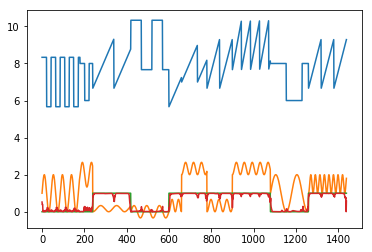

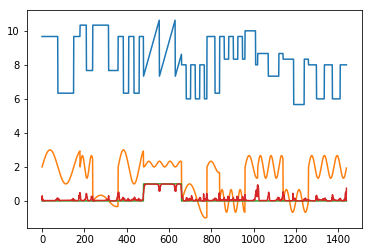

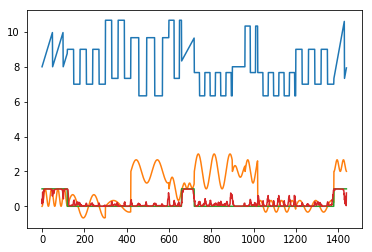

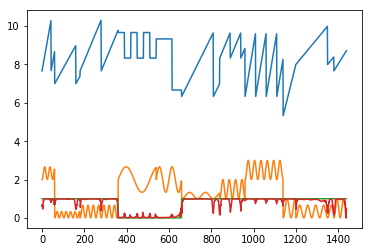

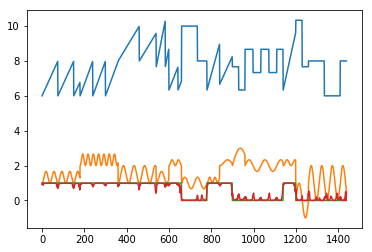

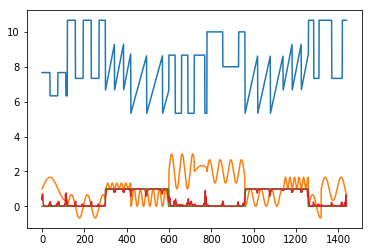

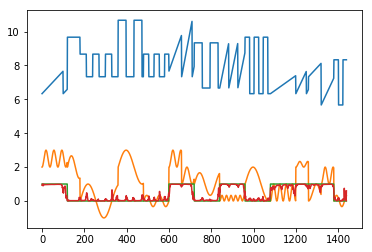

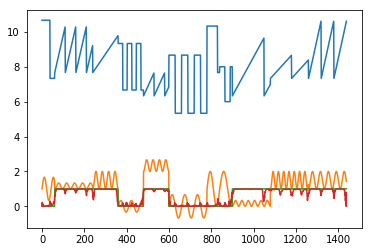

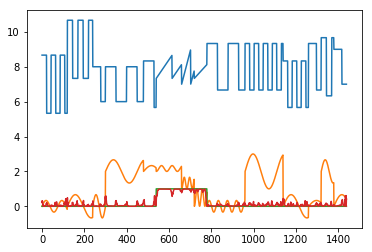

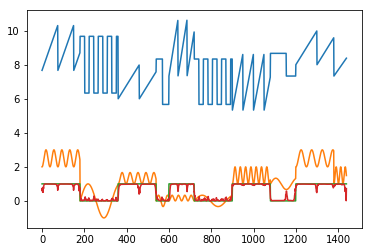

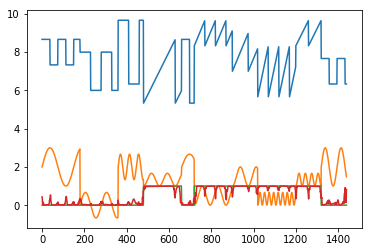

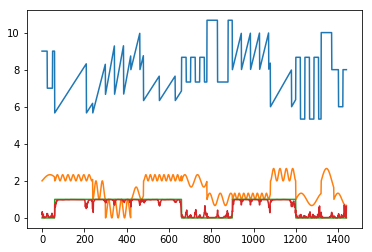

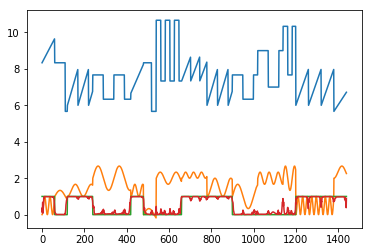

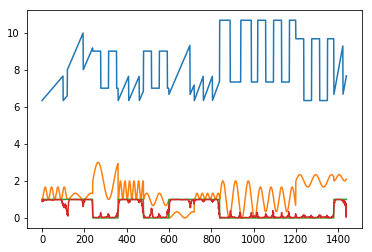

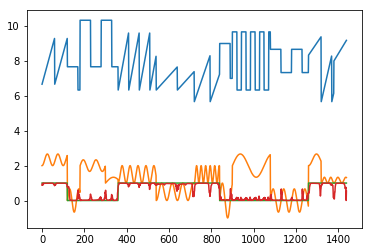

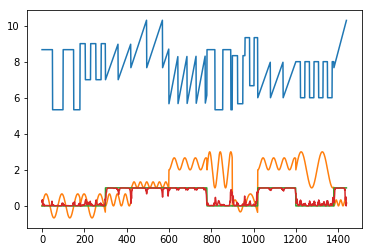

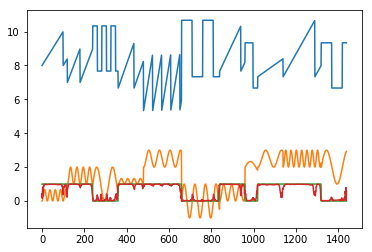

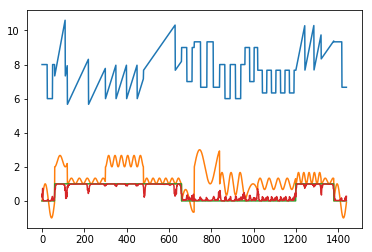

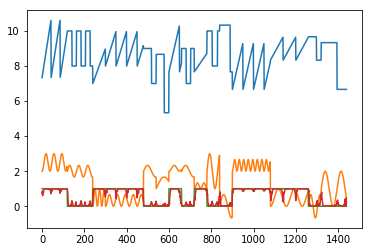

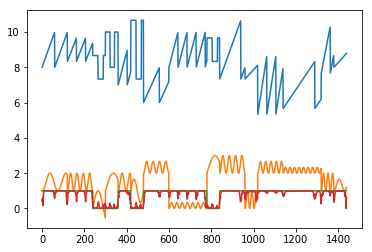

In [9]:
for i in range(20):
    plt.plot(X_TEST[i,:,0])
    plt.plot(X_TEST[i,:,1])
    plt.plot(Y_TEST[i,:,0])
    plt.plot(Y_PREDICT[i,:,0])
    #plt.plot(Y_TRAIN[i,:,0])
    plt.show()

## Further Training 1

In [10]:
import keras
BATCH_SIZE = 100
myModel = keras.models.load_model('TSSModel1.h5')
myModel.summary()
adam = optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
csv_logger = CSVLogger('TSSLog2.csv')

model_checkpoint = ModelCheckpoint('TSSModel2.h5', monitor='val_loss', verbose=1, save_best_only=True,save_weights_only=False, mode='auto', period=1)

model.compile(loss='mean_squared_error', optimizer=adam, metrics=['acc'])

model.fit(X_TRAIN, Y_TRAIN, validation_data = (X_VALID,Y_VALID), epochs=1000,

          batch_size=500, callbacks=[csv_logger,model_checkpoint])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1440, 10)          110       
_________________________________________________________________
activation_1 (Activation)    (None, 1440, 10)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1440, 10)          40        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1440, 10)          510       
_________________________________________________________________
activation_2 (Activation)    (None, 1440, 10)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1440, 10)          40        
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1440, 10)          510       
__________

1000/1000 [==============================] - 0s 368us/step - loss: 0.0225 - acc: 0.9750 - val_loss: 0.0226 - val_acc: 0.9751

Epoch 00024: val_loss improved from 0.02257 to 0.02256, saving model to TSSModel2.h5
Epoch 25/1000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0224 - acc: 0.9751 - val_loss: 0.0226 - val_acc: 0.9751

Epoch 00025: val_loss improved from 0.02256 to 0.02256, saving model to TSSModel2.h5
Epoch 26/1000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0225 - acc: 0.9750 - val_loss: 0.0226 - val_acc: 0.9751

Epoch 00026: val_loss improved from 0.02256 to 0.02255, saving model to TSSModel2.h5
Epoch 27/1000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0225 - acc: 0.9750 - val_loss: 0.0225 - val_acc: 0.9751

Epoch 00027: val_loss improved from 0.02255 to 0.02254, saving model to TSSModel2.h5
Epoch 28/1000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0224 - acc: 0.9750 - val_loss: 


Epoch 00060: val_loss did not improve from 0.02215
Epoch 61/1000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0220 - acc: 0.9755 - val_loss: 0.0221 - val_acc: 0.9755

Epoch 00061: val_loss improved from 0.02215 to 0.02214, saving model to TSSModel2.h5
Epoch 62/1000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0221 - acc: 0.9754 - val_loss: 0.0221 - val_acc: 0.9755

Epoch 00062: val_loss improved from 0.02214 to 0.02214, saving model to TSSModel2.h5
Epoch 63/1000
1000/1000 [==============================] - 0s 369us/step - loss: 0.0220 - acc: 0.9755 - val_loss: 0.0221 - val_acc: 0.9755

Epoch 00063: val_loss improved from 0.02214 to 0.02212, saving model to TSSModel2.h5
Epoch 64/1000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0220 - acc: 0.9755 - val_loss: 0.0221 - val_acc: 0.9755

Epoch 00064: val_loss improved from 0.02212 to 0.02211, saving model to TSSModel2.h5
Epoch 65/1000
1000/1000 [=======================

1000/1000 [==============================] - 0s 368us/step - loss: 0.0217 - acc: 0.9758 - val_loss: 0.0217 - val_acc: 0.9760

Epoch 00098: val_loss improved from 0.02176 to 0.02173, saving model to TSSModel2.h5
Epoch 99/1000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0217 - acc: 0.9757 - val_loss: 0.0217 - val_acc: 0.9760

Epoch 00099: val_loss improved from 0.02173 to 0.02172, saving model to TSSModel2.h5
Epoch 100/1000
1000/1000 [==============================] - 0s 370us/step - loss: 0.0216 - acc: 0.9759 - val_loss: 0.0217 - val_acc: 0.9760

Epoch 00100: val_loss improved from 0.02172 to 0.02170, saving model to TSSModel2.h5
Epoch 101/1000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0216 - acc: 0.9760 - val_loss: 0.0217 - val_acc: 0.9760

Epoch 00101: val_loss improved from 0.02170 to 0.02169, saving model to TSSModel2.h5
Epoch 102/1000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0216 - acc: 0.9759 - val_los

1000/1000 [==============================] - 0s 376us/step - loss: 0.0212 - acc: 0.9762 - val_loss: 0.0213 - val_acc: 0.9763

Epoch 00135: val_loss improved from 0.02134 to 0.02134, saving model to TSSModel2.h5
Epoch 136/1000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0212 - acc: 0.9763 - val_loss: 0.0213 - val_acc: 0.9763

Epoch 00136: val_loss did not improve from 0.02134
Epoch 137/1000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0213 - acc: 0.9762 - val_loss: 0.0213 - val_acc: 0.9764

Epoch 00137: val_loss did not improve from 0.02134
Epoch 138/1000
1000/1000 [==============================] - 0s 382us/step - loss: 0.0212 - acc: 0.9762 - val_loss: 0.0213 - val_acc: 0.9764

Epoch 00138: val_loss improved from 0.02134 to 0.02133, saving model to TSSModel2.h5
Epoch 139/1000
1000/1000 [==============================] - 0s 363us/step - loss: 0.0211 - acc: 0.9763 - val_loss: 0.0213 - val_acc: 0.9764

Epoch 00139: val_loss improved from 0.

1000/1000 [==============================] - 0s 372us/step - loss: 0.0204 - acc: 0.9772 - val_loss: 0.0206 - val_acc: 0.9772

Epoch 00209: val_loss improved from 0.02057 to 0.02057, saving model to TSSModel2.h5
Epoch 210/1000
1000/1000 [==============================] - 0s 369us/step - loss: 0.0205 - acc: 0.9770 - val_loss: 0.0206 - val_acc: 0.9772

Epoch 00210: val_loss improved from 0.02057 to 0.02056, saving model to TSSModel2.h5
Epoch 211/1000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0204 - acc: 0.9771 - val_loss: 0.0205 - val_acc: 0.9773

Epoch 00211: val_loss improved from 0.02056 to 0.02053, saving model to TSSModel2.h5
Epoch 212/1000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0204 - acc: 0.9771 - val_loss: 0.0205 - val_acc: 0.9772

Epoch 00212: val_loss improved from 0.02053 to 0.02051, saving model to TSSModel2.h5
Epoch 213/1000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0203 - acc: 0.9771 - val_lo

1000/1000 [==============================] - 0s 364us/step - loss: 0.0198 - acc: 0.9777 - val_loss: 0.0198 - val_acc: 0.9780

Epoch 00283: val_loss improved from 0.01980 to 0.01980, saving model to TSSModel2.h5
Epoch 284/1000
1000/1000 [==============================] - 0s 367us/step - loss: 0.0196 - acc: 0.9779 - val_loss: 0.0198 - val_acc: 0.9780

Epoch 00284: val_loss improved from 0.01980 to 0.01978, saving model to TSSModel2.h5
Epoch 285/1000
1000/1000 [==============================] - 0s 368us/step - loss: 0.0197 - acc: 0.9777 - val_loss: 0.0198 - val_acc: 0.9780

Epoch 00285: val_loss improved from 0.01978 to 0.01977, saving model to TSSModel2.h5
Epoch 286/1000
1000/1000 [==============================] - 0s 364us/step - loss: 0.0196 - acc: 0.9779 - val_loss: 0.0197 - val_acc: 0.9780

Epoch 00286: val_loss improved from 0.01977 to 0.01975, saving model to TSSModel2.h5
Epoch 287/1000
1000/1000 [==============================] - 0s 367us/step - loss: 0.0196 - acc: 0.9779 - val_lo

1000/1000 [==============================] - 0s 364us/step - loss: 0.0193 - acc: 0.9782 - val_loss: 0.0194 - val_acc: 0.9784

Epoch 00320: val_loss improved from 0.01944 to 0.01941, saving model to TSSModel2.h5
Epoch 321/1000
1000/1000 [==============================] - 0s 365us/step - loss: 0.0192 - acc: 0.9783 - val_loss: 0.0194 - val_acc: 0.9784

Epoch 00321: val_loss improved from 0.01941 to 0.01940, saving model to TSSModel2.h5
Epoch 322/1000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0193 - acc: 0.9783 - val_loss: 0.0194 - val_acc: 0.9784

Epoch 00322: val_loss improved from 0.01940 to 0.01939, saving model to TSSModel2.h5
Epoch 323/1000
1000/1000 [==============================] - 0s 363us/step - loss: 0.0192 - acc: 0.9783 - val_loss: 0.0194 - val_acc: 0.9784

Epoch 00323: val_loss improved from 0.01939 to 0.01937, saving model to TSSModel2.h5
Epoch 324/1000
1000/1000 [==============================] - 0s 360us/step - loss: 0.0192 - acc: 0.9783 - val_lo

1000/1000 [==============================] - 0s 362us/step - loss: 0.0189 - acc: 0.9786 - val_loss: 0.0190 - val_acc: 0.9787

Epoch 00357: val_loss improved from 0.01905 to 0.01904, saving model to TSSModel2.h5
Epoch 358/1000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0190 - acc: 0.9785 - val_loss: 0.0190 - val_acc: 0.9788

Epoch 00358: val_loss improved from 0.01904 to 0.01902, saving model to TSSModel2.h5
Epoch 359/1000
1000/1000 [==============================] - 0s 366us/step - loss: 0.0188 - acc: 0.9787 - val_loss: 0.0190 - val_acc: 0.9788

Epoch 00359: val_loss improved from 0.01902 to 0.01902, saving model to TSSModel2.h5
Epoch 360/1000
1000/1000 [==============================] - 0s 364us/step - loss: 0.0188 - acc: 0.9786 - val_loss: 0.0190 - val_acc: 0.9788

Epoch 00360: val_loss improved from 0.01902 to 0.01901, saving model to TSSModel2.h5
Epoch 361/1000
1000/1000 [==============================] - 0s 368us/step - loss: 0.0188 - acc: 0.9787 - val_lo

1000/1000 [==============================] - 0s 368us/step - loss: 0.0185 - acc: 0.9790 - val_loss: 0.0187 - val_acc: 0.9791

Epoch 00394: val_loss improved from 0.01867 to 0.01866, saving model to TSSModel2.h5
Epoch 395/1000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0185 - acc: 0.9789 - val_loss: 0.0187 - val_acc: 0.9791

Epoch 00395: val_loss improved from 0.01866 to 0.01865, saving model to TSSModel2.h5
Epoch 396/1000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0186 - acc: 0.9790 - val_loss: 0.0187 - val_acc: 0.9791

Epoch 00396: val_loss improved from 0.01865 to 0.01865, saving model to TSSModel2.h5
Epoch 397/1000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0185 - acc: 0.9790 - val_loss: 0.0186 - val_acc: 0.9791

Epoch 00397: val_loss improved from 0.01865 to 0.01864, saving model to TSSModel2.h5
Epoch 398/1000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0185 - acc: 0.9790 - val_lo

1000/1000 [==============================] - 0s 375us/step - loss: 0.0182 - acc: 0.9793 - val_loss: 0.0183 - val_acc: 0.9794

Epoch 00431: val_loss improved from 0.01833 to 0.01832, saving model to TSSModel2.h5
Epoch 432/1000
1000/1000 [==============================] - 0s 361us/step - loss: 0.0181 - acc: 0.9793 - val_loss: 0.0183 - val_acc: 0.9794

Epoch 00432: val_loss improved from 0.01832 to 0.01831, saving model to TSSModel2.h5
Epoch 433/1000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0181 - acc: 0.9793 - val_loss: 0.0183 - val_acc: 0.9794

Epoch 00433: val_loss improved from 0.01831 to 0.01831, saving model to TSSModel2.h5
Epoch 434/1000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0181 - acc: 0.9794 - val_loss: 0.0183 - val_acc: 0.9795

Epoch 00434: val_loss improved from 0.01831 to 0.01830, saving model to TSSModel2.h5
Epoch 435/1000
1000/1000 [==============================] - 0s 370us/step - loss: 0.0183 - acc: 0.9792 - val_lo

1000/1000 [==============================] - 0s 370us/step - loss: 0.0175 - acc: 0.9800 - val_loss: 0.0176 - val_acc: 0.9801

Epoch 00504: val_loss improved from 0.01765 to 0.01764, saving model to TSSModel2.h5
Epoch 505/1000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0175 - acc: 0.9799 - val_loss: 0.0176 - val_acc: 0.9801

Epoch 00505: val_loss improved from 0.01764 to 0.01763, saving model to TSSModel2.h5
Epoch 506/1000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0175 - acc: 0.9801 - val_loss: 0.0176 - val_acc: 0.9802

Epoch 00506: val_loss did not improve from 0.01763
Epoch 507/1000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0174 - acc: 0.9801 - val_loss: 0.0176 - val_acc: 0.9802

Epoch 00507: val_loss improved from 0.01763 to 0.01763, saving model to TSSModel2.h5
Epoch 508/1000
1000/1000 [==============================] - 0s 370us/step - loss: 0.0174 - acc: 0.9801 - val_loss: 0.0176 - val_acc: 0.9802

Epoc

1000/1000 [==============================] - 0s 363us/step - loss: 0.0169 - acc: 0.9807 - val_loss: 0.0171 - val_acc: 0.9808

Epoch 00579: val_loss did not improve from 0.01706
Epoch 580/1000
1000/1000 [==============================] - 0s 362us/step - loss: 0.0168 - acc: 0.9808 - val_loss: 0.0171 - val_acc: 0.9808

Epoch 00580: val_loss improved from 0.01706 to 0.01706, saving model to TSSModel2.h5
Epoch 581/1000
1000/1000 [==============================] - 0s 360us/step - loss: 0.0168 - acc: 0.9808 - val_loss: 0.0170 - val_acc: 0.9808

Epoch 00581: val_loss improved from 0.01706 to 0.01704, saving model to TSSModel2.h5
Epoch 582/1000
1000/1000 [==============================] - 0s 364us/step - loss: 0.0168 - acc: 0.9808 - val_loss: 0.0170 - val_acc: 0.9808

Epoch 00582: val_loss improved from 0.01704 to 0.01702, saving model to TSSModel2.h5
Epoch 583/1000
1000/1000 [==============================] - 0s 370us/step - loss: 0.0168 - acc: 0.9808 - val_loss: 0.0170 - val_acc: 0.9808

Epoc

1000/1000 [==============================] - 0s 372us/step - loss: 0.0165 - acc: 0.9811 - val_loss: 0.0168 - val_acc: 0.9810

Epoch 00617: val_loss improved from 0.01676 to 0.01675, saving model to TSSModel2.h5
Epoch 618/1000
1000/1000 [==============================] - 0s 370us/step - loss: 0.0166 - acc: 0.9810 - val_loss: 0.0168 - val_acc: 0.9811

Epoch 00618: val_loss did not improve from 0.01675
Epoch 619/1000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0165 - acc: 0.9810 - val_loss: 0.0167 - val_acc: 0.9811

Epoch 00619: val_loss improved from 0.01675 to 0.01675, saving model to TSSModel2.h5
Epoch 620/1000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0165 - acc: 0.9811 - val_loss: 0.0167 - val_acc: 0.9811

Epoch 00620: val_loss improved from 0.01675 to 0.01673, saving model to TSSModel2.h5
Epoch 621/1000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0165 - acc: 0.9811 - val_loss: 0.0167 - val_acc: 0.9811

Epoc

1000/1000 [==============================] - 0s 370us/step - loss: 0.0160 - acc: 0.9816 - val_loss: 0.0162 - val_acc: 0.9816

Epoch 00691: val_loss improved from 0.01623 to 0.01623, saving model to TSSModel2.h5
Epoch 692/1000
1000/1000 [==============================] - 0s 369us/step - loss: 0.0159 - acc: 0.9817 - val_loss: 0.0162 - val_acc: 0.9816

Epoch 00692: val_loss improved from 0.01623 to 0.01623, saving model to TSSModel2.h5
Epoch 693/1000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0160 - acc: 0.9816 - val_loss: 0.0162 - val_acc: 0.9817

Epoch 00693: val_loss improved from 0.01623 to 0.01622, saving model to TSSModel2.h5
Epoch 694/1000
1000/1000 [==============================] - 0s 382us/step - loss: 0.0159 - acc: 0.9817 - val_loss: 0.0162 - val_acc: 0.9817

Epoch 00694: val_loss improved from 0.01622 to 0.01621, saving model to TSSModel2.h5
Epoch 695/1000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0159 - acc: 0.9816 - val_lo

1000/1000 [==============================] - 0s 354us/step - loss: 0.0154 - acc: 0.9823 - val_loss: 0.0157 - val_acc: 0.9822

Epoch 00765: val_loss improved from 0.01566 to 0.01566, saving model to TSSModel2.h5
Epoch 766/1000
1000/1000 [==============================] - 0s 368us/step - loss: 0.0155 - acc: 0.9821 - val_loss: 0.0156 - val_acc: 0.9822

Epoch 00766: val_loss improved from 0.01566 to 0.01564, saving model to TSSModel2.h5
Epoch 767/1000
1000/1000 [==============================] - 0s 365us/step - loss: 0.0154 - acc: 0.9823 - val_loss: 0.0156 - val_acc: 0.9822

Epoch 00767: val_loss improved from 0.01564 to 0.01564, saving model to TSSModel2.h5
Epoch 768/1000
1000/1000 [==============================] - 0s 368us/step - loss: 0.0154 - acc: 0.9823 - val_loss: 0.0156 - val_acc: 0.9822

Epoch 00768: val_loss improved from 0.01564 to 0.01563, saving model to TSSModel2.h5
Epoch 769/1000
1000/1000 [==============================] - 0s 368us/step - loss: 0.0154 - acc: 0.9823 - val_lo


Epoch 00838: val_loss improved from 0.01511 to 0.01510, saving model to TSSModel2.h5
Epoch 839/1000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0149 - acc: 0.9828 - val_loss: 0.0151 - val_acc: 0.9828

Epoch 00839: val_loss improved from 0.01510 to 0.01510, saving model to TSSModel2.h5
Epoch 840/1000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0149 - acc: 0.9828 - val_loss: 0.0151 - val_acc: 0.9828

Epoch 00840: val_loss improved from 0.01510 to 0.01510, saving model to TSSModel2.h5
Epoch 841/1000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0149 - acc: 0.9827 - val_loss: 0.0151 - val_acc: 0.9829

Epoch 00841: val_loss improved from 0.01510 to 0.01509, saving model to TSSModel2.h5
Epoch 842/1000
1000/1000 [==============================] - 0s 366us/step - loss: 0.0149 - acc: 0.9828 - val_loss: 0.0151 - val_acc: 0.9829

Epoch 00842: val_loss improved from 0.01509 to 0.01507, saving model to TSSModel2.h5
Epoch 843/

1000/1000 [==============================] - 0s 366us/step - loss: 0.0146 - acc: 0.9830 - val_loss: 0.0148 - val_acc: 0.9831

Epoch 00877: val_loss improved from 0.01484 to 0.01483, saving model to TSSModel2.h5
Epoch 878/1000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0146 - acc: 0.9831 - val_loss: 0.0148 - val_acc: 0.9831

Epoch 00878: val_loss improved from 0.01483 to 0.01482, saving model to TSSModel2.h5
Epoch 879/1000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0146 - acc: 0.9831 - val_loss: 0.0148 - val_acc: 0.9831

Epoch 00879: val_loss improved from 0.01482 to 0.01482, saving model to TSSModel2.h5
Epoch 880/1000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0146 - acc: 0.9831 - val_loss: 0.0148 - val_acc: 0.9831

Epoch 00880: val_loss improved from 0.01482 to 0.01481, saving model to TSSModel2.h5
Epoch 881/1000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0146 - acc: 0.9830 - val_lo


Epoch 00913: val_loss improved from 0.01457 to 0.01457, saving model to TSSModel2.h5
Epoch 914/1000
1000/1000 [==============================] - 0s 367us/step - loss: 0.0144 - acc: 0.9833 - val_loss: 0.0146 - val_acc: 0.9834

Epoch 00914: val_loss did not improve from 0.01457
Epoch 915/1000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0144 - acc: 0.9834 - val_loss: 0.0146 - val_acc: 0.9834

Epoch 00915: val_loss did not improve from 0.01457
Epoch 916/1000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0143 - acc: 0.9834 - val_loss: 0.0146 - val_acc: 0.9834

Epoch 00916: val_loss did not improve from 0.01457
Epoch 917/1000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0144 - acc: 0.9833 - val_loss: 0.0146 - val_acc: 0.9834

Epoch 00917: val_loss improved from 0.01457 to 0.01455, saving model to TSSModel2.h5
Epoch 918/1000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0143 - acc: 0.9833 - val_los


Epoch 00950: val_loss improved from 0.01435 to 0.01434, saving model to TSSModel2.h5
Epoch 951/1000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0141 - acc: 0.9836 - val_loss: 0.0143 - val_acc: 0.9837

Epoch 00951: val_loss improved from 0.01434 to 0.01432, saving model to TSSModel2.h5
Epoch 952/1000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0141 - acc: 0.9836 - val_loss: 0.0143 - val_acc: 0.9837

Epoch 00952: val_loss improved from 0.01432 to 0.01431, saving model to TSSModel2.h5
Epoch 953/1000
1000/1000 [==============================] - 0s 378us/step - loss: 0.0141 - acc: 0.9836 - val_loss: 0.0143 - val_acc: 0.9837

Epoch 00953: val_loss improved from 0.01431 to 0.01431, saving model to TSSModel2.h5
Epoch 954/1000
1000/1000 [==============================] - 0s 368us/step - loss: 0.0142 - acc: 0.9836 - val_loss: 0.0143 - val_acc: 0.9837

Epoch 00954: val_loss did not improve from 0.01431
Epoch 955/1000
1000/1000 [==================

1000/1000 [==============================] - 0s 368us/step - loss: 0.0139 - acc: 0.9839 - val_loss: 0.0141 - val_acc: 0.9839

Epoch 00988: val_loss improved from 0.01410 to 0.01410, saving model to TSSModel2.h5
Epoch 989/1000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0139 - acc: 0.9838 - val_loss: 0.0141 - val_acc: 0.9839

Epoch 00989: val_loss improved from 0.01410 to 0.01410, saving model to TSSModel2.h5
Epoch 990/1000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0139 - acc: 0.9838 - val_loss: 0.0141 - val_acc: 0.9839

Epoch 00990: val_loss improved from 0.01410 to 0.01409, saving model to TSSModel2.h5
Epoch 991/1000
1000/1000 [==============================] - 0s 366us/step - loss: 0.0139 - acc: 0.9839 - val_loss: 0.0141 - val_acc: 0.9839

Epoch 00991: val_loss improved from 0.01409 to 0.01408, saving model to TSSModel2.h5
Epoch 992/1000
1000/1000 [==============================] - 0s 363us/step - loss: 0.0139 - acc: 0.9839 - val_lo

## Further Training 2

In [11]:
import keras
BATCH_SIZE = 100
myModel = keras.models.load_model('TSSModel2.h5')
myModel.summary()
adam = optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
csv_logger = CSVLogger('TSSLog3.csv')

model_checkpoint = ModelCheckpoint('TSSModel3.h5', monitor='val_loss', verbose=1, save_best_only=True,save_weights_only=False, mode='auto', period=1)

model.compile(loss='mean_squared_error', optimizer=adam, metrics=['acc'])

model.fit(X_TRAIN, Y_TRAIN, validation_data = (X_VALID,Y_VALID), epochs=5000,

          batch_size=500, callbacks=[csv_logger,model_checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1440, 10)          110       
_________________________________________________________________
activation_1 (Activation)    (None, 1440, 10)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1440, 10)          40        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1440, 10)          510       
_________________________________________________________________
activation_2 (Activation)    (None, 1440, 10)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1440, 10)          40        
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1440, 10)          510       
__________

1000/1000 [==============================] - 0s 377us/step - loss: 0.0137 - acc: 0.9841 - val_loss: 0.0139 - val_acc: 0.9841

Epoch 00025: val_loss improved from 0.01386 to 0.01386, saving model to TSSModel3.h5
Epoch 26/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0137 - acc: 0.9840 - val_loss: 0.0139 - val_acc: 0.9842

Epoch 00026: val_loss did not improve from 0.01386
Epoch 27/5000
1000/1000 [==============================] - 0s 381us/step - loss: 0.0136 - acc: 0.9841 - val_loss: 0.0139 - val_acc: 0.9842

Epoch 00027: val_loss improved from 0.01386 to 0.01385, saving model to TSSModel3.h5
Epoch 28/5000
1000/1000 [==============================] - 0s 379us/step - loss: 0.0137 - acc: 0.9841 - val_loss: 0.0138 - val_acc: 0.9842

Epoch 00028: val_loss improved from 0.01385 to 0.01383, saving model to TSSModel3.h5
Epoch 29/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0136 - acc: 0.9841 - val_loss: 0.0138 - val_acc: 0.9841

Epoch 00


Epoch 00062: val_loss improved from 0.01362 to 0.01360, saving model to TSSModel3.h5
Epoch 63/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0134 - acc: 0.9844 - val_loss: 0.0136 - val_acc: 0.9843

Epoch 00063: val_loss improved from 0.01360 to 0.01360, saving model to TSSModel3.h5
Epoch 64/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.0134 - acc: 0.9844 - val_loss: 0.0136 - val_acc: 0.9844

Epoch 00064: val_loss did not improve from 0.01360
Epoch 65/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0134 - acc: 0.9844 - val_loss: 0.0136 - val_acc: 0.9844

Epoch 00065: val_loss did not improve from 0.01360
Epoch 66/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0134 - acc: 0.9844 - val_loss: 0.0136 - val_acc: 0.9844

Epoch 00066: val_loss did not improve from 0.01360
Epoch 67/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.0134 - acc: 0.9843 - val_loss: 0.


Epoch 00136: val_loss improved from 0.01314 to 0.01313, saving model to TSSModel3.h5
Epoch 137/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.0129 - acc: 0.9849 - val_loss: 0.0131 - val_acc: 0.9848

Epoch 00137: val_loss improved from 0.01313 to 0.01312, saving model to TSSModel3.h5
Epoch 138/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.0129 - acc: 0.9849 - val_loss: 0.0131 - val_acc: 0.9848

Epoch 00138: val_loss improved from 0.01312 to 0.01311, saving model to TSSModel3.h5
Epoch 139/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0129 - acc: 0.9849 - val_loss: 0.0131 - val_acc: 0.9848

Epoch 00139: val_loss did not improve from 0.01311
Epoch 140/5000
1000/1000 [==============================] - 0s 370us/step - loss: 0.0129 - acc: 0.9849 - val_loss: 0.0131 - val_acc: 0.9849

Epoch 00140: val_loss improved from 0.01311 to 0.01311, saving model to TSSModel3.h5
Epoch 141/5000
1000/1000 [==================


Epoch 00173: val_loss improved from 0.01292 to 0.01292, saving model to TSSModel3.h5
Epoch 174/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0127 - acc: 0.9851 - val_loss: 0.0129 - val_acc: 0.9851

Epoch 00174: val_loss improved from 0.01292 to 0.01291, saving model to TSSModel3.h5
Epoch 175/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0127 - acc: 0.9851 - val_loss: 0.0129 - val_acc: 0.9851

Epoch 00175: val_loss improved from 0.01291 to 0.01290, saving model to TSSModel3.h5
Epoch 176/5000
1000/1000 [==============================] - 0s 366us/step - loss: 0.0126 - acc: 0.9852 - val_loss: 0.0129 - val_acc: 0.9851

Epoch 00176: val_loss improved from 0.01290 to 0.01289, saving model to TSSModel3.h5
Epoch 177/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0127 - acc: 0.9851 - val_loss: 0.0129 - val_acc: 0.9851

Epoch 00177: val_loss improved from 0.01289 to 0.01289, saving model to TSSModel3.h5
Epoch 178/

1000/1000 [==============================] - 0s 380us/step - loss: 0.0125 - acc: 0.9854 - val_loss: 0.0127 - val_acc: 0.9854

Epoch 00211: val_loss improved from 0.01270 to 0.01270, saving model to TSSModel3.h5
Epoch 212/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0124 - acc: 0.9854 - val_loss: 0.0127 - val_acc: 0.9854

Epoch 00212: val_loss improved from 0.01270 to 0.01270, saving model to TSSModel3.h5
Epoch 213/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0124 - acc: 0.9854 - val_loss: 0.0127 - val_acc: 0.9853

Epoch 00213: val_loss improved from 0.01270 to 0.01269, saving model to TSSModel3.h5
Epoch 214/5000
1000/1000 [==============================] - 0s 379us/step - loss: 0.0126 - acc: 0.9852 - val_loss: 0.0127 - val_acc: 0.9853

Epoch 00214: val_loss improved from 0.01269 to 0.01268, saving model to TSSModel3.h5
Epoch 215/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0125 - acc: 0.9854 - val_lo

1000/1000 [==============================] - 0s 376us/step - loss: 0.0121 - acc: 0.9858 - val_loss: 0.0123 - val_acc: 0.9858

Epoch 00286: val_loss improved from 0.01228 to 0.01227, saving model to TSSModel3.h5
Epoch 287/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0122 - acc: 0.9857 - val_loss: 0.0123 - val_acc: 0.9858

Epoch 00287: val_loss improved from 0.01227 to 0.01227, saving model to TSSModel3.h5
Epoch 288/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0120 - acc: 0.9858 - val_loss: 0.0123 - val_acc: 0.9858

Epoch 00288: val_loss did not improve from 0.01227
Epoch 289/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0121 - acc: 0.9858 - val_loss: 0.0123 - val_acc: 0.9858

Epoch 00289: val_loss did not improve from 0.01227
Epoch 290/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0120 - acc: 0.9858 - val_loss: 0.0123 - val_acc: 0.9858

Epoch 00290: val_loss did not improve 

1000/1000 [==============================] - 0s 375us/step - loss: 0.0117 - acc: 0.9863 - val_loss: 0.0119 - val_acc: 0.9862

Epoch 00362: val_loss improved from 0.01189 to 0.01189, saving model to TSSModel3.h5
Epoch 363/5000
1000/1000 [==============================] - 0s 380us/step - loss: 0.0117 - acc: 0.9862 - val_loss: 0.0119 - val_acc: 0.9862

Epoch 00363: val_loss improved from 0.01189 to 0.01188, saving model to TSSModel3.h5
Epoch 364/5000
1000/1000 [==============================] - 0s 382us/step - loss: 0.0116 - acc: 0.9863 - val_loss: 0.0119 - val_acc: 0.9862

Epoch 00364: val_loss improved from 0.01188 to 0.01188, saving model to TSSModel3.h5
Epoch 365/5000
1000/1000 [==============================] - 0s 366us/step - loss: 0.0116 - acc: 0.9863 - val_loss: 0.0119 - val_acc: 0.9863

Epoch 00365: val_loss did not improve from 0.01188
Epoch 366/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.0116 - acc: 0.9863 - val_loss: 0.0119 - val_acc: 0.9863

Epoc


Epoch 00399: val_loss improved from 0.01172 to 0.01172, saving model to TSSModel3.h5
Epoch 400/5000
1000/1000 [==============================] - 0s 383us/step - loss: 0.0114 - acc: 0.9865 - val_loss: 0.0117 - val_acc: 0.9864

Epoch 00400: val_loss improved from 0.01172 to 0.01171, saving model to TSSModel3.h5
Epoch 401/5000
1000/1000 [==============================] - 0s 370us/step - loss: 0.0114 - acc: 0.9865 - val_loss: 0.0117 - val_acc: 0.9865

Epoch 00401: val_loss improved from 0.01171 to 0.01170, saving model to TSSModel3.h5
Epoch 402/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.0114 - acc: 0.9865 - val_loss: 0.0117 - val_acc: 0.9865

Epoch 00402: val_loss improved from 0.01170 to 0.01170, saving model to TSSModel3.h5
Epoch 403/5000
1000/1000 [==============================] - 0s 381us/step - loss: 0.0114 - acc: 0.9865 - val_loss: 0.0117 - val_acc: 0.9865

Epoch 00403: val_loss improved from 0.01170 to 0.01170, saving model to TSSModel3.h5
Epoch 404/

1000/1000 [==============================] - 0s 367us/step - loss: 0.0113 - acc: 0.9867 - val_loss: 0.0115 - val_acc: 0.9866

Epoch 00438: val_loss improved from 0.01152 to 0.01151, saving model to TSSModel3.h5
Epoch 439/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0113 - acc: 0.9867 - val_loss: 0.0115 - val_acc: 0.9867

Epoch 00439: val_loss did not improve from 0.01151
Epoch 440/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0112 - acc: 0.9867 - val_loss: 0.0115 - val_acc: 0.9867

Epoch 00440: val_loss did not improve from 0.01151
Epoch 441/5000
1000/1000 [==============================] - 0s 379us/step - loss: 0.0113 - acc: 0.9867 - val_loss: 0.0115 - val_acc: 0.9867

Epoch 00441: val_loss improved from 0.01151 to 0.01151, saving model to TSSModel3.h5
Epoch 442/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0112 - acc: 0.9868 - val_loss: 0.0115 - val_acc: 0.9867

Epoch 00442: val_loss improved from 0.


Epoch 00476: val_loss did not improve from 0.01134
Epoch 477/5000
1000/1000 [==============================] - 0s 367us/step - loss: 0.0111 - acc: 0.9869 - val_loss: 0.0113 - val_acc: 0.9868

Epoch 00477: val_loss improved from 0.01134 to 0.01134, saving model to TSSModel3.h5
Epoch 478/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0111 - acc: 0.9870 - val_loss: 0.0113 - val_acc: 0.9868

Epoch 00478: val_loss improved from 0.01134 to 0.01132, saving model to TSSModel3.h5
Epoch 479/5000
1000/1000 [==============================] - 0s 386us/step - loss: 0.0111 - acc: 0.9870 - val_loss: 0.0113 - val_acc: 0.9868

Epoch 00479: val_loss improved from 0.01132 to 0.01131, saving model to TSSModel3.h5
Epoch 480/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0110 - acc: 0.9870 - val_loss: 0.0113 - val_acc: 0.9868

Epoch 00480: val_loss improved from 0.01131 to 0.01131, saving model to TSSModel3.h5
Epoch 481/5000
1000/1000 [==================

1000/1000 [==============================] - 0s 369us/step - loss: 0.0109 - acc: 0.9872 - val_loss: 0.0112 - val_acc: 0.9870

Epoch 00516: val_loss did not improve from 0.01115
Epoch 517/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0109 - acc: 0.9871 - val_loss: 0.0112 - val_acc: 0.9870

Epoch 00517: val_loss did not improve from 0.01115
Epoch 518/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0109 - acc: 0.9872 - val_loss: 0.0112 - val_acc: 0.9870

Epoch 00518: val_loss did not improve from 0.01115
Epoch 519/5000
1000/1000 [==============================] - 0s 380us/step - loss: 0.0109 - acc: 0.9872 - val_loss: 0.0112 - val_acc: 0.9870

Epoch 00519: val_loss did not improve from 0.01115
Epoch 520/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0109 - acc: 0.9872 - val_loss: 0.0111 - val_acc: 0.9870

Epoch 00520: val_loss improved from 0.01115 to 0.01115, saving model to TSSModel3.h5
Epoch 521/5000
1000/1

1000/1000 [==============================] - 0s 386us/step - loss: 0.0107 - acc: 0.9874 - val_loss: 0.0110 - val_acc: 0.9872

Epoch 00556: val_loss improved from 0.01100 to 0.01099, saving model to TSSModel3.h5
Epoch 557/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0107 - acc: 0.9873 - val_loss: 0.0110 - val_acc: 0.9872

Epoch 00557: val_loss improved from 0.01099 to 0.01099, saving model to TSSModel3.h5
Epoch 558/5000
1000/1000 [==============================] - 0s 389us/step - loss: 0.0107 - acc: 0.9874 - val_loss: 0.0110 - val_acc: 0.9872

Epoch 00558: val_loss improved from 0.01099 to 0.01098, saving model to TSSModel3.h5
Epoch 559/5000
1000/1000 [==============================] - 0s 383us/step - loss: 0.0107 - acc: 0.9873 - val_loss: 0.0110 - val_acc: 0.9872

Epoch 00559: val_loss improved from 0.01098 to 0.01097, saving model to TSSModel3.h5
Epoch 560/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0107 - acc: 0.9874 - val_lo

1000/1000 [==============================] - 0s 378us/step - loss: 0.0106 - acc: 0.9875 - val_loss: 0.0108 - val_acc: 0.9874

Epoch 00595: val_loss improved from 0.01085 to 0.01084, saving model to TSSModel3.h5
Epoch 596/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0106 - acc: 0.9875 - val_loss: 0.0108 - val_acc: 0.9874

Epoch 00596: val_loss did not improve from 0.01084
Epoch 597/5000
1000/1000 [==============================] - 0s 381us/step - loss: 0.0105 - acc: 0.9876 - val_loss: 0.0108 - val_acc: 0.9874

Epoch 00597: val_loss improved from 0.01084 to 0.01083, saving model to TSSModel3.h5
Epoch 598/5000
1000/1000 [==============================] - 0s 382us/step - loss: 0.0105 - acc: 0.9876 - val_loss: 0.0108 - val_acc: 0.9874

Epoch 00598: val_loss improved from 0.01083 to 0.01082, saving model to TSSModel3.h5
Epoch 599/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0105 - acc: 0.9876 - val_loss: 0.0108 - val_acc: 0.9874

Epoc

1000/1000 [==============================] - 0s 379us/step - loss: 0.0103 - acc: 0.9878 - val_loss: 0.0107 - val_acc: 0.9876

Epoch 00633: val_loss improved from 0.01066 to 0.01066, saving model to TSSModel3.h5
Epoch 634/5000
1000/1000 [==============================] - 0s 389us/step - loss: 0.0103 - acc: 0.9878 - val_loss: 0.0107 - val_acc: 0.9876

Epoch 00634: val_loss did not improve from 0.01066
Epoch 635/5000
1000/1000 [==============================] - 0s 385us/step - loss: 0.0103 - acc: 0.9878 - val_loss: 0.0107 - val_acc: 0.9876

Epoch 00635: val_loss did not improve from 0.01066
Epoch 636/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0104 - acc: 0.9877 - val_loss: 0.0107 - val_acc: 0.9876

Epoch 00636: val_loss did not improve from 0.01066
Epoch 637/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0103 - acc: 0.9878 - val_loss: 0.0106 - val_acc: 0.9876

Epoch 00637: val_loss improved from 0.01066 to 0.01065, saving model to 

1000/1000 [==============================] - 0s 379us/step - loss: 0.0102 - acc: 0.9880 - val_loss: 0.0105 - val_acc: 0.9878

Epoch 00672: val_loss improved from 0.01049 to 0.01049, saving model to TSSModel3.h5
Epoch 673/5000
1000/1000 [==============================] - 0s 379us/step - loss: 0.0102 - acc: 0.9880 - val_loss: 0.0105 - val_acc: 0.9878

Epoch 00673: val_loss did not improve from 0.01049
Epoch 674/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0103 - acc: 0.9878 - val_loss: 0.0105 - val_acc: 0.9878

Epoch 00674: val_loss did not improve from 0.01049
Epoch 675/5000
1000/1000 [==============================] - 0s 380us/step - loss: 0.0102 - acc: 0.9880 - val_loss: 0.0105 - val_acc: 0.9878

Epoch 00675: val_loss did not improve from 0.01049
Epoch 676/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.0102 - acc: 0.9880 - val_loss: 0.0105 - val_acc: 0.9878

Epoch 00676: val_loss improved from 0.01049 to 0.01048, saving model to 

1000/1000 [==============================] - 0s 373us/step - loss: 0.0099 - acc: 0.9883 - val_loss: 0.0101 - val_acc: 0.9881

Epoch 00749: val_loss improved from 0.01014 to 0.01014, saving model to TSSModel3.h5
Epoch 750/5000
1000/1000 [==============================] - 0s 388us/step - loss: 0.0098 - acc: 0.9884 - val_loss: 0.0101 - val_acc: 0.9882

Epoch 00750: val_loss did not improve from 0.01014
Epoch 751/5000
1000/1000 [==============================] - 0s 381us/step - loss: 0.0098 - acc: 0.9883 - val_loss: 0.0101 - val_acc: 0.9882

Epoch 00751: val_loss did not improve from 0.01014
Epoch 752/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0098 - acc: 0.9884 - val_loss: 0.0101 - val_acc: 0.9882

Epoch 00752: val_loss improved from 0.01014 to 0.01013, saving model to TSSModel3.h5
Epoch 753/5000
1000/1000 [==============================] - 0s 379us/step - loss: 0.0098 - acc: 0.9884 - val_loss: 0.0101 - val_acc: 0.9881

Epoch 00753: val_loss improved from 0.


Epoch 00826: val_loss did not improve from 0.00980
Epoch 827/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.0095 - acc: 0.9887 - val_loss: 0.0098 - val_acc: 0.9885

Epoch 00827: val_loss did not improve from 0.00980
Epoch 828/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.0095 - acc: 0.9887 - val_loss: 0.0098 - val_acc: 0.9885

Epoch 00828: val_loss did not improve from 0.00980
Epoch 829/5000
1000/1000 [==============================] - 0s 381us/step - loss: 0.0095 - acc: 0.9887 - val_loss: 0.0098 - val_acc: 0.9885

Epoch 00829: val_loss improved from 0.00980 to 0.00979, saving model to TSSModel3.h5
Epoch 830/5000
1000/1000 [==============================] - 0s 380us/step - loss: 0.0096 - acc: 0.9886 - val_loss: 0.0098 - val_acc: 0.9885

Epoch 00830: val_loss did not improve from 0.00979
Epoch 831/5000
1000/1000 [==============================] - 0s 385us/step - loss: 0.0095 - acc: 0.9887 - val_loss: 0.0098 - val_acc: 0.9885

Epoch

1000/1000 [==============================] - 0s 371us/step - loss: 0.0094 - acc: 0.9888 - val_loss: 0.0096 - val_acc: 0.9886

Epoch 00866: val_loss improved from 0.00964 to 0.00962, saving model to TSSModel3.h5
Epoch 867/5000
1000/1000 [==============================] - 0s 390us/step - loss: 0.0093 - acc: 0.9889 - val_loss: 0.0096 - val_acc: 0.9887

Epoch 00867: val_loss improved from 0.00962 to 0.00962, saving model to TSSModel3.h5
Epoch 868/5000
1000/1000 [==============================] - 0s 382us/step - loss: 0.0093 - acc: 0.9889 - val_loss: 0.0096 - val_acc: 0.9887

Epoch 00868: val_loss improved from 0.00962 to 0.00962, saving model to TSSModel3.h5
Epoch 869/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0093 - acc: 0.9889 - val_loss: 0.0096 - val_acc: 0.9887

Epoch 00869: val_loss improved from 0.00962 to 0.00962, saving model to TSSModel3.h5
Epoch 870/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0093 - acc: 0.9889 - val_lo

1000/1000 [==============================] - 0s 380us/step - loss: 0.0090 - acc: 0.9893 - val_loss: 0.0093 - val_acc: 0.9890

Epoch 00943: val_loss improved from 0.00931 to 0.00930, saving model to TSSModel3.h5
Epoch 944/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0090 - acc: 0.9893 - val_loss: 0.0093 - val_acc: 0.9890

Epoch 00944: val_loss improved from 0.00930 to 0.00929, saving model to TSSModel3.h5
Epoch 945/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0090 - acc: 0.9893 - val_loss: 0.0093 - val_acc: 0.9890

Epoch 00945: val_loss did not improve from 0.00929
Epoch 946/5000
1000/1000 [==============================] - 0s 379us/step - loss: 0.0090 - acc: 0.9892 - val_loss: 0.0093 - val_acc: 0.9890

Epoch 00946: val_loss did not improve from 0.00929
Epoch 947/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0090 - acc: 0.9893 - val_loss: 0.0093 - val_acc: 0.9890

Epoch 00947: val_loss did not improve 

1000/1000 [==============================] - 0s 382us/step - loss: 0.0088 - acc: 0.9895 - val_loss: 0.0090 - val_acc: 0.9894

Epoch 01020: val_loss improved from 0.00900 to 0.00900, saving model to TSSModel3.h5
Epoch 1021/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0087 - acc: 0.9896 - val_loss: 0.0090 - val_acc: 0.9894

Epoch 01021: val_loss improved from 0.00900 to 0.00899, saving model to TSSModel3.h5
Epoch 1022/5000
1000/1000 [==============================] - 0s 370us/step - loss: 0.0088 - acc: 0.9896 - val_loss: 0.0090 - val_acc: 0.9894

Epoch 01022: val_loss improved from 0.00899 to 0.00899, saving model to TSSModel3.h5
Epoch 1023/5000
1000/1000 [==============================] - 0s 380us/step - loss: 0.0087 - acc: 0.9896 - val_loss: 0.0090 - val_acc: 0.9894

Epoch 01023: val_loss improved from 0.00899 to 0.00899, saving model to TSSModel3.h5
Epoch 1024/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0087 - acc: 0.9896 - va

1000/1000 [==============================] - 0s 375us/step - loss: 0.0084 - acc: 0.9900 - val_loss: 0.0087 - val_acc: 0.9898

Epoch 01097: val_loss did not improve from 0.00870
Epoch 1098/5000
1000/1000 [==============================] - 0s 386us/step - loss: 0.0086 - acc: 0.9898 - val_loss: 0.0087 - val_acc: 0.9898

Epoch 01098: val_loss did not improve from 0.00870
Epoch 1099/5000
1000/1000 [==============================] - 0s 384us/step - loss: 0.0084 - acc: 0.9900 - val_loss: 0.0087 - val_acc: 0.9898

Epoch 01099: val_loss did not improve from 0.00870
Epoch 1100/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0084 - acc: 0.9900 - val_loss: 0.0087 - val_acc: 0.9898

Epoch 01100: val_loss improved from 0.00870 to 0.00870, saving model to TSSModel3.h5
Epoch 1101/5000
1000/1000 [==============================] - 0s 380us/step - loss: 0.0084 - acc: 0.9900 - val_loss: 0.0087 - val_acc: 0.9898

Epoch 01101: val_loss improved from 0.00870 to 0.00868, saving model

1000/1000 [==============================] - 0s 376us/step - loss: 0.0083 - acc: 0.9901 - val_loss: 0.0086 - val_acc: 0.9900

Epoch 01136: val_loss did not improve from 0.00855
Epoch 1137/5000
1000/1000 [==============================] - 0s 388us/step - loss: 0.0083 - acc: 0.9901 - val_loss: 0.0086 - val_acc: 0.9900

Epoch 01137: val_loss did not improve from 0.00855
Epoch 1138/5000
1000/1000 [==============================] - 0s 381us/step - loss: 0.0083 - acc: 0.9901 - val_loss: 0.0086 - val_acc: 0.9900

Epoch 01138: val_loss did not improve from 0.00855
Epoch 1139/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0083 - acc: 0.9901 - val_loss: 0.0086 - val_acc: 0.9900

Epoch 01139: val_loss did not improve from 0.00855
Epoch 1140/5000
1000/1000 [==============================] - 0s 380us/step - loss: 0.0083 - acc: 0.9902 - val_loss: 0.0085 - val_acc: 0.9900

Epoch 01140: val_loss improved from 0.00855 to 0.00854, saving model to TSSModel3.h5
Epoch 1141/5000
1

1000/1000 [==============================] - 0s 373us/step - loss: 0.0082 - acc: 0.9903 - val_loss: 0.0084 - val_acc: 0.9901

Epoch 01175: val_loss improved from 0.00842 to 0.00841, saving model to TSSModel3.h5
Epoch 1176/5000
1000/1000 [==============================] - 0s 381us/step - loss: 0.0082 - acc: 0.9903 - val_loss: 0.0084 - val_acc: 0.9901

Epoch 01176: val_loss improved from 0.00841 to 0.00841, saving model to TSSModel3.h5
Epoch 1177/5000
1000/1000 [==============================] - 0s 380us/step - loss: 0.0082 - acc: 0.9903 - val_loss: 0.0084 - val_acc: 0.9901

Epoch 01177: val_loss did not improve from 0.00841
Epoch 1178/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0082 - acc: 0.9902 - val_loss: 0.0084 - val_acc: 0.9902

Epoch 01178: val_loss did not improve from 0.00841
Epoch 1179/5000
1000/1000 [==============================] - 0s 384us/step - loss: 0.0081 - acc: 0.9903 - val_loss: 0.0084 - val_acc: 0.9901

Epoch 01179: val_loss did not impr


Epoch 01214: val_loss improved from 0.00828 to 0.00828, saving model to TSSModel3.h5
Epoch 1215/5000
1000/1000 [==============================] - 0s 381us/step - loss: 0.0080 - acc: 0.9904 - val_loss: 0.0083 - val_acc: 0.9903

Epoch 01215: val_loss improved from 0.00828 to 0.00827, saving model to TSSModel3.h5
Epoch 1216/5000
1000/1000 [==============================] - 0s 383us/step - loss: 0.0080 - acc: 0.9905 - val_loss: 0.0083 - val_acc: 0.9903

Epoch 01216: val_loss improved from 0.00827 to 0.00827, saving model to TSSModel3.h5
Epoch 1217/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0080 - acc: 0.9904 - val_loss: 0.0083 - val_acc: 0.9903

Epoch 01217: val_loss did not improve from 0.00827
Epoch 1218/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0080 - acc: 0.9905 - val_loss: 0.0083 - val_acc: 0.9903

Epoch 01218: val_loss did not improve from 0.00827
Epoch 1219/5000
1000/1000 [==============================] - 0s 382us/step

1000/1000 [==============================] - 0s 378us/step - loss: 0.0078 - acc: 0.9908 - val_loss: 0.0080 - val_acc: 0.9906

Epoch 01291: val_loss did not improve from 0.00802
Epoch 1292/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0077 - acc: 0.9908 - val_loss: 0.0080 - val_acc: 0.9906

Epoch 01292: val_loss did not improve from 0.00802
Epoch 1293/5000
1000/1000 [==============================] - 0s 380us/step - loss: 0.0078 - acc: 0.9908 - val_loss: 0.0080 - val_acc: 0.9906

Epoch 01293: val_loss improved from 0.00802 to 0.00802, saving model to TSSModel3.h5
Epoch 1294/5000
1000/1000 [==============================] - 0s 367us/step - loss: 0.0077 - acc: 0.9908 - val_loss: 0.0080 - val_acc: 0.9906

Epoch 01294: val_loss improved from 0.00802 to 0.00801, saving model to TSSModel3.h5
Epoch 1295/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0077 - acc: 0.9908 - val_loss: 0.0080 - val_acc: 0.9906

Epoch 01295: val_loss improved fro

1000/1000 [==============================] - 0s 381us/step - loss: 0.0076 - acc: 0.9909 - val_loss: 0.0079 - val_acc: 0.9907

Epoch 01330: val_loss improved from 0.00789 to 0.00789, saving model to TSSModel3.h5
Epoch 1331/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0078 - acc: 0.9907 - val_loss: 0.0079 - val_acc: 0.9907

Epoch 01331: val_loss improved from 0.00789 to 0.00788, saving model to TSSModel3.h5
Epoch 1332/5000
1000/1000 [==============================] - 0s 379us/step - loss: 0.0077 - acc: 0.9909 - val_loss: 0.0079 - val_acc: 0.9907

Epoch 01332: val_loss did not improve from 0.00788
Epoch 1333/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0078 - acc: 0.9908 - val_loss: 0.0079 - val_acc: 0.9908

Epoch 01333: val_loss did not improve from 0.00788
Epoch 1334/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0076 - acc: 0.9909 - val_loss: 0.0079 - val_acc: 0.9907

Epoch 01334: val_loss improved fro

1000/1000 [==============================] - 0s 372us/step - loss: 0.0074 - acc: 0.9912 - val_loss: 0.0076 - val_acc: 0.9910

Epoch 01406: val_loss improved from 0.00764 to 0.00763, saving model to TSSModel3.h5
Epoch 1407/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.0074 - acc: 0.9912 - val_loss: 0.0076 - val_acc: 0.9910

Epoch 01407: val_loss did not improve from 0.00763
Epoch 1408/5000
1000/1000 [==============================] - 0s 385us/step - loss: 0.0074 - acc: 0.9912 - val_loss: 0.0076 - val_acc: 0.9910

Epoch 01408: val_loss did not improve from 0.00763
Epoch 1409/5000
1000/1000 [==============================] - 0s 381us/step - loss: 0.0074 - acc: 0.9911 - val_loss: 0.0076 - val_acc: 0.9910

Epoch 01409: val_loss did not improve from 0.00763
Epoch 1410/5000
1000/1000 [==============================] - 0s 380us/step - loss: 0.0075 - acc: 0.9911 - val_loss: 0.0076 - val_acc: 0.9910

Epoch 01410: val_loss did not improve from 0.00763
Epoch 1411/5000
1


Epoch 01445: val_loss improved from 0.00752 to 0.00750, saving model to TSSModel3.h5
Epoch 1446/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.0073 - acc: 0.9913 - val_loss: 0.0075 - val_acc: 0.9912

Epoch 01446: val_loss improved from 0.00750 to 0.00750, saving model to TSSModel3.h5
Epoch 1447/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0073 - acc: 0.9913 - val_loss: 0.0075 - val_acc: 0.9912

Epoch 01447: val_loss improved from 0.00750 to 0.00749, saving model to TSSModel3.h5
Epoch 1448/5000
1000/1000 [==============================] - 0s 370us/step - loss: 0.0073 - acc: 0.9913 - val_loss: 0.0075 - val_acc: 0.9912

Epoch 01448: val_loss did not improve from 0.00749
Epoch 1449/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0073 - acc: 0.9914 - val_loss: 0.0075 - val_acc: 0.9912

Epoch 01449: val_loss did not improve from 0.00749
Epoch 1450/5000
1000/1000 [==============================] - 0s 378us/step

1000/1000 [==============================] - 0s 375us/step - loss: 0.0070 - acc: 0.9916 - val_loss: 0.0073 - val_acc: 0.9915

Epoch 01521: val_loss did not improve from 0.00728
Epoch 1522/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.0070 - acc: 0.9916 - val_loss: 0.0073 - val_acc: 0.9915

Epoch 01522: val_loss improved from 0.00728 to 0.00727, saving model to TSSModel3.h5
Epoch 1523/5000
1000/1000 [==============================] - 0s 370us/step - loss: 0.0070 - acc: 0.9916 - val_loss: 0.0073 - val_acc: 0.9915

Epoch 01523: val_loss improved from 0.00727 to 0.00727, saving model to TSSModel3.h5
Epoch 1524/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0071 - acc: 0.9916 - val_loss: 0.0073 - val_acc: 0.9915

Epoch 01524: val_loss improved from 0.00727 to 0.00726, saving model to TSSModel3.h5
Epoch 1525/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0071 - acc: 0.9916 - val_loss: 0.0073 - val_acc: 0.9915



1000/1000 [==============================] - 0s 377us/step - loss: 0.0069 - acc: 0.9917 - val_loss: 0.0072 - val_acc: 0.9916

Epoch 01559: val_loss improved from 0.00717 to 0.00716, saving model to TSSModel3.h5
Epoch 1560/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0069 - acc: 0.9918 - val_loss: 0.0072 - val_acc: 0.9916

Epoch 01560: val_loss improved from 0.00716 to 0.00716, saving model to TSSModel3.h5
Epoch 1561/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.0069 - acc: 0.9918 - val_loss: 0.0072 - val_acc: 0.9916

Epoch 01561: val_loss improved from 0.00716 to 0.00715, saving model to TSSModel3.h5
Epoch 1562/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0070 - acc: 0.9917 - val_loss: 0.0072 - val_acc: 0.9916

Epoch 01562: val_loss improved from 0.00715 to 0.00715, saving model to TSSModel3.h5
Epoch 1563/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0069 - acc: 0.9918 - va

1000/1000 [==============================] - 0s 379us/step - loss: 0.0069 - acc: 0.9918 - val_loss: 0.0070 - val_acc: 0.9917

Epoch 01597: val_loss improved from 0.00705 to 0.00705, saving model to TSSModel3.h5
Epoch 1598/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0068 - acc: 0.9919 - val_loss: 0.0070 - val_acc: 0.9917

Epoch 01598: val_loss improved from 0.00705 to 0.00705, saving model to TSSModel3.h5
Epoch 1599/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0068 - acc: 0.9919 - val_loss: 0.0071 - val_acc: 0.9917

Epoch 01599: val_loss did not improve from 0.00705
Epoch 1600/5000
1000/1000 [==============================] - 0s 383us/step - loss: 0.0068 - acc: 0.9919 - val_loss: 0.0071 - val_acc: 0.9917

Epoch 01600: val_loss did not improve from 0.00705
Epoch 1601/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0068 - acc: 0.9919 - val_loss: 0.0071 - val_acc: 0.9917

Epoch 01601: val_loss did not impr

1000/1000 [==============================] - 0s 383us/step - loss: 0.0067 - acc: 0.9920 - val_loss: 0.0069 - val_acc: 0.9918

Epoch 01636: val_loss did not improve from 0.00694
Epoch 1637/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0067 - acc: 0.9921 - val_loss: 0.0069 - val_acc: 0.9918

Epoch 01637: val_loss improved from 0.00694 to 0.00694, saving model to TSSModel3.h5
Epoch 1638/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0067 - acc: 0.9921 - val_loss: 0.0069 - val_acc: 0.9918

Epoch 01638: val_loss improved from 0.00694 to 0.00694, saving model to TSSModel3.h5
Epoch 1639/5000
1000/1000 [==============================] - 0s 380us/step - loss: 0.0067 - acc: 0.9920 - val_loss: 0.0069 - val_acc: 0.9918

Epoch 01639: val_loss improved from 0.00694 to 0.00693, saving model to TSSModel3.h5
Epoch 1640/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0067 - acc: 0.9920 - val_loss: 0.0069 - val_acc: 0.9918



1000/1000 [==============================] - 0s 383us/step - loss: 0.0065 - acc: 0.9923 - val_loss: 0.0067 - val_acc: 0.9921

Epoch 01711: val_loss improved from 0.00675 to 0.00675, saving model to TSSModel3.h5
Epoch 1712/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0066 - acc: 0.9922 - val_loss: 0.0067 - val_acc: 0.9921

Epoch 01712: val_loss improved from 0.00675 to 0.00675, saving model to TSSModel3.h5
Epoch 1713/5000
1000/1000 [==============================] - 0s 381us/step - loss: 0.0065 - acc: 0.9923 - val_loss: 0.0067 - val_acc: 0.9921

Epoch 01713: val_loss improved from 0.00675 to 0.00674, saving model to TSSModel3.h5
Epoch 1714/5000
1000/1000 [==============================] - 0s 384us/step - loss: 0.0065 - acc: 0.9923 - val_loss: 0.0067 - val_acc: 0.9921

Epoch 01714: val_loss improved from 0.00674 to 0.00674, saving model to TSSModel3.h5
Epoch 1715/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0065 - acc: 0.9923 - va

1000/1000 [==============================] - 0s 378us/step - loss: 0.0064 - acc: 0.9924 - val_loss: 0.0066 - val_acc: 0.9922

Epoch 01749: val_loss improved from 0.00664 to 0.00664, saving model to TSSModel3.h5
Epoch 1750/5000
1000/1000 [==============================] - 0s 382us/step - loss: 0.0065 - acc: 0.9924 - val_loss: 0.0066 - val_acc: 0.9922

Epoch 01750: val_loss did not improve from 0.00664
Epoch 1751/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0064 - acc: 0.9924 - val_loss: 0.0066 - val_acc: 0.9922

Epoch 01751: val_loss did not improve from 0.00664
Epoch 1752/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0064 - acc: 0.9924 - val_loss: 0.0066 - val_acc: 0.9922

Epoch 01752: val_loss did not improve from 0.00664
Epoch 1753/5000
1000/1000 [==============================] - 0s 385us/step - loss: 0.0064 - acc: 0.9924 - val_loss: 0.0066 - val_acc: 0.9922

Epoch 01753: val_loss did not improve from 0.00664
Epoch 1754/5000
1

1000/1000 [==============================] - 0s 374us/step - loss: 0.0063 - acc: 0.9925 - val_loss: 0.0065 - val_acc: 0.9923

Epoch 01787: val_loss improved from 0.00654 to 0.00654, saving model to TSSModel3.h5
Epoch 1788/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.0063 - acc: 0.9925 - val_loss: 0.0065 - val_acc: 0.9923

Epoch 01788: val_loss improved from 0.00654 to 0.00654, saving model to TSSModel3.h5
Epoch 1789/5000
1000/1000 [==============================] - 0s 383us/step - loss: 0.0063 - acc: 0.9925 - val_loss: 0.0065 - val_acc: 0.9923

Epoch 01789: val_loss did not improve from 0.00654
Epoch 1790/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0064 - acc: 0.9925 - val_loss: 0.0065 - val_acc: 0.9923

Epoch 01790: val_loss did not improve from 0.00654
Epoch 1791/5000
1000/1000 [==============================] - 0s 383us/step - loss: 0.0063 - acc: 0.9925 - val_loss: 0.0065 - val_acc: 0.9923

Epoch 01791: val_loss improved fro

1000/1000 [==============================] - 0s 386us/step - loss: 0.0062 - acc: 0.9927 - val_loss: 0.0064 - val_acc: 0.9925

Epoch 01861: val_loss improved from 0.00636 to 0.00636, saving model to TSSModel3.h5
Epoch 1862/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0061 - acc: 0.9927 - val_loss: 0.0064 - val_acc: 0.9925

Epoch 01862: val_loss improved from 0.00636 to 0.00636, saving model to TSSModel3.h5
Epoch 1863/5000
1000/1000 [==============================] - 0s 380us/step - loss: 0.0062 - acc: 0.9927 - val_loss: 0.0064 - val_acc: 0.9925

Epoch 01863: val_loss improved from 0.00636 to 0.00635, saving model to TSSModel3.h5
Epoch 1864/5000
1000/1000 [==============================] - 0s 381us/step - loss: 0.0061 - acc: 0.9927 - val_loss: 0.0063 - val_acc: 0.9925

Epoch 01864: val_loss improved from 0.00635 to 0.00635, saving model to TSSModel3.h5
Epoch 1865/5000
1000/1000 [==============================] - 0s 370us/step - loss: 0.0061 - acc: 0.9927 - va

1000/1000 [==============================] - 0s 381us/step - loss: 0.0060 - acc: 0.9929 - val_loss: 0.0062 - val_acc: 0.9927

Epoch 01936: val_loss improved from 0.00618 to 0.00618, saving model to TSSModel3.h5
Epoch 1937/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0061 - acc: 0.9928 - val_loss: 0.0062 - val_acc: 0.9927

Epoch 01937: val_loss improved from 0.00618 to 0.00618, saving model to TSSModel3.h5
Epoch 1938/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0060 - acc: 0.9929 - val_loss: 0.0062 - val_acc: 0.9927

Epoch 01938: val_loss improved from 0.00618 to 0.00617, saving model to TSSModel3.h5
Epoch 1939/5000
1000/1000 [==============================] - 0s 382us/step - loss: 0.0060 - acc: 0.9929 - val_loss: 0.0062 - val_acc: 0.9927

Epoch 01939: val_loss did not improve from 0.00617
Epoch 1940/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0060 - acc: 0.9929 - val_loss: 0.0062 - val_acc: 0.9927




Epoch 02010: val_loss did not improve from 0.00602
Epoch 2011/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0058 - acc: 0.9932 - val_loss: 0.0060 - val_acc: 0.9929

Epoch 02011: val_loss improved from 0.00602 to 0.00601, saving model to TSSModel3.h5
Epoch 2012/5000
1000/1000 [==============================] - 0s 366us/step - loss: 0.0058 - acc: 0.9932 - val_loss: 0.0060 - val_acc: 0.9929

Epoch 02012: val_loss improved from 0.00601 to 0.00601, saving model to TSSModel3.h5
Epoch 2013/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0058 - acc: 0.9931 - val_loss: 0.0060 - val_acc: 0.9929

Epoch 02013: val_loss improved from 0.00601 to 0.00601, saving model to TSSModel3.h5
Epoch 2014/5000
1000/1000 [==============================] - 0s 379us/step - loss: 0.0058 - acc: 0.9931 - val_loss: 0.0060 - val_acc: 0.9929

Epoch 02014: val_loss improved from 0.00601 to 0.00600, saving model to TSSModel3.h5
Epoch 2015/5000
1000/1000 [=============


Epoch 02048: val_loss improved from 0.00593 to 0.00593, saving model to TSSModel3.h5
Epoch 2049/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0057 - acc: 0.9932 - val_loss: 0.0059 - val_acc: 0.9930

Epoch 02049: val_loss did not improve from 0.00593
Epoch 2050/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.0057 - acc: 0.9932 - val_loss: 0.0059 - val_acc: 0.9931

Epoch 02050: val_loss improved from 0.00593 to 0.00593, saving model to TSSModel3.h5
Epoch 2051/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0057 - acc: 0.9932 - val_loss: 0.0059 - val_acc: 0.9930

Epoch 02051: val_loss improved from 0.00593 to 0.00592, saving model to TSSModel3.h5
Epoch 2052/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0057 - acc: 0.9933 - val_loss: 0.0059 - val_acc: 0.9931

Epoch 02052: val_loss did not improve from 0.00592
Epoch 2053/5000
1000/1000 [==============================] - 0s 381us/step

1000/1000 [==============================] - 0s 373us/step - loss: 0.0057 - acc: 0.9933 - val_loss: 0.0058 - val_acc: 0.9932

Epoch 02087: val_loss improved from 0.00585 to 0.00585, saving model to TSSModel3.h5
Epoch 2088/5000
1000/1000 [==============================] - 0s 381us/step - loss: 0.0057 - acc: 0.9933 - val_loss: 0.0058 - val_acc: 0.9932

Epoch 02088: val_loss improved from 0.00585 to 0.00584, saving model to TSSModel3.h5
Epoch 2089/5000
1000/1000 [==============================] - 0s 379us/step - loss: 0.0056 - acc: 0.9933 - val_loss: 0.0058 - val_acc: 0.9932

Epoch 02089: val_loss improved from 0.00584 to 0.00584, saving model to TSSModel3.h5
Epoch 2090/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0057 - acc: 0.9933 - val_loss: 0.0058 - val_acc: 0.9932

Epoch 02090: val_loss did not improve from 0.00584
Epoch 2091/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0056 - acc: 0.9934 - val_loss: 0.0058 - val_acc: 0.9932



1000/1000 [==============================] - 0s 375us/step - loss: 0.0055 - acc: 0.9935 - val_loss: 0.0057 - val_acc: 0.9933

Epoch 02162: val_loss did not improve from 0.00570
Epoch 2163/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0055 - acc: 0.9935 - val_loss: 0.0057 - val_acc: 0.9933

Epoch 02163: val_loss did not improve from 0.00570
Epoch 2164/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.0055 - acc: 0.9935 - val_loss: 0.0057 - val_acc: 0.9933

Epoch 02164: val_loss did not improve from 0.00570
Epoch 2165/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0055 - acc: 0.9935 - val_loss: 0.0057 - val_acc: 0.9933

Epoch 02165: val_loss improved from 0.00570 to 0.00570, saving model to TSSModel3.h5
Epoch 2166/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0055 - acc: 0.9935 - val_loss: 0.0057 - val_acc: 0.9933

Epoch 02166: val_loss improved from 0.00570 to 0.00569, saving model

1000/1000 [==============================] - 0s 373us/step - loss: 0.0053 - acc: 0.9937 - val_loss: 0.0056 - val_acc: 0.9934

Epoch 02237: val_loss improved from 0.00555 to 0.00555, saving model to TSSModel3.h5
Epoch 2238/5000
1000/1000 [==============================] - 0s 379us/step - loss: 0.0054 - acc: 0.9937 - val_loss: 0.0055 - val_acc: 0.9934

Epoch 02238: val_loss improved from 0.00555 to 0.00555, saving model to TSSModel3.h5
Epoch 2239/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0054 - acc: 0.9937 - val_loss: 0.0055 - val_acc: 0.9934

Epoch 02239: val_loss improved from 0.00555 to 0.00555, saving model to TSSModel3.h5
Epoch 2240/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0054 - acc: 0.9937 - val_loss: 0.0055 - val_acc: 0.9934

Epoch 02240: val_loss improved from 0.00555 to 0.00555, saving model to TSSModel3.h5
Epoch 2241/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.0053 - acc: 0.9937 - va


Epoch 02311: val_loss did not improve from 0.00542
Epoch 2312/5000
1000/1000 [==============================] - 0s 366us/step - loss: 0.0052 - acc: 0.9939 - val_loss: 0.0054 - val_acc: 0.9936

Epoch 02312: val_loss improved from 0.00542 to 0.00542, saving model to TSSModel3.h5
Epoch 2313/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0052 - acc: 0.9939 - val_loss: 0.0054 - val_acc: 0.9936

Epoch 02313: val_loss improved from 0.00542 to 0.00542, saving model to TSSModel3.h5
Epoch 2314/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0052 - acc: 0.9939 - val_loss: 0.0054 - val_acc: 0.9936

Epoch 02314: val_loss did not improve from 0.00542
Epoch 2315/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0052 - acc: 0.9938 - val_loss: 0.0054 - val_acc: 0.9936

Epoch 02315: val_loss improved from 0.00542 to 0.00541, saving model to TSSModel3.h5
Epoch 2316/5000
1000/1000 [==============================] - 0s 370us/step


Epoch 02384: val_loss improved from 0.00529 to 0.00529, saving model to TSSModel3.h5
Epoch 2385/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.0051 - acc: 0.9940 - val_loss: 0.0053 - val_acc: 0.9938

Epoch 02385: val_loss improved from 0.00529 to 0.00528, saving model to TSSModel3.h5
Epoch 2386/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0051 - acc: 0.9940 - val_loss: 0.0053 - val_acc: 0.9938

Epoch 02386: val_loss improved from 0.00528 to 0.00528, saving model to TSSModel3.h5
Epoch 2387/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0051 - acc: 0.9940 - val_loss: 0.0053 - val_acc: 0.9938

Epoch 02387: val_loss improved from 0.00528 to 0.00528, saving model to TSSModel3.h5
Epoch 2388/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0051 - acc: 0.9940 - val_loss: 0.0053 - val_acc: 0.9938

Epoch 02388: val_loss improved from 0.00528 to 0.00528, saving model to TSSModel3.h5
Epoch 


Epoch 02458: val_loss improved from 0.00516 to 0.00515, saving model to TSSModel3.h5
Epoch 2459/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0049 - acc: 0.9942 - val_loss: 0.0052 - val_acc: 0.9939

Epoch 02459: val_loss improved from 0.00515 to 0.00515, saving model to TSSModel3.h5
Epoch 2460/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0049 - acc: 0.9942 - val_loss: 0.0052 - val_acc: 0.9939

Epoch 02460: val_loss improved from 0.00515 to 0.00515, saving model to TSSModel3.h5
Epoch 2461/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0050 - acc: 0.9941 - val_loss: 0.0051 - val_acc: 0.9939

Epoch 02461: val_loss improved from 0.00515 to 0.00515, saving model to TSSModel3.h5
Epoch 2462/5000
1000/1000 [==============================] - 0s 370us/step - loss: 0.0050 - acc: 0.9942 - val_loss: 0.0051 - val_acc: 0.9940

Epoch 02462: val_loss improved from 0.00515 to 0.00515, saving model to TSSModel3.h5
Epoch 

1000/1000 [==============================] - 0s 386us/step - loss: 0.0049 - acc: 0.9943 - val_loss: 0.0051 - val_acc: 0.9940

Epoch 02495: val_loss improved from 0.00509 to 0.00509, saving model to TSSModel3.h5
Epoch 2496/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0049 - acc: 0.9943 - val_loss: 0.0051 - val_acc: 0.9940

Epoch 02496: val_loss did not improve from 0.00509
Epoch 2497/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0049 - acc: 0.9943 - val_loss: 0.0051 - val_acc: 0.9940

Epoch 02497: val_loss did not improve from 0.00509
Epoch 2498/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0049 - acc: 0.9943 - val_loss: 0.0051 - val_acc: 0.9940

Epoch 02498: val_loss improved from 0.00509 to 0.00509, saving model to TSSModel3.h5
Epoch 2499/5000
1000/1000 [==============================] - 0s 379us/step - loss: 0.0048 - acc: 0.9943 - val_loss: 0.0051 - val_acc: 0.9940

Epoch 02499: val_loss improved fro

1000/1000 [==============================] - 0s 373us/step - loss: 0.0048 - acc: 0.9944 - val_loss: 0.0050 - val_acc: 0.9941

Epoch 02532: val_loss improved from 0.00503 to 0.00503, saving model to TSSModel3.h5
Epoch 2533/5000
1000/1000 [==============================] - 0s 380us/step - loss: 0.0049 - acc: 0.9943 - val_loss: 0.0050 - val_acc: 0.9941

Epoch 02533: val_loss did not improve from 0.00503
Epoch 2534/5000
1000/1000 [==============================] - 0s 366us/step - loss: 0.0048 - acc: 0.9944 - val_loss: 0.0050 - val_acc: 0.9941

Epoch 02534: val_loss improved from 0.00503 to 0.00503, saving model to TSSModel3.h5
Epoch 2535/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0048 - acc: 0.9944 - val_loss: 0.0050 - val_acc: 0.9941

Epoch 02535: val_loss improved from 0.00503 to 0.00502, saving model to TSSModel3.h5
Epoch 2536/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0048 - acc: 0.9944 - val_loss: 0.0050 - val_acc: 0.9941



1000/1000 [==============================] - 0s 376us/step - loss: 0.0047 - acc: 0.9945 - val_loss: 0.0050 - val_acc: 0.9942

Epoch 02569: val_loss improved from 0.00497 to 0.00497, saving model to TSSModel3.h5
Epoch 2570/5000
1000/1000 [==============================] - 0s 362us/step - loss: 0.0048 - acc: 0.9944 - val_loss: 0.0050 - val_acc: 0.9942

Epoch 02570: val_loss improved from 0.00497 to 0.00496, saving model to TSSModel3.h5
Epoch 2571/5000
1000/1000 [==============================] - 0s 367us/step - loss: 0.0047 - acc: 0.9945 - val_loss: 0.0050 - val_acc: 0.9942

Epoch 02571: val_loss improved from 0.00496 to 0.00496, saving model to TSSModel3.h5
Epoch 2572/5000
1000/1000 [==============================] - 0s 381us/step - loss: 0.0048 - acc: 0.9944 - val_loss: 0.0050 - val_acc: 0.9942

Epoch 02572: val_loss improved from 0.00496 to 0.00496, saving model to TSSModel3.h5
Epoch 2573/5000
1000/1000 [==============================] - 0s 366us/step - loss: 0.0047 - acc: 0.9945 - va


Epoch 02642: val_loss improved from 0.00485 to 0.00484, saving model to TSSModel3.h5
Epoch 2643/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0046 - acc: 0.9946 - val_loss: 0.0048 - val_acc: 0.9943

Epoch 02643: val_loss improved from 0.00484 to 0.00484, saving model to TSSModel3.h5
Epoch 2644/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.0046 - acc: 0.9946 - val_loss: 0.0048 - val_acc: 0.9943

Epoch 02644: val_loss improved from 0.00484 to 0.00484, saving model to TSSModel3.h5
Epoch 2645/5000
1000/1000 [==============================] - 0s 365us/step - loss: 0.0046 - acc: 0.9946 - val_loss: 0.0048 - val_acc: 0.9943

Epoch 02645: val_loss improved from 0.00484 to 0.00483, saving model to TSSModel3.h5
Epoch 2646/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0047 - acc: 0.9946 - val_loss: 0.0048 - val_acc: 0.9943

Epoch 02646: val_loss improved from 0.00483 to 0.00483, saving model to TSSModel3.h5
Epoch 


Epoch 02716: val_loss improved from 0.00473 to 0.00473, saving model to TSSModel3.h5
Epoch 2717/5000
1000/1000 [==============================] - 0s 366us/step - loss: 0.0045 - acc: 0.9947 - val_loss: 0.0047 - val_acc: 0.9944

Epoch 02717: val_loss improved from 0.00473 to 0.00472, saving model to TSSModel3.h5
Epoch 2718/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0045 - acc: 0.9947 - val_loss: 0.0047 - val_acc: 0.9944

Epoch 02718: val_loss did not improve from 0.00472
Epoch 2719/5000
1000/1000 [==============================] - 0s 369us/step - loss: 0.0045 - acc: 0.9947 - val_loss: 0.0047 - val_acc: 0.9944

Epoch 02719: val_loss improved from 0.00472 to 0.00472, saving model to TSSModel3.h5
Epoch 2720/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0045 - acc: 0.9948 - val_loss: 0.0047 - val_acc: 0.9944

Epoch 02720: val_loss improved from 0.00472 to 0.00472, saving model to TSSModel3.h5
Epoch 2721/5000
1000/1000 [=============


Epoch 02754: val_loss improved from 0.00467 to 0.00466, saving model to TSSModel3.h5
Epoch 2755/5000
1000/1000 [==============================] - 0s 379us/step - loss: 0.0044 - acc: 0.9948 - val_loss: 0.0047 - val_acc: 0.9945

Epoch 02755: val_loss improved from 0.00466 to 0.00466, saving model to TSSModel3.h5
Epoch 2756/5000
1000/1000 [==============================] - 0s 370us/step - loss: 0.0044 - acc: 0.9948 - val_loss: 0.0047 - val_acc: 0.9945

Epoch 02756: val_loss did not improve from 0.00466
Epoch 2757/5000
1000/1000 [==============================] - 0s 387us/step - loss: 0.0044 - acc: 0.9948 - val_loss: 0.0047 - val_acc: 0.9945

Epoch 02757: val_loss improved from 0.00466 to 0.00466, saving model to TSSModel3.h5
Epoch 2758/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0044 - acc: 0.9948 - val_loss: 0.0047 - val_acc: 0.9946

Epoch 02758: val_loss did not improve from 0.00466
Epoch 2759/5000
1000/1000 [==============================] - 0s 368us/step

1000/1000 [==============================] - 0s 369us/step - loss: 0.0044 - acc: 0.9949 - val_loss: 0.0046 - val_acc: 0.9946

Epoch 02792: val_loss improved from 0.00461 to 0.00461, saving model to TSSModel3.h5
Epoch 2793/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0044 - acc: 0.9949 - val_loss: 0.0046 - val_acc: 0.9946

Epoch 02793: val_loss did not improve from 0.00461
Epoch 2794/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0044 - acc: 0.9949 - val_loss: 0.0046 - val_acc: 0.9947

Epoch 02794: val_loss did not improve from 0.00461
Epoch 2795/5000
1000/1000 [==============================] - 0s 366us/step - loss: 0.0044 - acc: 0.9949 - val_loss: 0.0046 - val_acc: 0.9946

Epoch 02795: val_loss improved from 0.00461 to 0.00460, saving model to TSSModel3.h5
Epoch 2796/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0044 - acc: 0.9949 - val_loss: 0.0046 - val_acc: 0.9946

Epoch 02796: val_loss improved fro

1000/1000 [==============================] - 0s 371us/step - loss: 0.0043 - acc: 0.9950 - val_loss: 0.0045 - val_acc: 0.9948

Epoch 02867: val_loss improved from 0.00450 to 0.00449, saving model to TSSModel3.h5
Epoch 2868/5000
1000/1000 [==============================] - 0s 380us/step - loss: 0.0043 - acc: 0.9950 - val_loss: 0.0045 - val_acc: 0.9948

Epoch 02868: val_loss improved from 0.00449 to 0.00449, saving model to TSSModel3.h5
Epoch 2869/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0043 - acc: 0.9950 - val_loss: 0.0045 - val_acc: 0.9947

Epoch 02869: val_loss improved from 0.00449 to 0.00449, saving model to TSSModel3.h5
Epoch 2870/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0043 - acc: 0.9950 - val_loss: 0.0045 - val_acc: 0.9948

Epoch 02870: val_loss improved from 0.00449 to 0.00449, saving model to TSSModel3.h5
Epoch 2871/5000
1000/1000 [==============================] - 0s 381us/step - loss: 0.0042 - acc: 0.9950 - va


Epoch 02904: val_loss improved from 0.00445 to 0.00444, saving model to TSSModel3.h5
Epoch 2905/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0042 - acc: 0.9951 - val_loss: 0.0044 - val_acc: 0.9948

Epoch 02905: val_loss improved from 0.00444 to 0.00444, saving model to TSSModel3.h5
Epoch 2906/5000
1000/1000 [==============================] - 0s 369us/step - loss: 0.0043 - acc: 0.9950 - val_loss: 0.0044 - val_acc: 0.9948

Epoch 02906: val_loss improved from 0.00444 to 0.00444, saving model to TSSModel3.h5
Epoch 2907/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0043 - acc: 0.9950 - val_loss: 0.0044 - val_acc: 0.9948

Epoch 02907: val_loss did not improve from 0.00444
Epoch 2908/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0042 - acc: 0.9951 - val_loss: 0.0044 - val_acc: 0.9948

Epoch 02908: val_loss did not improve from 0.00444
Epoch 2909/5000
1000/1000 [==============================] - 0s 371us/step

1000/1000 [==============================] - 0s 374us/step - loss: 0.0042 - acc: 0.9951 - val_loss: 0.0043 - val_acc: 0.9950

Epoch 02982: val_loss did not improve from 0.00434
Epoch 2983/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0041 - acc: 0.9952 - val_loss: 0.0043 - val_acc: 0.9950

Epoch 02983: val_loss did not improve from 0.00434
Epoch 2984/5000
1000/1000 [==============================] - 0s 382us/step - loss: 0.0041 - acc: 0.9952 - val_loss: 0.0043 - val_acc: 0.9950

Epoch 02984: val_loss improved from 0.00434 to 0.00433, saving model to TSSModel3.h5
Epoch 2985/5000
1000/1000 [==============================] - 0s 381us/step - loss: 0.0041 - acc: 0.9952 - val_loss: 0.0043 - val_acc: 0.9950

Epoch 02985: val_loss improved from 0.00433 to 0.00433, saving model to TSSModel3.h5
Epoch 2986/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.0041 - acc: 0.9952 - val_loss: 0.0043 - val_acc: 0.9950

Epoch 02986: val_loss improved fro

1000/1000 [==============================] - 0s 374us/step - loss: 0.0040 - acc: 0.9954 - val_loss: 0.0042 - val_acc: 0.9951

Epoch 03058: val_loss improved from 0.00423 to 0.00423, saving model to TSSModel3.h5
Epoch 3059/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0040 - acc: 0.9954 - val_loss: 0.0042 - val_acc: 0.9951

Epoch 03059: val_loss improved from 0.00423 to 0.00423, saving model to TSSModel3.h5
Epoch 3060/5000
1000/1000 [==============================] - 0s 380us/step - loss: 0.0040 - acc: 0.9953 - val_loss: 0.0042 - val_acc: 0.9951

Epoch 03060: val_loss improved from 0.00423 to 0.00423, saving model to TSSModel3.h5
Epoch 3061/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0040 - acc: 0.9954 - val_loss: 0.0042 - val_acc: 0.9951

Epoch 03061: val_loss improved from 0.00423 to 0.00422, saving model to TSSModel3.h5
Epoch 3062/5000
1000/1000 [==============================] - 0s 370us/step - loss: 0.0040 - acc: 0.9954 - va

1000/1000 [==============================] - 0s 371us/step - loss: 0.0039 - acc: 0.9955 - val_loss: 0.0041 - val_acc: 0.9952

Epoch 03134: val_loss improved from 0.00413 to 0.00413, saving model to TSSModel3.h5
Epoch 3135/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0039 - acc: 0.9955 - val_loss: 0.0041 - val_acc: 0.9952

Epoch 03135: val_loss did not improve from 0.00413
Epoch 3136/5000
1000/1000 [==============================] - 0s 366us/step - loss: 0.0039 - acc: 0.9955 - val_loss: 0.0041 - val_acc: 0.9952

Epoch 03136: val_loss did not improve from 0.00413
Epoch 3137/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0039 - acc: 0.9955 - val_loss: 0.0041 - val_acc: 0.9952

Epoch 03137: val_loss improved from 0.00413 to 0.00412, saving model to TSSModel3.h5
Epoch 3138/5000
1000/1000 [==============================] - 0s 368us/step - loss: 0.0039 - acc: 0.9955 - val_loss: 0.0041 - val_acc: 0.9952

Epoch 03138: val_loss improved fro

1000/1000 [==============================] - 0s 372us/step - loss: 0.0038 - acc: 0.9956 - val_loss: 0.0040 - val_acc: 0.9953

Epoch 03212: val_loss did not improve from 0.00403
Epoch 3213/5000
1000/1000 [==============================] - 0s 383us/step - loss: 0.0038 - acc: 0.9956 - val_loss: 0.0040 - val_acc: 0.9953

Epoch 03213: val_loss did not improve from 0.00403
Epoch 3214/5000
1000/1000 [==============================] - 0s 381us/step - loss: 0.0038 - acc: 0.9956 - val_loss: 0.0040 - val_acc: 0.9953

Epoch 03214: val_loss did not improve from 0.00403
Epoch 3215/5000
1000/1000 [==============================] - 0s 379us/step - loss: 0.0038 - acc: 0.9956 - val_loss: 0.0040 - val_acc: 0.9953

Epoch 03215: val_loss improved from 0.00403 to 0.00403, saving model to TSSModel3.h5
Epoch 3216/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.0038 - acc: 0.9956 - val_loss: 0.0040 - val_acc: 0.9953

Epoch 03216: val_loss improved from 0.00403 to 0.00402, saving model


Epoch 03250: val_loss did not improve from 0.00398
Epoch 3251/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0037 - acc: 0.9957 - val_loss: 0.0040 - val_acc: 0.9954

Epoch 03251: val_loss did not improve from 0.00398
Epoch 3252/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0037 - acc: 0.9956 - val_loss: 0.0040 - val_acc: 0.9954

Epoch 03252: val_loss did not improve from 0.00398
Epoch 3253/5000
1000/1000 [==============================] - 0s 385us/step - loss: 0.0038 - acc: 0.9956 - val_loss: 0.0040 - val_acc: 0.9954

Epoch 03253: val_loss improved from 0.00398 to 0.00398, saving model to TSSModel3.h5
Epoch 3254/5000
1000/1000 [==============================] - 0s 369us/step - loss: 0.0037 - acc: 0.9956 - val_loss: 0.0040 - val_acc: 0.9954

Epoch 03254: val_loss improved from 0.00398 to 0.00398, saving model to TSSModel3.h5
Epoch 3255/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0038 - acc: 0.9957 - va

1000/1000 [==============================] - 0s 371us/step - loss: 0.0036 - acc: 0.9958 - val_loss: 0.0039 - val_acc: 0.9955

Epoch 03330: val_loss improved from 0.00388 to 0.00388, saving model to TSSModel3.h5
Epoch 3331/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0036 - acc: 0.9958 - val_loss: 0.0039 - val_acc: 0.9955

Epoch 03331: val_loss did not improve from 0.00388
Epoch 3332/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0036 - acc: 0.9958 - val_loss: 0.0039 - val_acc: 0.9955

Epoch 03332: val_loss did not improve from 0.00388
Epoch 3333/5000
1000/1000 [==============================] - 0s 382us/step - loss: 0.0036 - acc: 0.9958 - val_loss: 0.0039 - val_acc: 0.9955

Epoch 03333: val_loss did not improve from 0.00388
Epoch 3334/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0036 - acc: 0.9958 - val_loss: 0.0039 - val_acc: 0.9955

Epoch 03334: val_loss did not improve from 0.00388
Epoch 3335/5000
1

1000/1000 [==============================] - 0s 373us/step - loss: 0.0036 - acc: 0.9958 - val_loss: 0.0038 - val_acc: 0.9956

Epoch 03370: val_loss improved from 0.00383 to 0.00383, saving model to TSSModel3.h5
Epoch 3371/5000
1000/1000 [==============================] - 0s 361us/step - loss: 0.0036 - acc: 0.9958 - val_loss: 0.0038 - val_acc: 0.9956

Epoch 03371: val_loss improved from 0.00383 to 0.00382, saving model to TSSModel3.h5
Epoch 3372/5000
1000/1000 [==============================] - 0s 363us/step - loss: 0.0036 - acc: 0.9958 - val_loss: 0.0038 - val_acc: 0.9956

Epoch 03372: val_loss did not improve from 0.00382
Epoch 3373/5000
1000/1000 [==============================] - 0s 369us/step - loss: 0.0036 - acc: 0.9958 - val_loss: 0.0038 - val_acc: 0.9955

Epoch 03373: val_loss did not improve from 0.00382
Epoch 3374/5000
1000/1000 [==============================] - 0s 365us/step - loss: 0.0036 - acc: 0.9958 - val_loss: 0.0038 - val_acc: 0.9955

Epoch 03374: val_loss did not impr


Epoch 03409: val_loss did not improve from 0.00378
Epoch 3410/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0035 - acc: 0.9959 - val_loss: 0.0038 - val_acc: 0.9956

Epoch 03410: val_loss improved from 0.00378 to 0.00378, saving model to TSSModel3.h5
Epoch 3411/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0035 - acc: 0.9959 - val_loss: 0.0038 - val_acc: 0.9956

Epoch 03411: val_loss improved from 0.00378 to 0.00378, saving model to TSSModel3.h5
Epoch 3412/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0035 - acc: 0.9959 - val_loss: 0.0038 - val_acc: 0.9956

Epoch 03412: val_loss improved from 0.00378 to 0.00378, saving model to TSSModel3.h5
Epoch 3413/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0035 - acc: 0.9959 - val_loss: 0.0038 - val_acc: 0.9956

Epoch 03413: val_loss did not improve from 0.00378
Epoch 3414/5000
1000/1000 [==============================] - 0s 371us/step

1000/1000 [==============================] - 0s 365us/step - loss: 0.0035 - acc: 0.9960 - val_loss: 0.0037 - val_acc: 0.9956

Epoch 03449: val_loss did not improve from 0.00372
Epoch 3450/5000
1000/1000 [==============================] - 0s 367us/step - loss: 0.0035 - acc: 0.9960 - val_loss: 0.0037 - val_acc: 0.9957

Epoch 03450: val_loss did not improve from 0.00372
Epoch 3451/5000
1000/1000 [==============================] - 0s 370us/step - loss: 0.0035 - acc: 0.9960 - val_loss: 0.0037 - val_acc: 0.9957

Epoch 03451: val_loss did not improve from 0.00372
Epoch 3452/5000
1000/1000 [==============================] - 0s 366us/step - loss: 0.0035 - acc: 0.9960 - val_loss: 0.0037 - val_acc: 0.9956

Epoch 03452: val_loss did not improve from 0.00372
Epoch 3453/5000
1000/1000 [==============================] - 0s 369us/step - loss: 0.0035 - acc: 0.9960 - val_loss: 0.0037 - val_acc: 0.9956

Epoch 03453: val_loss improved from 0.00372 to 0.00372, saving model to TSSModel3.h5
Epoch 3454/5000
1

1000/1000 [==============================] - 0s 378us/step - loss: 0.0034 - acc: 0.9960 - val_loss: 0.0037 - val_acc: 0.9957

Epoch 03489: val_loss improved from 0.00368 to 0.00367, saving model to TSSModel3.h5
Epoch 3490/5000
1000/1000 [==============================] - 0s 370us/step - loss: 0.0034 - acc: 0.9961 - val_loss: 0.0037 - val_acc: 0.9957

Epoch 03490: val_loss improved from 0.00367 to 0.00366, saving model to TSSModel3.h5
Epoch 3491/5000
1000/1000 [==============================] - 0s 363us/step - loss: 0.0034 - acc: 0.9961 - val_loss: 0.0037 - val_acc: 0.9957

Epoch 03491: val_loss did not improve from 0.00366
Epoch 3492/5000
1000/1000 [==============================] - 0s 366us/step - loss: 0.0034 - acc: 0.9961 - val_loss: 0.0037 - val_acc: 0.9957

Epoch 03492: val_loss did not improve from 0.00366
Epoch 3493/5000
1000/1000 [==============================] - 0s 367us/step - loss: 0.0034 - acc: 0.9961 - val_loss: 0.0037 - val_acc: 0.9957

Epoch 03493: val_loss did not impr

1000/1000 [==============================] - 0s 367us/step - loss: 0.0033 - acc: 0.9962 - val_loss: 0.0036 - val_acc: 0.9958

Epoch 03568: val_loss did not improve from 0.00358
Epoch 3569/5000
1000/1000 [==============================] - 0s 361us/step - loss: 0.0033 - acc: 0.9962 - val_loss: 0.0036 - val_acc: 0.9958

Epoch 03569: val_loss did not improve from 0.00358
Epoch 3570/5000
1000/1000 [==============================] - 0s 367us/step - loss: 0.0034 - acc: 0.9960 - val_loss: 0.0036 - val_acc: 0.9958

Epoch 03570: val_loss improved from 0.00358 to 0.00357, saving model to TSSModel3.h5
Epoch 3571/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0034 - acc: 0.9961 - val_loss: 0.0036 - val_acc: 0.9958

Epoch 03571: val_loss improved from 0.00357 to 0.00357, saving model to TSSModel3.h5
Epoch 3572/5000
1000/1000 [==============================] - 0s 364us/step - loss: 0.0033 - acc: 0.9962 - val_loss: 0.0036 - val_acc: 0.9958

Epoch 03572: val_loss improved fro

1000/1000 [==============================] - 0s 362us/step - loss: 0.0033 - acc: 0.9963 - val_loss: 0.0035 - val_acc: 0.9959

Epoch 03608: val_loss improved from 0.00353 to 0.00353, saving model to TSSModel3.h5
Epoch 3609/5000
1000/1000 [==============================] - 0s 368us/step - loss: 0.0033 - acc: 0.9962 - val_loss: 0.0035 - val_acc: 0.9959

Epoch 03609: val_loss did not improve from 0.00353
Epoch 3610/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0033 - acc: 0.9962 - val_loss: 0.0035 - val_acc: 0.9959

Epoch 03610: val_loss did not improve from 0.00353
Epoch 3611/5000
1000/1000 [==============================] - 0s 356us/step - loss: 0.0033 - acc: 0.9962 - val_loss: 0.0035 - val_acc: 0.9959

Epoch 03611: val_loss improved from 0.00353 to 0.00352, saving model to TSSModel3.h5
Epoch 3612/5000
1000/1000 [==============================] - 0s 363us/step - loss: 0.0033 - acc: 0.9962 - val_loss: 0.0035 - val_acc: 0.9959

Epoch 03612: val_loss improved fro

1000/1000 [==============================] - 0s 364us/step - loss: 0.0032 - acc: 0.9964 - val_loss: 0.0034 - val_acc: 0.9960

Epoch 03687: val_loss improved from 0.00343 to 0.00343, saving model to TSSModel3.h5
Epoch 3688/5000
1000/1000 [==============================] - 0s 366us/step - loss: 0.0032 - acc: 0.9964 - val_loss: 0.0034 - val_acc: 0.9960

Epoch 03688: val_loss improved from 0.00343 to 0.00343, saving model to TSSModel3.h5
Epoch 3689/5000
1000/1000 [==============================] - 0s 363us/step - loss: 0.0032 - acc: 0.9963 - val_loss: 0.0034 - val_acc: 0.9960

Epoch 03689: val_loss did not improve from 0.00343
Epoch 3690/5000
1000/1000 [==============================] - 0s 365us/step - loss: 0.0032 - acc: 0.9963 - val_loss: 0.0034 - val_acc: 0.9960

Epoch 03690: val_loss did not improve from 0.00343
Epoch 3691/5000
1000/1000 [==============================] - 0s 370us/step - loss: 0.0032 - acc: 0.9964 - val_loss: 0.0034 - val_acc: 0.9960

Epoch 03691: val_loss did not impr


Epoch 03726: val_loss did not improve from 0.00339
Epoch 3727/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0031 - acc: 0.9964 - val_loss: 0.0034 - val_acc: 0.9961

Epoch 03727: val_loss did not improve from 0.00339
Epoch 3728/5000
1000/1000 [==============================] - 0s 358us/step - loss: 0.0031 - acc: 0.9964 - val_loss: 0.0034 - val_acc: 0.9961

Epoch 03728: val_loss did not improve from 0.00339
Epoch 3729/5000
1000/1000 [==============================] - 0s 369us/step - loss: 0.0031 - acc: 0.9964 - val_loss: 0.0034 - val_acc: 0.9961

Epoch 03729: val_loss did not improve from 0.00339
Epoch 3730/5000
1000/1000 [==============================] - 0s 369us/step - loss: 0.0032 - acc: 0.9964 - val_loss: 0.0034 - val_acc: 0.9961

Epoch 03730: val_loss did not improve from 0.00339
Epoch 3731/5000
1000/1000 [==============================] - 0s 361us/step - loss: 0.0031 - acc: 0.9964 - val_loss: 0.0034 - val_acc: 0.9961

Epoch 03731: val_loss improved fro


Epoch 03766: val_loss did not improve from 0.00335
Epoch 3767/5000
1000/1000 [==============================] - 0s 368us/step - loss: 0.0031 - acc: 0.9965 - val_loss: 0.0034 - val_acc: 0.9962

Epoch 03767: val_loss did not improve from 0.00335
Epoch 3768/5000
1000/1000 [==============================] - 0s 368us/step - loss: 0.0031 - acc: 0.9965 - val_loss: 0.0033 - val_acc: 0.9962

Epoch 03768: val_loss did not improve from 0.00335
Epoch 3769/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0031 - acc: 0.9965 - val_loss: 0.0033 - val_acc: 0.9962

Epoch 03769: val_loss improved from 0.00335 to 0.00334, saving model to TSSModel3.h5
Epoch 3770/5000
1000/1000 [==============================] - 0s 367us/step - loss: 0.0031 - acc: 0.9965 - val_loss: 0.0033 - val_acc: 0.9962

Epoch 03770: val_loss improved from 0.00334 to 0.00334, saving model to TSSModel3.h5
Epoch 3771/5000
1000/1000 [==============================] - 0s 368us/step - loss: 0.0031 - acc: 0.9964 - va

1000/1000 [==============================] - 0s 380us/step - loss: 0.0030 - acc: 0.9966 - val_loss: 0.0033 - val_acc: 0.9963

Epoch 03846: val_loss improved from 0.00326 to 0.00326, saving model to TSSModel3.h5
Epoch 3847/5000
1000/1000 [==============================] - 0s 381us/step - loss: 0.0030 - acc: 0.9966 - val_loss: 0.0033 - val_acc: 0.9963

Epoch 03847: val_loss did not improve from 0.00326
Epoch 3848/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.0030 - acc: 0.9966 - val_loss: 0.0033 - val_acc: 0.9963

Epoch 03848: val_loss did not improve from 0.00326
Epoch 3849/5000
1000/1000 [==============================] - 0s 382us/step - loss: 0.0030 - acc: 0.9966 - val_loss: 0.0033 - val_acc: 0.9963

Epoch 03849: val_loss did not improve from 0.00326
Epoch 3850/5000
1000/1000 [==============================] - 0s 385us/step - loss: 0.0031 - acc: 0.9965 - val_loss: 0.0033 - val_acc: 0.9963

Epoch 03850: val_loss did not improve from 0.00326
Epoch 3851/5000
1

1000/1000 [==============================] - 0s 378us/step - loss: 0.0030 - acc: 0.9966 - val_loss: 0.0032 - val_acc: 0.9963

Epoch 03886: val_loss did not improve from 0.00322
Epoch 3887/5000
1000/1000 [==============================] - 0s 362us/step - loss: 0.0030 - acc: 0.9966 - val_loss: 0.0032 - val_acc: 0.9963

Epoch 03887: val_loss improved from 0.00322 to 0.00322, saving model to TSSModel3.h5
Epoch 3888/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0030 - acc: 0.9967 - val_loss: 0.0032 - val_acc: 0.9963

Epoch 03888: val_loss improved from 0.00322 to 0.00322, saving model to TSSModel3.h5
Epoch 3889/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0030 - acc: 0.9967 - val_loss: 0.0032 - val_acc: 0.9963

Epoch 03889: val_loss improved from 0.00322 to 0.00321, saving model to TSSModel3.h5
Epoch 3890/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0030 - acc: 0.9967 - val_loss: 0.0032 - val_acc: 0.9963



1000/1000 [==============================] - 0s 368us/step - loss: 0.0029 - acc: 0.9967 - val_loss: 0.0032 - val_acc: 0.9964

Epoch 03926: val_loss did not improve from 0.00318
Epoch 3927/5000
1000/1000 [==============================] - 0s 370us/step - loss: 0.0029 - acc: 0.9967 - val_loss: 0.0032 - val_acc: 0.9964

Epoch 03927: val_loss did not improve from 0.00318
Epoch 3928/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0029 - acc: 0.9967 - val_loss: 0.0032 - val_acc: 0.9964

Epoch 03928: val_loss improved from 0.00318 to 0.00318, saving model to TSSModel3.h5
Epoch 3929/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0029 - acc: 0.9967 - val_loss: 0.0032 - val_acc: 0.9964

Epoch 03929: val_loss improved from 0.00318 to 0.00317, saving model to TSSModel3.h5
Epoch 3930/5000
1000/1000 [==============================] - 0s 382us/step - loss: 0.0029 - acc: 0.9967 - val_loss: 0.0032 - val_acc: 0.9964

Epoch 03930: val_loss did not impr

1000/1000 [==============================] - 0s 370us/step - loss: 0.0029 - acc: 0.9967 - val_loss: 0.0031 - val_acc: 0.9964

Epoch 03966: val_loss improved from 0.00314 to 0.00314, saving model to TSSModel3.h5
Epoch 3967/5000
1000/1000 [==============================] - 0s 369us/step - loss: 0.0030 - acc: 0.9967 - val_loss: 0.0031 - val_acc: 0.9964

Epoch 03967: val_loss improved from 0.00314 to 0.00314, saving model to TSSModel3.h5
Epoch 3968/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0029 - acc: 0.9968 - val_loss: 0.0031 - val_acc: 0.9964

Epoch 03968: val_loss did not improve from 0.00314
Epoch 3969/5000
1000/1000 [==============================] - 0s 369us/step - loss: 0.0029 - acc: 0.9967 - val_loss: 0.0031 - val_acc: 0.9964

Epoch 03969: val_loss did not improve from 0.00314
Epoch 3970/5000
1000/1000 [==============================] - 0s 379us/step - loss: 0.0029 - acc: 0.9967 - val_loss: 0.0031 - val_acc: 0.9964

Epoch 03970: val_loss did not impr


Epoch 04005: val_loss did not improve from 0.00310
Epoch 4006/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0029 - acc: 0.9967 - val_loss: 0.0031 - val_acc: 0.9965

Epoch 04006: val_loss improved from 0.00310 to 0.00310, saving model to TSSModel3.h5
Epoch 4007/5000
1000/1000 [==============================] - 0s 366us/step - loss: 0.0029 - acc: 0.9968 - val_loss: 0.0031 - val_acc: 0.9965

Epoch 04007: val_loss did not improve from 0.00310
Epoch 4008/5000
1000/1000 [==============================] - 0s 369us/step - loss: 0.0029 - acc: 0.9968 - val_loss: 0.0031 - val_acc: 0.9965

Epoch 04008: val_loss did not improve from 0.00310
Epoch 4009/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0029 - acc: 0.9968 - val_loss: 0.0031 - val_acc: 0.9965

Epoch 04009: val_loss did not improve from 0.00310
Epoch 4010/5000
1000/1000 [==============================] - 0s 370us/step - loss: 0.0029 - acc: 0.9968 - val_loss: 0.0031 - val_acc: 0.9965




Epoch 04045: val_loss did not improve from 0.00306
Epoch 4046/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0028 - acc: 0.9968 - val_loss: 0.0031 - val_acc: 0.9965

Epoch 04046: val_loss did not improve from 0.00306
Epoch 4047/5000
1000/1000 [==============================] - 0s 368us/step - loss: 0.0028 - acc: 0.9968 - val_loss: 0.0031 - val_acc: 0.9965

Epoch 04047: val_loss did not improve from 0.00306
Epoch 4048/5000
1000/1000 [==============================] - 0s 370us/step - loss: 0.0028 - acc: 0.9968 - val_loss: 0.0031 - val_acc: 0.9965

Epoch 04048: val_loss improved from 0.00306 to 0.00306, saving model to TSSModel3.h5
Epoch 4049/5000
1000/1000 [==============================] - 0s 356us/step - loss: 0.0028 - acc: 0.9968 - val_loss: 0.0031 - val_acc: 0.9965

Epoch 04049: val_loss improved from 0.00306 to 0.00306, saving model to TSSModel3.h5
Epoch 4050/5000
1000/1000 [==============================] - 0s 369us/step - loss: 0.0028 - acc: 0.9968 - va


Epoch 04085: val_loss improved from 0.00303 to 0.00302, saving model to TSSModel3.h5
Epoch 4086/5000
1000/1000 [==============================] - 0s 360us/step - loss: 0.0028 - acc: 0.9969 - val_loss: 0.0030 - val_acc: 0.9965

Epoch 04086: val_loss improved from 0.00302 to 0.00302, saving model to TSSModel3.h5
Epoch 4087/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0028 - acc: 0.9969 - val_loss: 0.0030 - val_acc: 0.9965

Epoch 04087: val_loss improved from 0.00302 to 0.00302, saving model to TSSModel3.h5
Epoch 4088/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0028 - acc: 0.9968 - val_loss: 0.0030 - val_acc: 0.9966

Epoch 04088: val_loss did not improve from 0.00302
Epoch 4089/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0028 - acc: 0.9968 - val_loss: 0.0030 - val_acc: 0.9965

Epoch 04089: val_loss did not improve from 0.00302
Epoch 4090/5000
1000/1000 [==============================] - 0s 379us/step

1000/1000 [==============================] - 0s 368us/step - loss: 0.0027 - acc: 0.9969 - val_loss: 0.0030 - val_acc: 0.9966

Epoch 04165: val_loss did not improve from 0.00295
Epoch 4166/5000
1000/1000 [==============================] - 0s 364us/step - loss: 0.0027 - acc: 0.9969 - val_loss: 0.0030 - val_acc: 0.9966

Epoch 04166: val_loss did not improve from 0.00295
Epoch 4167/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0027 - acc: 0.9969 - val_loss: 0.0030 - val_acc: 0.9966

Epoch 04167: val_loss did not improve from 0.00295
Epoch 4168/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0027 - acc: 0.9969 - val_loss: 0.0030 - val_acc: 0.9966

Epoch 04168: val_loss did not improve from 0.00295
Epoch 4169/5000
1000/1000 [==============================] - 0s 369us/step - loss: 0.0027 - acc: 0.9969 - val_loss: 0.0030 - val_acc: 0.9966

Epoch 04169: val_loss did not improve from 0.00295
Epoch 4170/5000
1000/1000 [========================

1000/1000 [==============================] - 0s 369us/step - loss: 0.0027 - acc: 0.9970 - val_loss: 0.0029 - val_acc: 0.9967

Epoch 04245: val_loss did not improve from 0.00288
Epoch 4246/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0027 - acc: 0.9970 - val_loss: 0.0029 - val_acc: 0.9967

Epoch 04246: val_loss improved from 0.00288 to 0.00288, saving model to TSSModel3.h5
Epoch 4247/5000
1000/1000 [==============================] - 0s 369us/step - loss: 0.0027 - acc: 0.9970 - val_loss: 0.0029 - val_acc: 0.9967

Epoch 04247: val_loss did not improve from 0.00288
Epoch 4248/5000
1000/1000 [==============================] - 0s 365us/step - loss: 0.0026 - acc: 0.9970 - val_loss: 0.0029 - val_acc: 0.9967

Epoch 04248: val_loss did not improve from 0.00288
Epoch 4249/5000
1000/1000 [==============================] - 0s 364us/step - loss: 0.0026 - acc: 0.9970 - val_loss: 0.0029 - val_acc: 0.9967

Epoch 04249: val_loss did not improve from 0.00288
Epoch 4250/5000
1


Epoch 04324: val_loss did not improve from 0.00281
Epoch 4325/5000
1000/1000 [==============================] - 0s 374us/step - loss: 0.0026 - acc: 0.9971 - val_loss: 0.0028 - val_acc: 0.9968

Epoch 04325: val_loss improved from 0.00281 to 0.00281, saving model to TSSModel3.h5
Epoch 4326/5000
1000/1000 [==============================] - 0s 366us/step - loss: 0.0026 - acc: 0.9971 - val_loss: 0.0028 - val_acc: 0.9968

Epoch 04326: val_loss improved from 0.00281 to 0.00281, saving model to TSSModel3.h5
Epoch 4327/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0026 - acc: 0.9970 - val_loss: 0.0028 - val_acc: 0.9968

Epoch 04327: val_loss improved from 0.00281 to 0.00281, saving model to TSSModel3.h5
Epoch 4328/5000
1000/1000 [==============================] - 0s 364us/step - loss: 0.0026 - acc: 0.9971 - val_loss: 0.0028 - val_acc: 0.9968

Epoch 04328: val_loss did not improve from 0.00281
Epoch 4329/5000
1000/1000 [==============================] - 0s 372us/step

1000/1000 [==============================] - 0s 363us/step - loss: 0.0026 - acc: 0.9971 - val_loss: 0.0028 - val_acc: 0.9968

Epoch 04364: val_loss improved from 0.00277 to 0.00277, saving model to TSSModel3.h5
Epoch 4365/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0025 - acc: 0.9971 - val_loss: 0.0028 - val_acc: 0.9968

Epoch 04365: val_loss did not improve from 0.00277
Epoch 4366/5000
1000/1000 [==============================] - 0s 368us/step - loss: 0.0026 - acc: 0.9971 - val_loss: 0.0028 - val_acc: 0.9968

Epoch 04366: val_loss did not improve from 0.00277
Epoch 4367/5000
1000/1000 [==============================] - 0s 370us/step - loss: 0.0025 - acc: 0.9971 - val_loss: 0.0028 - val_acc: 0.9968

Epoch 04367: val_loss improved from 0.00277 to 0.00277, saving model to TSSModel3.h5
Epoch 4368/5000
1000/1000 [==============================] - 0s 380us/step - loss: 0.0025 - acc: 0.9971 - val_loss: 0.0028 - val_acc: 0.9968

Epoch 04368: val_loss improved fro

1000/1000 [==============================] - 0s 375us/step - loss: 0.0025 - acc: 0.9972 - val_loss: 0.0027 - val_acc: 0.9969

Epoch 04442: val_loss did not improve from 0.00271
Epoch 4443/5000
1000/1000 [==============================] - 0s 383us/step - loss: 0.0025 - acc: 0.9972 - val_loss: 0.0027 - val_acc: 0.9969

Epoch 04443: val_loss did not improve from 0.00271
Epoch 4444/5000
1000/1000 [==============================] - 0s 385us/step - loss: 0.0025 - acc: 0.9972 - val_loss: 0.0027 - val_acc: 0.9969

Epoch 04444: val_loss did not improve from 0.00271
Epoch 4445/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0025 - acc: 0.9972 - val_loss: 0.0027 - val_acc: 0.9969

Epoch 04445: val_loss improved from 0.00271 to 0.00270, saving model to TSSModel3.h5
Epoch 4446/5000
1000/1000 [==============================] - 0s 379us/step - loss: 0.0025 - acc: 0.9972 - val_loss: 0.0027 - val_acc: 0.9969

Epoch 04446: val_loss improved from 0.00270 to 0.00270, saving model

1000/1000 [==============================] - 0s 372us/step - loss: 0.0024 - acc: 0.9973 - val_loss: 0.0027 - val_acc: 0.9969

Epoch 04482: val_loss improved from 0.00268 to 0.00267, saving model to TSSModel3.h5
Epoch 4483/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0025 - acc: 0.9972 - val_loss: 0.0027 - val_acc: 0.9969

Epoch 04483: val_loss improved from 0.00267 to 0.00267, saving model to TSSModel3.h5
Epoch 4484/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0025 - acc: 0.9972 - val_loss: 0.0027 - val_acc: 0.9969

Epoch 04484: val_loss did not improve from 0.00267
Epoch 4485/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0025 - acc: 0.9972 - val_loss: 0.0027 - val_acc: 0.9969

Epoch 04485: val_loss did not improve from 0.00267
Epoch 4486/5000
1000/1000 [==============================] - 0s 380us/step - loss: 0.0024 - acc: 0.9973 - val_loss: 0.0027 - val_acc: 0.9969

Epoch 04486: val_loss did not impr


Epoch 04521: val_loss did not improve from 0.00264
Epoch 4522/5000
1000/1000 [==============================] - 0s 379us/step - loss: 0.0024 - acc: 0.9973 - val_loss: 0.0026 - val_acc: 0.9970

Epoch 04522: val_loss improved from 0.00264 to 0.00264, saving model to TSSModel3.h5
Epoch 4523/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0024 - acc: 0.9973 - val_loss: 0.0026 - val_acc: 0.9970

Epoch 04523: val_loss improved from 0.00264 to 0.00264, saving model to TSSModel3.h5
Epoch 4524/5000
1000/1000 [==============================] - 0s 380us/step - loss: 0.0024 - acc: 0.9972 - val_loss: 0.0026 - val_acc: 0.9970

Epoch 04524: val_loss improved from 0.00264 to 0.00264, saving model to TSSModel3.h5
Epoch 4525/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0024 - acc: 0.9973 - val_loss: 0.0026 - val_acc: 0.9970

Epoch 04525: val_loss did not improve from 0.00264
Epoch 4526/5000
1000/1000 [==============================] - 0s 369us/step


Epoch 04561: val_loss did not improve from 0.00262
Epoch 4562/5000
1000/1000 [==============================] - 0s 363us/step - loss: 0.0024 - acc: 0.9973 - val_loss: 0.0026 - val_acc: 0.9970

Epoch 04562: val_loss did not improve from 0.00262
Epoch 4563/5000
1000/1000 [==============================] - 0s 364us/step - loss: 0.0024 - acc: 0.9973 - val_loss: 0.0026 - val_acc: 0.9970

Epoch 04563: val_loss did not improve from 0.00262
Epoch 4564/5000
1000/1000 [==============================] - 0s 366us/step - loss: 0.0024 - acc: 0.9973 - val_loss: 0.0026 - val_acc: 0.9970

Epoch 04564: val_loss did not improve from 0.00262
Epoch 4565/5000
1000/1000 [==============================] - 0s 363us/step - loss: 0.0024 - acc: 0.9973 - val_loss: 0.0026 - val_acc: 0.9970

Epoch 04565: val_loss did not improve from 0.00262
Epoch 4566/5000
1000/1000 [==============================] - 0s 366us/step - loss: 0.0024 - acc: 0.9973 - val_loss: 0.0026 - val_acc: 0.9970

Epoch 04566: val_loss improved fro


Epoch 04601: val_loss did not improve from 0.00258
Epoch 4602/5000
1000/1000 [==============================] - 0s 368us/step - loss: 0.0024 - acc: 0.9974 - val_loss: 0.0026 - val_acc: 0.9971

Epoch 04602: val_loss did not improve from 0.00258
Epoch 4603/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0024 - acc: 0.9973 - val_loss: 0.0026 - val_acc: 0.9970

Epoch 04603: val_loss did not improve from 0.00258
Epoch 4604/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0024 - acc: 0.9974 - val_loss: 0.0026 - val_acc: 0.9971

Epoch 04604: val_loss improved from 0.00258 to 0.00258, saving model to TSSModel3.h5
Epoch 4605/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0024 - acc: 0.9973 - val_loss: 0.0026 - val_acc: 0.9970

Epoch 04605: val_loss improved from 0.00258 to 0.00258, saving model to TSSModel3.h5
Epoch 4606/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0024 - acc: 0.9973 - va


Epoch 04641: val_loss did not improve from 0.00255
Epoch 4642/5000
1000/1000 [==============================] - 0s 361us/step - loss: 0.0023 - acc: 0.9974 - val_loss: 0.0026 - val_acc: 0.9971

Epoch 04642: val_loss did not improve from 0.00255
Epoch 4643/5000
1000/1000 [==============================] - 0s 366us/step - loss: 0.0024 - acc: 0.9974 - val_loss: 0.0026 - val_acc: 0.9971

Epoch 04643: val_loss did not improve from 0.00255
Epoch 4644/5000
1000/1000 [==============================] - 0s 367us/step - loss: 0.0023 - acc: 0.9974 - val_loss: 0.0026 - val_acc: 0.9971

Epoch 04644: val_loss improved from 0.00255 to 0.00255, saving model to TSSModel3.h5
Epoch 4645/5000
1000/1000 [==============================] - 0s 377us/step - loss: 0.0023 - acc: 0.9974 - val_loss: 0.0025 - val_acc: 0.9971

Epoch 04645: val_loss improved from 0.00255 to 0.00255, saving model to TSSModel3.h5
Epoch 4646/5000
1000/1000 [==============================] - 0s 370us/step - loss: 0.0023 - acc: 0.9974 - va


Epoch 04681: val_loss did not improve from 0.00252
Epoch 4682/5000
1000/1000 [==============================] - 0s 364us/step - loss: 0.0023 - acc: 0.9974 - val_loss: 0.0025 - val_acc: 0.9971

Epoch 04682: val_loss did not improve from 0.00252
Epoch 4683/5000
1000/1000 [==============================] - 0s 370us/step - loss: 0.0023 - acc: 0.9974 - val_loss: 0.0025 - val_acc: 0.9971

Epoch 04683: val_loss did not improve from 0.00252
Epoch 4684/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0023 - acc: 0.9974 - val_loss: 0.0025 - val_acc: 0.9971

Epoch 04684: val_loss improved from 0.00252 to 0.00252, saving model to TSSModel3.h5
Epoch 4685/5000
1000/1000 [==============================] - 0s 366us/step - loss: 0.0023 - acc: 0.9974 - val_loss: 0.0025 - val_acc: 0.9971

Epoch 04685: val_loss improved from 0.00252 to 0.00252, saving model to TSSModel3.h5
Epoch 4686/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0023 - acc: 0.9974 - va


Epoch 04721: val_loss improved from 0.00250 to 0.00249, saving model to TSSModel3.h5
Epoch 4722/5000
1000/1000 [==============================] - 0s 376us/step - loss: 0.0023 - acc: 0.9975 - val_loss: 0.0025 - val_acc: 0.9971

Epoch 04722: val_loss improved from 0.00249 to 0.00249, saving model to TSSModel3.h5
Epoch 4723/5000
1000/1000 [==============================] - 0s 367us/step - loss: 0.0023 - acc: 0.9974 - val_loss: 0.0025 - val_acc: 0.9972

Epoch 04723: val_loss improved from 0.00249 to 0.00249, saving model to TSSModel3.h5
Epoch 4724/5000
1000/1000 [==============================] - 0s 375us/step - loss: 0.0023 - acc: 0.9975 - val_loss: 0.0025 - val_acc: 0.9972

Epoch 04724: val_loss did not improve from 0.00249
Epoch 4725/5000
1000/1000 [==============================] - 0s 370us/step - loss: 0.0023 - acc: 0.9975 - val_loss: 0.0025 - val_acc: 0.9972

Epoch 04725: val_loss did not improve from 0.00249
Epoch 4726/5000
1000/1000 [==============================] - 0s 377us/step

1000/1000 [==============================] - 0s 377us/step - loss: 0.0022 - acc: 0.9975 - val_loss: 0.0025 - val_acc: 0.9972

Epoch 04762: val_loss did not improve from 0.00246
Epoch 4763/5000
1000/1000 [==============================] - 0s 364us/step - loss: 0.0022 - acc: 0.9975 - val_loss: 0.0025 - val_acc: 0.9972

Epoch 04763: val_loss did not improve from 0.00246
Epoch 4764/5000
1000/1000 [==============================] - 0s 371us/step - loss: 0.0022 - acc: 0.9975 - val_loss: 0.0025 - val_acc: 0.9972

Epoch 04764: val_loss did not improve from 0.00246
Epoch 4765/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0023 - acc: 0.9975 - val_loss: 0.0025 - val_acc: 0.9972

Epoch 04765: val_loss did not improve from 0.00246
Epoch 4766/5000
1000/1000 [==============================] - 0s 358us/step - loss: 0.0022 - acc: 0.9975 - val_loss: 0.0025 - val_acc: 0.9972

Epoch 04766: val_loss did not improve from 0.00246
Epoch 4767/5000
1000/1000 [========================

1000/1000 [==============================] - 0s 382us/step - loss: 0.0022 - acc: 0.9975 - val_loss: 0.0024 - val_acc: 0.9972

Epoch 04842: val_loss did not improve from 0.00241
Epoch 4843/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0022 - acc: 0.9976 - val_loss: 0.0024 - val_acc: 0.9972

Epoch 04843: val_loss did not improve from 0.00241
Epoch 4844/5000
1000/1000 [==============================] - 0s 354us/step - loss: 0.0022 - acc: 0.9975 - val_loss: 0.0024 - val_acc: 0.9972

Epoch 04844: val_loss improved from 0.00241 to 0.00241, saving model to TSSModel3.h5
Epoch 4845/5000
1000/1000 [==============================] - 0s 373us/step - loss: 0.0022 - acc: 0.9976 - val_loss: 0.0024 - val_acc: 0.9972

Epoch 04845: val_loss did not improve from 0.00241
Epoch 4846/5000
1000/1000 [==============================] - 0s 379us/step - loss: 0.0022 - acc: 0.9975 - val_loss: 0.0024 - val_acc: 0.9972

Epoch 04846: val_loss did not improve from 0.00241
Epoch 4847/5000
1

1000/1000 [==============================] - 0s 359us/step - loss: 0.0022 - acc: 0.9976 - val_loss: 0.0024 - val_acc: 0.9973

Epoch 04882: val_loss did not improve from 0.00239
Epoch 4883/5000
1000/1000 [==============================] - 0s 362us/step - loss: 0.0022 - acc: 0.9975 - val_loss: 0.0024 - val_acc: 0.9973

Epoch 04883: val_loss did not improve from 0.00239
Epoch 4884/5000
1000/1000 [==============================] - 0s 362us/step - loss: 0.0022 - acc: 0.9976 - val_loss: 0.0024 - val_acc: 0.9973

Epoch 04884: val_loss did not improve from 0.00239
Epoch 4885/5000
1000/1000 [==============================] - 0s 366us/step - loss: 0.0022 - acc: 0.9976 - val_loss: 0.0024 - val_acc: 0.9973

Epoch 04885: val_loss did not improve from 0.00239
Epoch 4886/5000
1000/1000 [==============================] - 0s 359us/step - loss: 0.0022 - acc: 0.9976 - val_loss: 0.0024 - val_acc: 0.9973

Epoch 04886: val_loss did not improve from 0.00239
Epoch 4887/5000
1000/1000 [========================

1000/1000 [==============================] - 0s 374us/step - loss: 0.0021 - acc: 0.9976 - val_loss: 0.0024 - val_acc: 0.9973

Epoch 04923: val_loss did not improve from 0.00235
Epoch 4924/5000
1000/1000 [==============================] - 0s 378us/step - loss: 0.0021 - acc: 0.9976 - val_loss: 0.0024 - val_acc: 0.9973

Epoch 04924: val_loss did not improve from 0.00235
Epoch 4925/5000
1000/1000 [==============================] - 0s 356us/step - loss: 0.0021 - acc: 0.9976 - val_loss: 0.0024 - val_acc: 0.9973

Epoch 04925: val_loss did not improve from 0.00235
Epoch 4926/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0022 - acc: 0.9976 - val_loss: 0.0024 - val_acc: 0.9973

Epoch 04926: val_loss did not improve from 0.00235
Epoch 4927/5000
1000/1000 [==============================] - 0s 369us/step - loss: 0.0021 - acc: 0.9976 - val_loss: 0.0024 - val_acc: 0.9973

Epoch 04927: val_loss did not improve from 0.00235
Epoch 4928/5000
1000/1000 [========================

1000/1000 [==============================] - 0s 363us/step - loss: 0.0021 - acc: 0.9976 - val_loss: 0.0023 - val_acc: 0.9973

Epoch 04964: val_loss did not improve from 0.00233
Epoch 4965/5000
1000/1000 [==============================] - 0s 368us/step - loss: 0.0021 - acc: 0.9976 - val_loss: 0.0023 - val_acc: 0.9973

Epoch 04965: val_loss did not improve from 0.00233
Epoch 4966/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0021 - acc: 0.9976 - val_loss: 0.0023 - val_acc: 0.9973

Epoch 04966: val_loss improved from 0.00233 to 0.00233, saving model to TSSModel3.h5
Epoch 4967/5000
1000/1000 [==============================] - 0s 363us/step - loss: 0.0021 - acc: 0.9976 - val_loss: 0.0023 - val_acc: 0.9973

Epoch 04967: val_loss improved from 0.00233 to 0.00233, saving model to TSSModel3.h5
Epoch 4968/5000
1000/1000 [==============================] - 0s 372us/step - loss: 0.0021 - acc: 0.9976 - val_loss: 0.0023 - val_acc: 0.9973

Epoch 04968: val_loss did not impr

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1440, 10)          110       
_________________________________________________________________
activation_1 (Activation)    (None, 1440, 10)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1440, 10)          40        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1440, 10)          510       
_________________________________________________________________
activation_2 (Activation)    (None, 1440, 10)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1440, 10)          40        
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1440, 10)          510       
__________

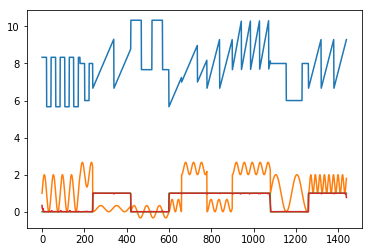

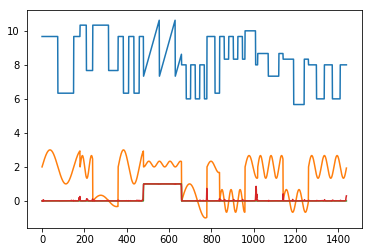

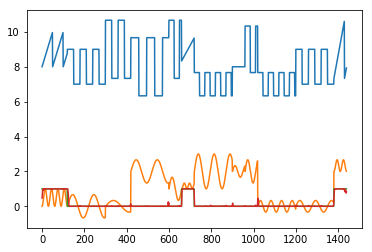

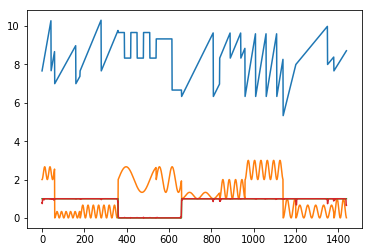

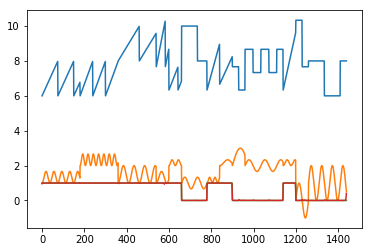

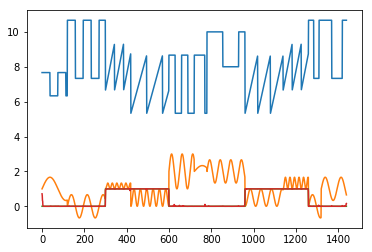

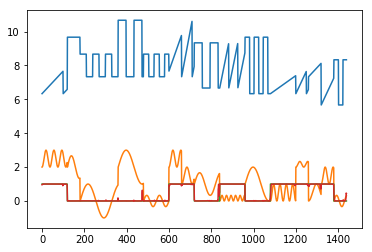

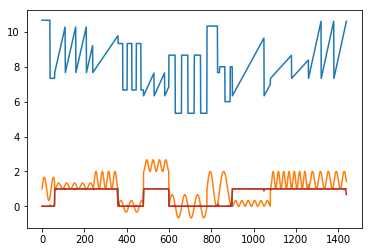

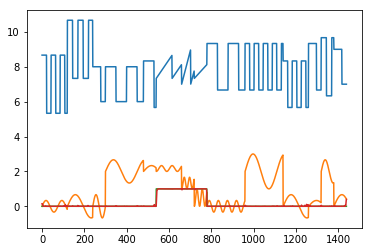

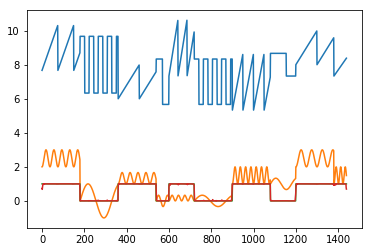

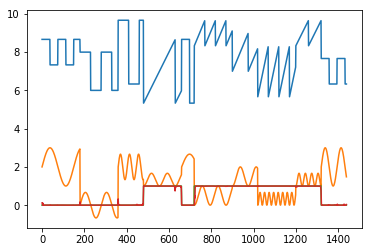

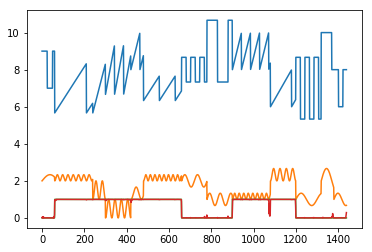

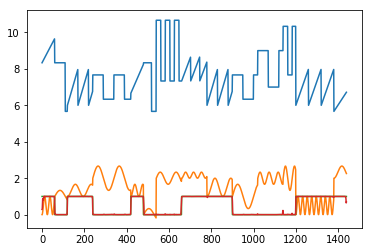

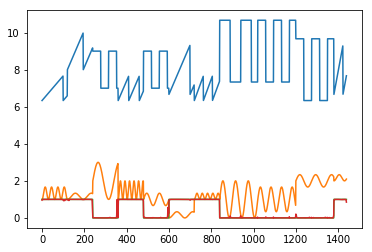

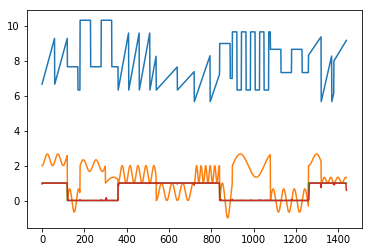

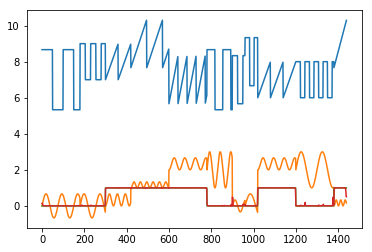

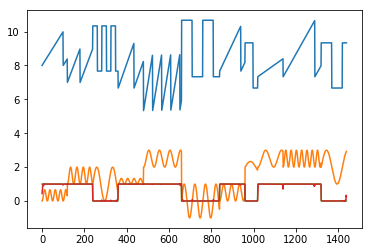

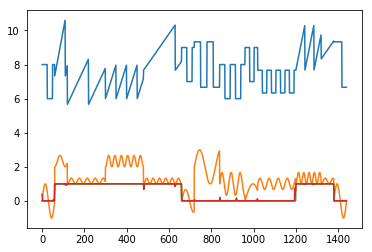

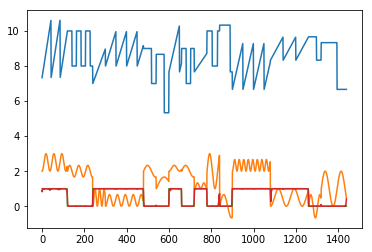

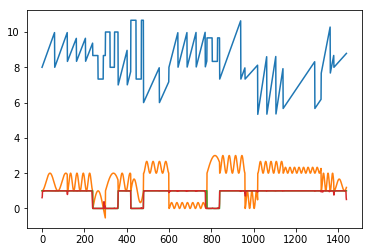

In [12]:
import keras
BATCH_SIZE = 100
myModel = keras.models.load_model('TSSModel3.h5')
myModel.summary()
Y_PREDICT = myModel.predict(X_TEST, batch_size=BATCH_SIZE, verbose=1)
for i in range(20):
    plt.plot(X_TEST[i,:,0])
    plt.plot(X_TEST[i,:,1])
    plt.plot(Y_TEST[i,:,0])
    plt.plot(Y_PREDICT[i,:,0])
    #plt.plot(Y_TRAIN[i,:,0])
    plt.show()

## Test the model for time series of varying length

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1440, 10)          110       
_________________________________________________________________
activation_1 (Activation)    (None, 1440, 10)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1440, 10)          40        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1440, 10)          510       
_________________________________________________________________
activation_2 (Activation)    (None, 1440, 10)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1440, 10)          40        
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1440, 10)          510       
__________

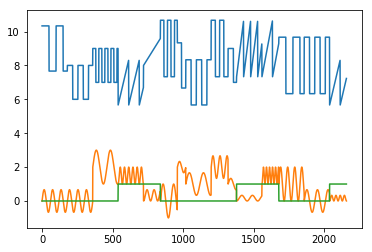

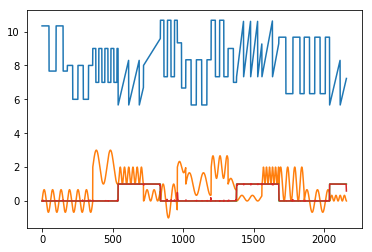

In [8]:
import keras as ks
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D,Conv1D, MaxPooling1D
from keras.utils import np_utils
from keras.initializers import RandomNormal
from keras import backend as Ks
from keras import optimizers
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint,CSVLogger
import keras
DURATION = 36
TOTAL_PTS = DURATION*60
BATCH_SIZE = 10
[X1,X2,Y] = generateSignal(DURATION)
N_TEST = 1
X_TEST = np.zeros((N_TEST,TOTAL_PTS,2), dtype=np.float64)
Y_TEST = np.zeros((N_TEST,TOTAL_PTS,1), dtype=np.float64)
X_TEST[0,:,0] = X1
X_TEST[0,:,1] = X2
Y_TEST[0,:,0] = Y
myFinalModel = keras.models.load_model('TSSModel3.h5')
myFinalModel.summary()
# But we need to change the input shape of model according to our new data "myFinalModelModified"
myFinalModelModified = ks.Sequential()
myFinalModelModified.add(ks.layers.Conv1D(filters=10, kernel_size=5, strides=1, input_shape=(TOTAL_PTS,2),
                           padding='same',use_bias=True, 
                           kernel_initializer='glorot_uniform', bias_initializer='zeros'))
myFinalModelModified.add(Activation('relu'))
myFinalModelModified.add(BatchNormalization())

myFinalModelModified.add(ks.layers.Conv1D(filters=10, kernel_size=5, strides=1,
                           padding='same',use_bias=True, 
                           kernel_initializer='glorot_uniform', bias_initializer='zeros'))
myFinalModelModified.add(Activation('relu'))
myFinalModelModified.add(BatchNormalization())

myFinalModelModified.add(ks.layers.Conv1D(filters=10, kernel_size=5, strides=1,
                           padding='same',use_bias=True, 
                           kernel_initializer='glorot_uniform', bias_initializer='zeros'))
myFinalModelModified.add(Activation('relu'))
myFinalModelModified.add(BatchNormalization())

myFinalModelModified.add(ks.layers.Conv1D(filters=10, kernel_size=5, strides=1,
                           padding='same',use_bias=True, 
                           kernel_initializer='glorot_uniform', bias_initializer='zeros'))
myFinalModelModified.add(Activation('relu'))
myFinalModelModified.add(BatchNormalization())

myFinalModelModified.add(ks.layers.Conv1D(filters=10, kernel_size=5, strides=1,
                           padding='same',use_bias=True, 
                           kernel_initializer='glorot_uniform', bias_initializer='zeros'))
myFinalModelModified.add(Activation('relu'))
myFinalModelModified.add(BatchNormalization())

myFinalModelModified.add(ks.layers.Conv1D(filters=10, kernel_size=5, strides=1,
                           padding='same',use_bias=True, 
                           kernel_initializer='glorot_uniform', bias_initializer='zeros'))
myFinalModelModified.add(Activation('relu'))
myFinalModelModified.add(BatchNormalization())

myFinalModelModified.add(ks.layers.Conv1D(filters=1, kernel_size=5, strides=1,
                           padding='same',use_bias=True, 
                           kernel_initializer='glorot_uniform', bias_initializer='zeros'))
myFinalModelModified.add(Activation('sigmoid'))

# Getting weights of myFinalModel and setting them in myFinalModelModified
myFinalModelModified.set_weights(myFinalModel.get_weights())
myFinalModelModified.summary()
Y_PREDICT = myFinalModelModified.predict(X_TEST, batch_size=BATCH_SIZE, verbose=1)
plt.plot(X_TEST[0,:,0])
plt.plot(X_TEST[0,:,1])
plt.plot(Y_TEST[0,:,0])
plt.show()
plt.plot(X_TEST[0,:,0])
plt.plot(X_TEST[0,:,1])
plt.plot(Y_TEST[0,:,0])
plt.plot(Y_PREDICT[0,:,0])
plt.show()